<h1 style='color: yellow'> Metric Generator </h1>

Generates all the ToE metrics

In [1]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from enum import Enum
from typing import NamedTuple
from time import sleep, time
from glob import glob
from pathlib import Path
# Third-Party Library Imports
import numpy as np
from numpy.typing import ArrayLike
import pandas as pd
import xarray as xr
import dask
from scipy.stats import spearmanr
# Plotting imports
import hvplot.xarray
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker as mticker
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))
import constants
import utils
import plotting_utils
import climate_utils
import my_stats
import diagnostic_tools
import paths

import toe_calc as toe_calc
import toe_data_analysis as toe_da
import toe_constants as toe_const
import open_data
from toe_constants import PVALUE_THESHOLD1, OVERLAP_THRESHOLD, SN_THRESHOLD1
import toe_plots
import toe_constants as toe_const
import plotting_utils
import misc
# Suppress Warnings
import warnings
from dask.distributed import Client, wait

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', message="p-value floored: true value smaller than 0.001")
warnings.filterwarnings('ignore', message="p-value capped: true value larger than 0.25")

Matplotlib created a temporary cache directory at /jobfs/152932399.gadi-pbs/matplotlib-zy0dfrqs because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [2]:
import utils
from utils import logger

In [3]:
xr.set_options(display_expand_data=False)

In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='numpy.lib.function_base')

In [5]:
# # client = Client(threads_per_worker=1, n_workers=20)
# client.close()
client = Client(n_workers=30, threads_per_worker=1, memory_limit=None) 
client

<Client: 'tcp://127.0.0.1:40065' processes=30 threads=30>

In [6]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=True)
np.set_printoptions(precision=2, suppress=True, edgeitems=1)

<h1 style='color:yellow'> Opening Data </h1>

## Data Config

In [7]:
np.sort(os.listdir(constants.TOE_SAVE_DIR))

array(['.ipynb_checkpoints', 'access_ssp585_pr_(1880_1909)_02',
       'access_ssp585_pr_(1880_1909)_03',
       'access_ssp585_pr_(1880_1909)_04',
       'access_ssp585_pr_multi_base_period.zarr',
       'access_ssp585_pr_region_aggregationv2.zarr',
       'access_ssp585_tas_(1880_1909)_02',
       'access_ssp585_tas_(1880_1909)_04',
       'access_ssp585_tas_(1900_1929)_02',
       'access_ssp585_tas_(1900_1930)_02',
       'access_ssp585_tas_(1900_1930)_03',
       'access_ssp585_tas_multi_base_period_v4.zarr',
       'access_ssp585_tas_multi_base_period_v5_tmp.zarr',
       'access_ssp585_tas_region_aggregation.zarr',
       'best_tas_(1880_1909)_02', 'best_tas_(1880_1909)_04',
       'best_tas_(1920_1950)_16p0x16p0', 'best_tas_(1920_1950)_2p0x2p0',
       'best_tas_(1920_1950)_32p0x32p0', 'best_tas_(1920_1950)_4p0x4p0',
       'best_tas_(1920_1950)_8p0x8p0', 'best_tas_multi_base_period.zarr',
       'best_tas_region_aggregation.zarr', 'best_tas_regrid_conservative',
       'to_del

In [8]:
# Create a data set for the base period used as the pre-industrial climate 
# base_period = #(1959, 1989)#(1900, 1950)#(1900, 1931)
base_period = toe_const.BasePeriod(1880, 1909) # Base period should finish 1 year before
# base_period = toe_const.BasePeriod(1900, 1930) # Base period should finish 1 year before

#toe_const.YearRange.ERA5_START
base_period, base_period.start, base_period.end, np.mean([base_period.start, base_period.end])

(BasePeriod(start=1880, end=1909, length=29), 1880, 1909, 1894.5)

In [9]:
base_period.length, base_period.value

(29, (1880, 1909))

In [10]:
# dataset_name = f'{model}_{resolution}'
# model = 'cesm1_lens'

In [11]:
version = '04'

In [12]:
# ACCESS
model = 'access'
experiment = 'ssp585'
variable = 'pr'#'tas' #pr
dataset_name = f'{model}_{experiment}'

# BEST
# variable = 'tas'
# model  =  'best'
# dataset_name = model

#'gpcc', 'pr'#'era5',  'tx99count' # 'best', 'tas''tx99p9count'

In [13]:
# ACCESS_CHUNKS =
# {'time':-1, 'member':1, 'lat': 72//12, 'lon':144//12}
# {'time':-1, 'member':1, 'lat': 72//4, 'lon':144//2}
# {"member": 1, "lat": 18, "lon": 72, "time": -1}#{"member": 1, "lat": 36, "lon": 72, "time": -1}


CHUNK_DICT = {
    'best': {'time':-1, 'lat': 180//10, 'lon': 360//10},
    'access': {'time':-1, 'member':1, 'lat': 72//4, 'lon':-1}
}

In [14]:
chunks = CHUNK_DICT[model] #chunks_best_small# LE_CESM_CHUNKS
chunks

{'time': -1, 'member': 1, 'lat': 18, 'lon': -1}

In [15]:
# If no ensemble

if model == 'best':
    plot_kwargs = {} 
    member_kwargs = {}
else:
    # If ensemble
    plot_kwargs = {'hue':'member', 'add_legend':False} 
    member_kwargs = {'member': 0}

In [16]:
# f'/g/data/w40/ab2313/time_of_emergence/{model}_{experiment}.zarr'

In [17]:
t_start = time()

In [18]:
np.sort(os.listdir(constants.TOE_SAVE_DIR))

array(['.ipynb_checkpoints', 'access_ssp585_pr_(1880_1909)_02',
       'access_ssp585_pr_(1880_1909)_03',
       'access_ssp585_pr_(1880_1909)_04',
       'access_ssp585_pr_multi_base_period.zarr',
       'access_ssp585_pr_region_aggregationv2.zarr',
       'access_ssp585_tas_(1880_1909)_02',
       'access_ssp585_tas_(1880_1909)_04',
       'access_ssp585_tas_(1900_1929)_02',
       'access_ssp585_tas_(1900_1930)_02',
       'access_ssp585_tas_(1900_1930)_03',
       'access_ssp585_tas_multi_base_period_v4.zarr',
       'access_ssp585_tas_multi_base_period_v5_tmp.zarr',
       'access_ssp585_tas_region_aggregation.zarr',
       'best_tas_(1880_1909)_02', 'best_tas_(1880_1909)_04',
       'best_tas_(1920_1950)_16p0x16p0', 'best_tas_(1920_1950)_2p0x2p0',
       'best_tas_(1920_1950)_32p0x32p0', 'best_tas_(1920_1950)_4p0x4p0',
       'best_tas_(1920_1950)_8p0x8p0', 'best_tas_multi_base_period.zarr',
       'best_tas_region_aggregation.zarr', 'best_tas_regrid_conservative',
       'to_del

In [19]:
VAR_SAVE_DIR = os.path.join(
    constants.TOE_SAVE_DIR, f'{dataset_name}_{variable}_({base_period.start}_{base_period.end})_{version}')
                            
VAR_SAVE_DIR

'/g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_pr_(1880_1909)_04'

In [20]:
os.makedirs(VAR_SAVE_DIR, exist_ok=True)
# # I actually do want error if already exists
# # os.rmdir(VAR_SAVE_DIR)
# os.makedirs(VAR_SAVE_DIR, exist_ok=True)

## Open Data

In [21]:
exp_type = None #'_region', '_resolution', '_base_period'

In [22]:
# # BEST
# data_ds = open_data.open_best(chunks).persist()
# wait(data_ds);

In [23]:
FILE_NAME = f'/g/data/w40/ab2313/time_of_emergence/{model}_{experiment}_{variable}.zarr'
print(FILE_NAME)
data_ds = xr.open_dataset(FILE_NAME, engine='zarr', chunks=chunks)[variable].persist()
wait(data_ds);

/g/data/w40/ab2313/time_of_emergence/access_ssp585_pr.zarr


## Spatial Averaging 

In [24]:
def add_region_coord(ds, regions = None):
    """
    Subset a dataset by regions and combine them along a 'region' dimension.
    """

    if regions == None: regions = toe_const.regionLatLonTuples
    ds_collection = []
    for region in regions:
        region_name = region.name.lower()
        logger.info(f"Processing region: {region_name}")

        # Slice the dataset to the region’s lat–lon range
        ds_region = ds.sel(lat=region.value.latlon)
        ds_region = ds_region.expand_dims({'region': [region_name]})
        ds_collection.append(ds_region)

    ds_with_region = xr.concat(ds_collection, dim="region")
    return ds_with_region


## Regridding 

In [25]:
# import xesmf

In [26]:
#  ds_out = xr.Dataset(
#     {
#         "lat": (["lat"], data_ds.lat.values[::32]),  # Every other latitude
#         "lon": (["lon"], data_ds.lon.values[::32])  # Every other longitude
#     }
# )
# ds_out

In [27]:
# regridder = xesmf.Regridder(data_ds, ds_out, method="bilinear")  # Use bilinear interpolation

In [28]:
# data_ds_regridded = regridder(data_ds).persist()
# wait(data_ds_regridded);

In [29]:
# fig = plt.figure(figsize=(18, 6))

# ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree())
# ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
# data_ds.isel(time=30).plot(ax=ax1, levels=np.arange(-4, 4.25, .25))
# data_ds_regridded.isel(time=30).plot(ax=ax2, levels=np.arange(-4, 4.25, .25))

# axes = [ax1, ax2]
# [ax.coastlines() for ax in axes];

In [30]:
# lat_res = np.abs(np.diff(data_ds.lat.values))[0]
# lon_res = np.abs(np.diff(data_ds.lon.values))[0]

# lat_res_new = np.abs(np.diff(data_ds_regridded.lat.values))[0]
# lon_res_new = np.abs(np.diff(data_ds_regridded.lon.values))[0]

# print(f'Original : {lat_res} x {lon_res} \nNew      : {lat_res_new} x {lon_res_new}')

In [31]:
# ! Only run when confident with data

# data_ds = data_ds_regridded

In [32]:
# resolution = f'{lat_res_new}x{lon_res_new}'.replace('.', 'p')
# resolution

In [33]:
# VAR_SAVE_DIR = os.path.join(
#     constants.TOE_SAVE_DIR, f'{dataset_name}_{variable}_({base_period.start}_{base_period.end})_{resolution}')
                            
# VAR_SAVE_DIR

In [34]:
# os.makedirs(VAR_SAVE_DIR, exist_ok=True)

In [35]:
# PICONTROL_PATH = '/g/data/oi10/replicas/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/tas/gn/v20190320'

<h2 style='color:cyan'> Data Check </h2>

In [36]:
data_ds = data_ds.transpose(..., "time").chunk(chunks).persist()
wait(data_ds);

In [37]:
data_full_ds = data_ds.copy(deep=True)

In [38]:
data_ds

<xarray.DataArray 'pr' (member: 40, lat: 72, lon: 144, time: 251)> Size: 833MB
dask.array<transpose, shape=(40, 72, 144, 251), dtype=float64, chunksize=(1, 18, 144, 251), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member   (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time     (time) datetime64[ns] 2kB 1850-12-31 1851-12-31 ... 2100-12-31
Attributes: (1)

In [39]:
# Remove data that occurs before this
data_ds = data_ds.sel(time=data_ds.time.dt.year>=base_period.start)
data_ds

<xarray.DataArray 'pr' (member: 40, lat: 72, lon: 144, time: 221)> Size: 733MB
dask.array<getitem, shape=(40, 72, 144, 221), dtype=float64, chunksize=(1, 18, 144, 221), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member   (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time     (time) datetime64[ns] 2kB 1880-12-31 1881-12-31 ... 2100-12-31
Attributes: (1)

In [40]:
chunks

{'time': -1, 'member': 1, 'lat': 18, 'lon': -1}

In [41]:
# Make sure chunks is 1
assert len(data_ds.chunksizes['time']) == 1

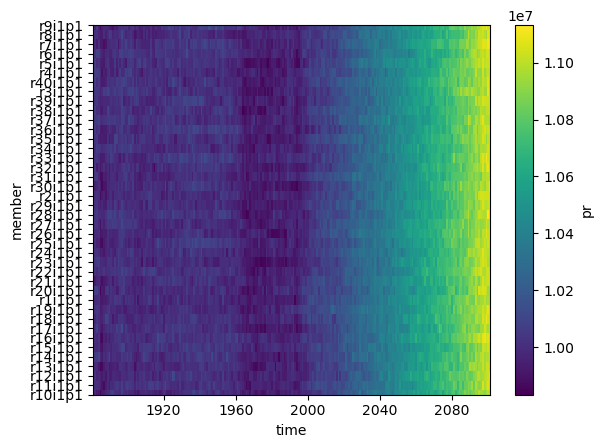

In [42]:
# data_ds.mean(dim=['lat', 'lon']).plot()
data_ds.sum(dim=['lat', 'lon']).plot()

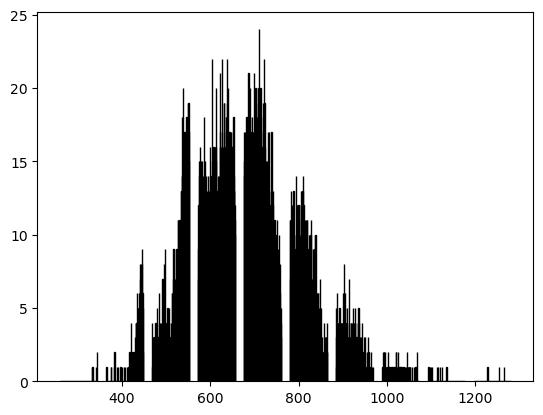

In [43]:
plt.hist(data_ds.sel(lat=-38, lon=145, method='nearest').squeeze().values, edgecolor='k');

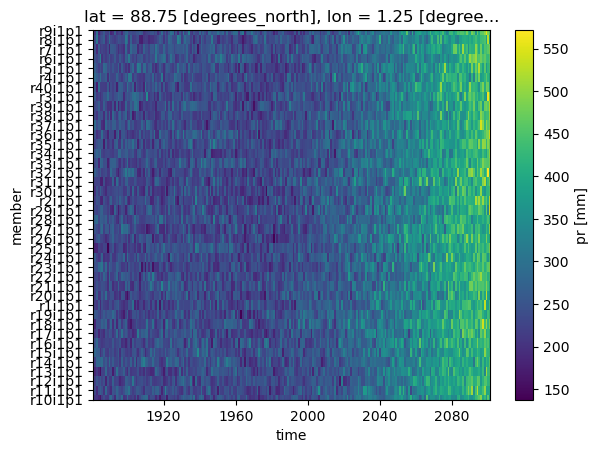

In [44]:
data_ds.sel(lat=89.5, lon=-29.75, method='nearest').plot()

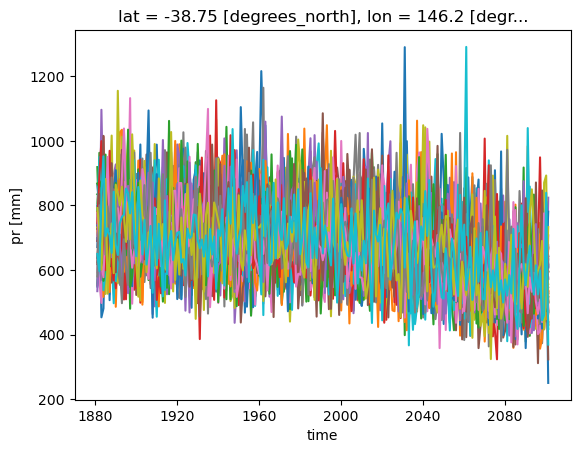

In [45]:
data_ds.sel(lat=-38, lon=145, method='nearest').plot(**plot_kwargs);

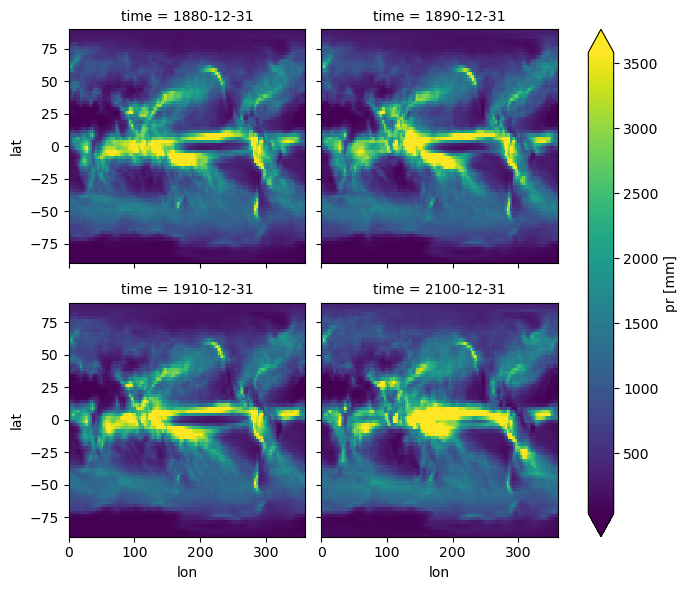

In [46]:
data_ds.isel(time=[0, 10, 30, -1], **member_kwargs).plot(col='time', col_wrap=2, robust=True)

In [47]:
# Calculate statistics
min_val = data_ds.min().values.item()
q25_val = data_ds.reduce(np.nanpercentile, q=25).values.item()
q75_val = data_ds.reduce(np.nanpercentile, q=75).values.item()
max_val = data_ds.max().values.item()

# Display nicely
print(f"Statistics:\n"
      f"Min: {min_val:.2f}\n"
      f"25th Percentile: {q25_val:.2f}\n"
      f"75th Percentile: {q75_val:.2f}\n"
      f"Max: {max_val:.2f}")

Statistics:
Min: 0.15
25th Percentile: 350.93
75th Percentile: 1313.40
Max: 11006.29


In [48]:
len(data_ds.time.values), np.take(data_ds.time.values, [0, 1,2, -3, -2, -1])

(221,
 array(['1880-12-31T00:00:00.000000000', '1881-12-31T00:00:00.000000000',
        '1882-12-31T00:00:00.000000000', '2098-12-31T00:00:00.000000000',
        '2099-12-31T00:00:00.000000000', '2100-12-31T00:00:00.000000000'],
       dtype='datetime64[ns]'))

In [49]:
len(data_ds.time.values), np.take(data_ds.time.values, [0, 1,2, -3, -2, -1])

(221,
 array(['1880-12-31T00:00:00.000000000', '1881-12-31T00:00:00.000000000',
        '1882-12-31T00:00:00.000000000', '2098-12-31T00:00:00.000000000',
        '2099-12-31T00:00:00.000000000', '2100-12-31T00:00:00.000000000'],
       dtype='datetime64[ns]'))

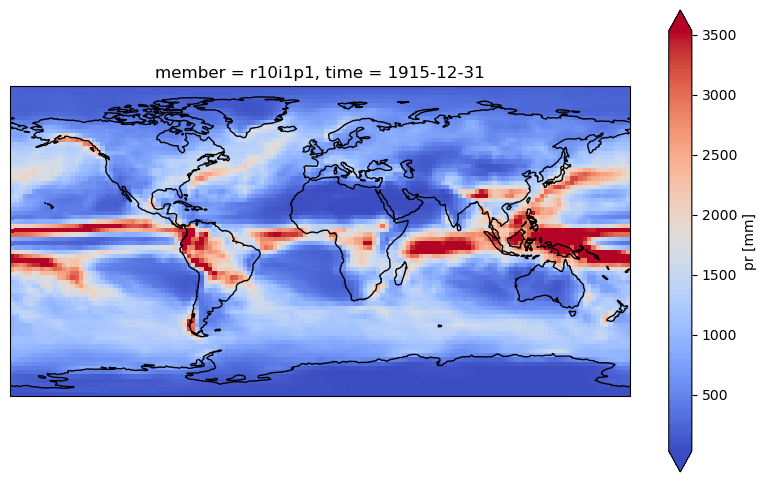

In [50]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
data_ds.isel(time=35, **member_kwargs).plot(ax=ax,robust=True, cmap='coolwarm')
ax.coastlines()
# ax.set_title('Year 2000')

In [51]:
base_period_ds = data_ds.sel(time=slice(str(base_period.start), str(base_period.end)))
base_period_ds

<xarray.DataArray 'pr' (member: 40, lat: 72, lon: 144, time: 30)> Size: 100MB
dask.array<getitem, shape=(40, 72, 144, 30), dtype=float64, chunksize=(1, 18, 144, 30), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member   (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time     (time) datetime64[ns] 240B 1880-12-31 1881-12-31 ... 1909-12-31
Attributes: (1)

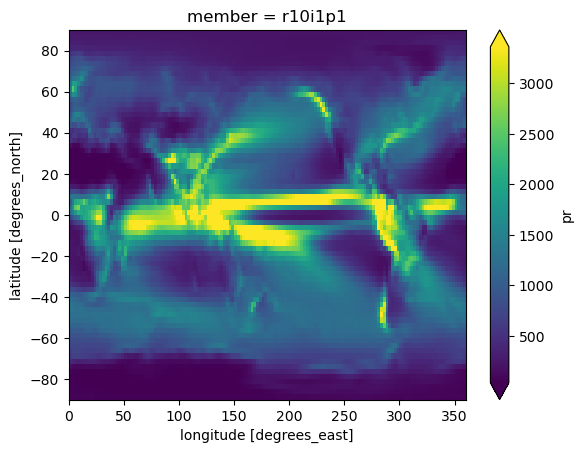

In [52]:
base_period_ds.mean(dim='time').isel(**member_kwargs).plot(robust=True)

In [53]:
# Create a mask that removes any grid celss where there are less than 40 point in the base period
base_period_ds_count = base_period_ds.count(dim='time')
# How many years are needed for 80 percent
percent_80_of_years = 0.8*(base_period.end - base_period.start)
data_availability_mask = xr.where(base_period_ds_count>=percent_80_of_years, 1, 0)
data_availability_mask

<xarray.DataArray 'pr' (member: 40, lat: 72, lon: 144)> Size: 3MB
dask.array<where, shape=(40, 72, 144), dtype=int64, chunksize=(1, 18, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member   (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'

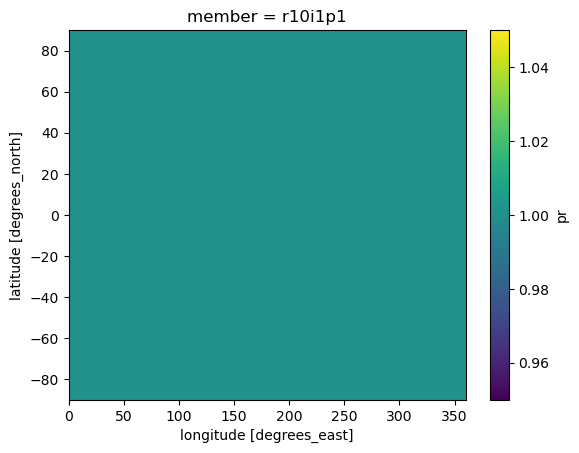

In [54]:
data_availability_mask.isel(**member_kwargs).plot()

In [55]:
# Apply the mask to both the base period and the full dataset
data_ds = data_ds.where(data_availability_mask).persist()
base_period_ds = base_period_ds.where(data_availability_mask)

In [56]:
data_ds

<xarray.DataArray 'pr' (member: 40, lat: 72, lon: 144, time: 221)> Size: 733MB
dask.array<where, shape=(40, 72, 144, 221), dtype=float64, chunksize=(1, 18, 144, 221), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member   (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time     (time) datetime64[ns] 2kB 1880-12-31 1881-12-31 ... 2100-12-31
Attributes: (1)

In [57]:
# Resetting the anomlies to 1850
data_anom_ds = data_ds - base_period_ds.mean(dim='time')
base_period_anom_ds = base_period_ds - base_period_ds.mean(dim='time')

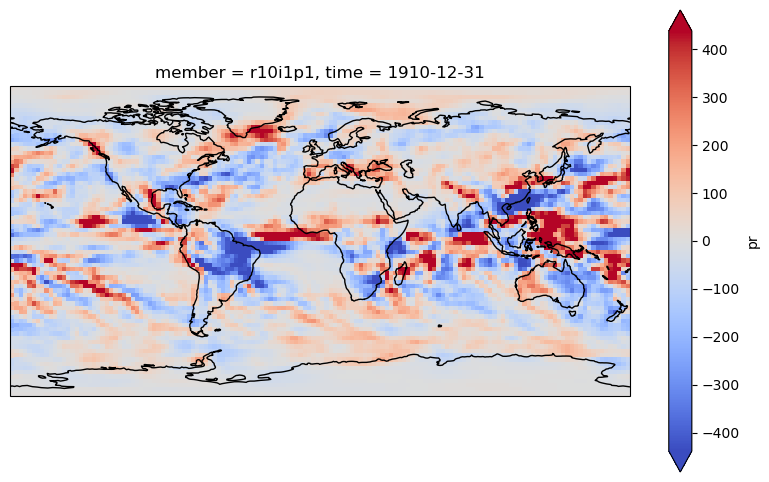

In [58]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
data_anom_ds.isel(time=30, **member_kwargs).plot(ax=ax,robust=True, cmap='coolwarm')
ax.coastlines()
# ax.set_title('Year 2000')

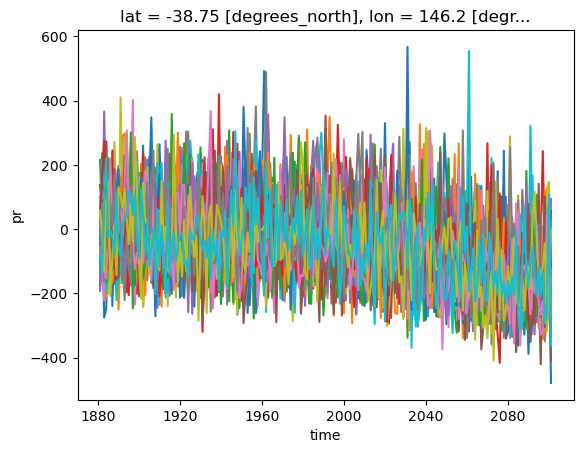

In [59]:
data_anom_ds.sel(lat=-38, lon=145, method='nearest').plot(**plot_kwargs);

In [60]:
data_ds.sel(lat=-38, lon=145, method='nearest').values

array([[866.  , ..., 250.04],
       ...,
       [649.47, ..., 368.81]])

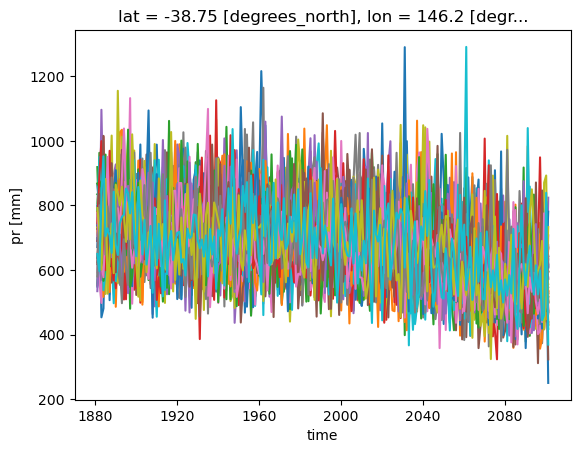

In [61]:
data_ds.sel(lat=-38, lon=145, method='nearest').plot(**plot_kwargs);

<h1 style='color: yellow'> Metric Calculation </h1>

<h2 style='color: cyan'>Dataset set-up </h2>

<ul>
    <li> Scaling client</li>
    <li> Chunking data set</li>
</ul>

In [62]:
windows = np.arange(20, 80, 10)
windows

array([20, 30, 40, 50, 60, 70])

In [63]:
if 'region' in data_ds.coords or exp_type in ('resolution', 'base_period'):
    windows = [30]

In [64]:
# # P-value methods works better with a large cluster.
# # Small chunks with large computation
client.cluster.scale(100);
sleep(7);

In [65]:
lat_lon_sp = {'lat': -34, 'lon': 145, 'method': 'nearest'}

In [66]:
data_anom_ds = data_anom_ds.persist()
base_period_anom_ds = base_period_anom_ds.persist()
data_ds = data_ds.persist()

In [67]:
data_ds

<xarray.DataArray 'pr' (member: 40, lat: 72, lon: 144, time: 221)> Size: 733MB
dask.array<where, shape=(40, 72, 144, 221), dtype=float64, chunksize=(1, 18, 144, 221), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member   (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time     (time) datetime64[ns] 2kB 1880-12-31 1881-12-31 ... 2100-12-31
Attributes: (1)

In [68]:
CHUNKS_FOR_PVALUE_TESTS = chunks
CHUNKS_FOR_PVALUE_TESTS

{'time': -1, 'member': 1, 'lat': 18, 'lon': -1}

In [69]:
window = 30

In [70]:
data_ds_window = (data_ds
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                  .chunk({'window_dim':-1,**CHUNKS_FOR_PVALUE_TESTS})
                  .persist()
                 ) 

base_period_window_ds = (data_ds.sel(time=slice(str(base_period.start), str(base_period.end)))
                         .chunk(CHUNKS_FOR_PVALUE_TESTS)
                         .rename({'time':'window_dim'})
                         .persist()
                        )

In [71]:
wait(data_ds_window);
wait(base_period_window_ds);

In [72]:
data_ds_window

<xarray.DataArray 'pr' (member: 40, lat: 72, lon: 144, time: 221, window_dim: 30)> Size: 22GB
dask.array<rechunk-merge, shape=(40, 72, 144, 221, 30), dtype=float64, chunksize=(1, 18, 144, 221, 30), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member   (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time     (time) datetime64[ns] 2kB 1880-12-31 1881-12-31 ... 2100-12-31
Dimensions without coordinates: window_dim
Attributes: (1)

In [73]:
data_ds_window.chunks

((1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1),
 (18, 18, 18, 18),
 (144,),
 (221,),
 (30,))

In [74]:
base_period_window_ds

<xarray.DataArray 'pr' (member: 40, lat: 72, lon: 144, window_dim: 30)> Size: 100MB
dask.array<getitem, shape=(40, 72, 144, 30), dtype=float64, chunksize=(1, 18, 144, 30), chunktype=numpy.ndarray>
Coordinates:
  * lat         (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon         (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * member      (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * window_dim  (window_dim) datetime64[ns] 240B 1880-12-31 ... 1909-12-31
Attributes: (1)

<h2 style='color: cyan'> Hypothesis Tests </h2>

<ul>
    <li> Scaling client</li>
    <li> Chunking data set</li>
</ul>

### Functions

In [75]:
from scipy.stats import t
import math
from scipy import stats
from numba import njit
from math import sqrt

In [76]:
# The arguements needed for all of the calculations
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

In [77]:
class TTestLookup:
    def __init__(self, t_max=10.0, t_step=0.01, df_max=600):
        """
        Precompute a lookup table of two-sided p-values for Welch's t-test.

        Parameters
        ----------
        t_max : float
            Maximum t-statistic value to cover.
        t_step : float
            Step size for t-statistic grid.
        df_max : int
            Maximum degrees of freedom to cover.
        """
        (self.t_values,
         self.df_values,
         self.ttest_lookup) = self._build_ttest_lookup(t_max, t_step, df_max)

    # ---------------------------
    # Static builders
    # ---------------------------
    @staticmethod
    def _build_ttest_lookup(t_max, t_step, df_max):
        """
        Build grid + lookup for Welch's t-test (two-sided p-values).

        Parameters
        ----------
        t_max : float
            Maximum t-statistic to precompute.
        t_step : float
            Step size along t-axis.
        df_max : int
            Maximum degrees of freedom to precompute.

        Returns
        -------
        t_values : ndarray
            Grid of t-statistic values.
        df_values : ndarray
            Grid of degrees of freedom.
        lookup : 2D ndarray
            Precomputed p-values with shape (len(df_values), len(t_values)).
        """
        t_values = np.arange(0, t_max + t_step, t_step, dtype=np.float32)
        df_values = np.arange(2, df_max + 1, dtype=np.int32)

        df_grid, t_grid = np.meshgrid(df_values, t_values, indexing="ij")
        lookup = 2 * stats.t.sf(t_grid, df_grid).astype(np.float32)

        return t_values, df_values, lookup

    # ---------------------------
    # Static lookup helper
    # ---------------------------
    @staticmethod
    @njit
    def _lookup_t(t_value, df, t_values, df_values, lookup):
        """
        Query Welch’s t-test lookup table.

        Parameters
        ----------
        t_value : float
            Observed t-statistic.
        df : int
            Degrees of freedom.
        t_values, df_values : ndarray
            Grids of precomputed t and df values.
        lookup : ndarray
            Lookup table of p-values.

        Returns
        -------
        pval : float
            Approximated two-sided p-value.
        """
        t_value = abs(t_value)

        if t_value > t_values[-1]:
            return 0.0

        j = np.searchsorted(t_values, t_value)
        if j >= len(t_values):
            j = len(t_values) - 1
        i = np.searchsorted(df_values, df)
        if i >= len(df_values):
            i = len(df_values) - 1

        return lookup[i, j]

    # ---------------------------
    # Public API
    # ---------------------------
    def pval(self, t_value, df):
        """Return p-value for Welch’s t-test from lookup."""
        return self._lookup_t(t_value, df, self.t_values, self.df_values, self.ttest_lookup)


In [78]:
    # n1, n2 = len(arr1), len(arr2)
    # mean1, mean2 = arr1.mean(), arr2.mean()
    # var1, var2 = arr1.var(ddof=1), arr2.var(ddof=1)

    # # Standard error
    # se = np.sqrt(var1/n1 + var2/n2)

    # # Test statistic
    # t_stat = (mean1 - mean2) / se

In [79]:
@njit(inline='always')
def ttest_statistic(arr1, arr2):
    n1, n2 = len(arr1), len(arr2)

    mean1 = np.mean(arr1)
    mean2 = np.mean(arr2)

    # Numba only supports population variance, so compute sample variance manually
    var1 = np.sum((arr1 - mean1) ** 2) / (n1 - 1)
    var2 = np.sum((arr2 - mean2) ** 2) / (n2 - 1)

    se = np.sqrt(var1 / n1 + var2 / n2)
    t_stat = (mean1 - mean2) / se
    return t_stat

@njit
def ttest_statistic_and_deg_free(arr1, arr2):
    n1, n2 = len(arr1), len(arr2)

    mean1 = np.mean(arr1)
    mean2 = np.mean(arr2)

    # Numba only supports population variance, so compute sample variance manually
    var1 = np.sum((arr1 - mean1) ** 2) / (n1 - 1)
    var2 = np.sum((arr2 - mean2) ** 2) / (n2 - 1)

    se = np.sqrt(var1 / n1 + var2 / n2)
    t_stat = (mean1 - mean2) / se

    # Effective degrees of freedom (Satterthwaite approximation)
    deg_free = (var1/n1 + var2/n2)**2 / (
        (var1/n1)**2/(n1-1) + (var2/n2)**2/(n2-1)
    )
    
    return t_stat, deg_free


def welch_ttest(arr1, arr2, use_lookup=True):
    """
    Welch's t-test (robust to unequal variances).
    Optionally uses a precomputed lookup table for p-values.

    Parameters
    ----------
    arr1, arr2 : array_like
        Input 1D arrays of sample data.
    use_lookup : bool, optional
        If True, use a lookup table instead of scipy.stats.t.cdf.
    t_vals, df_vals, lookup : arrays, optional
        Precomputed t values, degrees of freedom values, and lookup table grid.
        Required if use_lookup=True.

    Returns
    -------
    t_stat : float
        Welch's t statistic.
    pval : float
        Two-sided p-value.
    """

    t_stat, deg_free = ttest_statistic_and_deg_free(arr1, arr2)



    if use_lookup:
        pval = ttest_lookup.pval(t_stat, deg_free)
    else:
        pval = 2 * stats.t.sf(abs(t_stat), deg_free)
        
    return t_stat, pval

def ks_statistic(arr1, arr2):
    """
    Compute the Kolmogorov–Smirnov (KS) statistic for two 1D samples.

    Parameters
    ----------
    arr1, arr2 : array-like
        Input samples.

    Returns
    -------
    d_stat : float
        The KS statistic, i.e. the maximum absolute difference
        between the two empirical cumulative distribution functions.
    """
    data1, data2 = np.sort(arr1), np.sort(arr2)
    n1, n2 = len(data1), len(data2)

    # Build empirical CDFs
    combined = np.concatenate([data1, data2])
    cdf1 = np.searchsorted(data1, combined, side="right") / n1
    cdf2 = np.searchsorted(data2, combined, side="right") / n2

    return np.max(np.abs(cdf1 - cdf2))


@njit(inline='always')
def ks_statistic_numba(data1, data2):
    data1 = np.sort(data1)
    data2 = np.sort(data2)
    n1, n2 = len(data1), len(data2)
    combined = np.empty(n1 + n2)
    combined[:n1] = data1
    combined[n1:] = data2
    combined.sort()

    d = 0.0
    j1 = j2 = 0
    for x in combined:
        while j1 < n1 and data1[j1] <= x:
            j1 += 1
        while j2 < n2 and data2[j2] <= x:
            j2 += 1
        cdf1 = j1 / n1
        cdf2 = j2 / n2
        diff = abs(cdf1 - cdf2)
        if diff > d:
            d = diff
    return d

def ks_test(arr1, arr2, n_terms=100):
    """
    Two-sample Kolmogorov–Smirnov test (asymptotic p-value).
    Uses the series expansion, which matches SciPy's outputs well at n~50,
    with a fix for the 0 vs 1 mismatch.
    """
    n1, n2 = len(arr1), len(arr2)

    # KS statistic
    d_stat = ks_statistic_numba(arr1, arr2)

    # Effective sample size
    n_eff = n1 * n2 / (n1 + n2)
    x = (np.sqrt(n_eff) + 0.12 + 0.11/np.sqrt(n_eff)) * d_stat

    # Asymptotic series expansion
    j = np.arange(1, n_terms+1)
    terms = (-1)**(j-1) * np.exp(-2 * (x**2) * (j**2))
    pval = 2 * np.sum(terms)

    # Clamp and handle under/overflow like SciPy
    if pval <= 0.0:
        pval = 1.0
    elif pval >= 1.0:
        pval = 0.0

    return d_stat, pval

In [80]:
def fast_mannwhitney(arr1, arr2, alternative="two-sided"):
    """
    Mann–Whitney U test (Wilcoxon rank-sum) using NumPy only.
    Asymptotic normal approximation for p-value.

    Parameters
    ----------
    arr1, arr2 : 1D arrays
        Input samples.
    alternative : {"two-sided", "less", "greater"}
        Alternative hypothesis.

    Returns
    -------
    u_stat : float
        Mann–Whitney U statistic (for arr1).
    pval : float
        p-value (approximate, large-sample normal).
    """
    n1, n2 = len(arr1), len(arr2)

    # rank all values together
    all_data = np.concatenate([arr1, arr2])
    ranks = np.empty_like(all_data, dtype=float)
    order = np.argsort(all_data)
    ranks[order] = np.arange(1, len(all_data)+1)

    # average ranks for ties
    _, inv, counts = np.unique(all_data[order], return_inverse=True, return_counts=True)
    tie_ranks = np.bincount(inv, weights=np.arange(1, len(all_data)+1)) / counts
    ranks[order] = tie_ranks[inv]

    # sum of ranks for arr1
    r1 = ranks[:n1].sum()

    # Mann–Whitney U statistic
    u1 = r1 - n1*(n1+1)/2
    u2 = n1*n2 - u1
    u_stat = min(u1, u2)

    # mean and variance under null
    mean_u = n1*n2 / 2
    tie_corr = (np.sum(counts**3 - counts) / (12*(n1+n2)*(n1+n2-1))) if np.any(counts > 1) else 0
    var_u = n1*n2*(n1+n2+1)/12 - n1*n2/(n1+n2)*(tie_corr*(n1+n2-1))
    sd_u = sqrt(var_u)

    # z-score with continuity correction
    z = (u_stat - mean_u + 0.5*np.sign(mean_u - u_stat)) / sd_u

    # p-value
    if alternative == "two-sided":
        pval = 2 * stats.norm.sf(abs(z))
    elif alternative == "greater":
        pval = stats.norm.sf(z)
    elif alternative == "less":
        pval = stats.norm.cdf(z)
    else:
        raise ValueError("alternative must be 'two-sided', 'less', or 'greater'")

    return u_stat, pval


In [81]:
def remove_nans(arr1, arr2):
    return arr1[np.isfinite(arr1)], arr2[np.isfinite(arr2)]

In [82]:
import numpy as np
from numba import njit

# --- Numba kernels ---

@njit(inline='always')
def _block_resample_numba(series, starts, block_size, length):
    """
    Numba-friendly block resampling.
    Takes a 1D array and start indices, and stitches blocks together.
    """
    resampled = np.empty(length, dtype=series.dtype)
    pos = 0
    for s in starts:
        for j in range(block_size):
            if pos >= length:
                break
            resampled[pos] = series[s + j]
            pos += 1
    return resampled


@njit
def _bootstrap_loop(arr1, arr2, combined, func, block_size, n_boot, starts_x, starts_y):
    """
    Inner bootstrap loop, compiled with Numba.
    """
    n1, n2 = len(arr1), len(arr2)
    boot_stats = np.empty(n_boot)

    for i in range(n_boot):
        x_star = _block_resample_numba(combined, starts_x[i], block_size, n1)
        y_star = _block_resample_numba(combined, starts_y[i], block_size, n2)
        boot_stats[i] = func(x_star, y_star)

    return boot_stats


def block_bootstrap_statistic(arr1, arr2, func, block_size=5, n_boot=500, rng=None):
    """
    Block bootstrap version of a two-sample statistic.

    Parameters
    ----------
    arr1, arr2 : array-like
        Input samples. Must be the same length (n1 = n2).
    func : callable
        Numba-compiled test statistic function.
    block_size : int
        Length of resampling blocks.
    n_boot : int
        Number of bootstrap replicates.
    rng : int or np.random.Generator, optional
        Random seed or Generator for reproducibility.

    Returns
    -------
    stat_obs : float
        Observed statistic.
    pval : float
        Bootstrap p-value: fraction of bootstrap replicates ≥ observed.
    """
    rng = np.random.default_rng(rng)
    n1, n2 = len(arr1), len(arr2)
    # if n1 != n2:
    #     raise ValueError("Exact test requires equal sample sizes")

    # Observed statistic
    stat_obs = func(arr1, arr2)

    combined = np.concatenate([arr1, arr2])

    # Pre-generate block starts for each bootstrap
    # Number of blocks will be the length divided by the block_size
    n_blocks_x = int(np.ceil(n1 / block_size))
    n_blocks_y = int(np.ceil(n2 / block_size))

    # Shape will be a square matrix. 
    starts_x = rng.integers(0, len(combined) - block_size + 1, size=(n_boot, n_blocks_x))
    starts_y = rng.integers(0, len(combined) - block_size + 1, size=(n_boot, n_blocks_y))

    # Call Numba core
    boot_stats = _bootstrap_loop(arr1, arr2, combined, func, block_size, n_boot, starts_x, starts_y)

    # Bootstrap p-value
    pval = np.mean(boot_stats >= stat_obs)
    return stat_obs, pval


In [83]:
# def fdr_bh_thresh_numpy(pvals, alpha=0.05):
#     """
#     Benjamini–Hochberg FDR correction for 1D array of p-values.
#     Returns the threshold value only.
#     """
#     pvals = np.ravel(pvals)
#     n = len(pvals)
#     sort_idx = np.argsort(pvals)
#     sorted_p = pvals[sort_idx]

#     thresholds = alpha * (np.arange(1, n+1) / n)
#     below = sorted_p <= thresholds
#     if not np.any(below):
#         return 0.0

#     k = np.max(np.where(below)[0])
#     return sorted_p[k]


# def fdr_bh_thresh_xr(da, alpha=0.05, space_dims=("lat", "lon")):
#     """
#     Benjamini–Hochberg FDR threshold across spatial dimensions,
#     applied independently for each time step.

#     Parameters
#     ----------
#     da : xr.DataArray
#         P-values with dims including time + space.
#     alpha : float
#         FDR control level.
#     space_dims : tuple of str
#         Dimensions to apply FDR across (default: ("lat","lon")).

#     Returns
#     -------
#     pval_thresh : xr.DataArray (float)
#         Threshold p-value at each time step, shape (time,).
#     """
#     thresh = xr.apply_ufunc(
#         fdr_bh_thresh_numpy,
#         da,
#         alpha,
#         input_core_dims=[list(space_dims), []],
#         output_core_dims=[[]],
#         vectorize=True,
#         dask="parallelized",
#         output_dtypes=[float],
#     )
#     return thresh


In [84]:
# def run_windowed_test(stat_func, window, data_ds=None, base_period=None,
#                       data_ds_window=None, base_period_window_ds=None):
#     """
#     Run hypothesis test between rolling future and rolling base-period windows.

#     Parameters
#     ----------
#     stat_func : function
#         Hypothesis test with signature (arr1, arr2, **kwargs) -> (stat, pval).
#     data_ds : xr.DataArray
#         Input time series dataset with dimension 'time'.
#     base_period : slice
#         Base period as a slice, e.g. slice('1850', '1900').
#     win : int
#         Rolling window length.

#     Returns
#     -------
#     xr.Dataset with stat and pval
#     """
#     # When you apply .rolling(time=window, ...), xarray creates a rolling view:
#     #   - At each time point, it knows about the "window" of neighbouring values,
#     #     but these values are not yet exposed as a real dimension.
#     #
#     # .construct('window_dim') turns those hidden windows into an explicit new axis:
#     #   - Your data shape goes from (time, ...) → (time, window_dim, ...).
#     #   - For each center time, you now have the full set of values in that window
#     #     stored along the new "window_dim".
#     #
#     # This is essential for later statistical comparisons:
#     #   - By renaming the base period's 'time' dimension → 'window_dim',
#     #     the reference years and the rolling windows now share the same axis name.
#     #   - That way, xarray can align them and apply vectorised tests across all windows.
#     #
#     # Without .construct('window_dim'), you would only have a rolling object,
#     # not an explicit dimension you can broadcast or align with other datasets.

#     logger.info(f"\nRunning windowed test with window={window}")


#     if data_ds_window is None:
#         logger.info("Building rolling window view of data_ds")
#         data_ds_window = (
#             data_ds
#             .rolling(time=window, center=True, min_periods=window)
#             .construct("window_dim")
#             .chunk({"window_dim": -1, **CHUNKS_FOR_PVALUE_TESTS})
#             .persist()
#         )
#         wait(data_ds_window)
    
#     if base_period_window_ds is None:
#         if base_period:
#             logger.info(f"\nUsing explicit base_period: {base_period.start} → {base_period.end}")
#             base_period_window_ds = data_ds.sel(time=slice(str(base_period.start), str(base_period.end)))
#         else:
#             logger.info(f"\nNo base_period provided, using first {window} timesteps as default")
#             base_period_window_ds = data_ds.isel(time=slice(0, window))
        
#         base_period_window_ds = (
#             base_period_window_ds
#             .chunk(CHUNKS_FOR_PVALUE_TESTS)
#             .rename({"time": "window_dim"})
#             .persist()
#         )
#         wait(base_period_window_ds)

#     # Force Dask to align chunk boundaries, not just chunk patterns
#     data_ds_window, base_period_window_ds = xr.align(
#         data_ds_window, base_period_window_ds, join="exact"
#     )

#     logger.info((
#         f'\nbase period info\nlenght={len(base_period_window_ds.window_dim.values)}\n'
#         f'time: {base_period_window_ds.window_dim.dt.year.values.tolist()}'
#         ))
    

#     logger.debug(f"\ndata_ds_window: shape={data_ds_window.shape}, dims={data_ds_window.dims}")
#     logger.debug(f"\nbase_period_window_ds : shape={base_period_window_ds.shape}, dims={base_period_window_ds.dims}")


#     # --- Precompile your numba test once (e.g., for t or KS test) ---
#     _dummy = np.random.rand(10)
#     _ = stat_func(_dummy, _dummy)
    
#     rolling_window_kwargs = dict(
#         input_core_dims=[["window_dim"], ["window_dim"]],
#         exclude_dims={"window_dim"},
#         dask="parallelized",
#         vectorize=True,
#         output_dtypes=[float, float],
#         output_core_dims=[[], []],
#     )

#     logger.debug("Applying hypothesis test with xr.apply_ufunc")
#     stat, pval = xr.apply_ufunc(
#         stat_func,
#         data_ds_window,
#         base_period_window_ds,
#         **rolling_window_kwargs,
#     )

#     stat_pval_ds = xr.Dataset({"stat": stat, "pval": pval}).persist()
#     wait(stat_pval_ds)
#     logger.info("Hypothesis test complete, returning Dataset")

#     return stat_pval_ds

In [284]:
def run_windowed_test(stat_func, window, data_ds=None, base_period=None,
                      data_ds_window=None, base_period_window_ds=None):
    """
    Run hypothesis test between rolling future and base-period windows.

    Parameters
    ----------
    stat_func : function
        Hypothesis test with signature (arr1, arr2) -> (stat, pval).
    data_ds : xr.DataArray
        Input dataset with dimension 'time'.
    base_period : slice
        Base period as slice('1850', '1900').
    window : int
        Rolling window length.

    Returns
    -------
    xr.Dataset
        Contains 'stat' and 'pval' fields.
    """
    logger.info(f"\nRunning windowed test with window={window}")

    chunks_common = {"window_dim": -1, **CHUNKS_FOR_PVALUE_TESTS}

    # --- Build rolling data view if not provided ---
    if data_ds_window is None:
        logger.info("Building rolling window view of data_ds")
        data_ds_window = (
            data_ds
            .rolling(time=window, center=True, min_periods=window)
            .construct("window_dim")
            .chunk(chunks_common)
        )

    # --- Build base period window dataset if not provided ---
    if base_period_window_ds is None:
        if base_period:
            logger.info(f"Using explicit base_period: {base_period.start} → {base_period.end}")
            base_period_window_ds = data_ds.sel(time=slice(str(base_period.start), str(base_period.end)))
        else:
            logger.info(f"No base_period provided — using first {window} timesteps as default")
            base_period_window_ds = data_ds.isel(time=slice(0, window))

        base_period_window_ds = (
            base_period_window_ds
            .rename({"time": "window_dim"})
            .chunk(chunks_common)
        )

    # --- Align coordinates and chunk boundaries before persist ---
    data_ds_window, base_period_window_ds = xr.align(
        data_ds_window, base_period_window_ds, join="exact"
    )
    # data_ds_window = data_ds_window.chunk(base_period_window_ds.chunks)

    # Persist aligned data
    data_ds_window = data_ds_window.persist()
    base_period_window_ds = base_period_window_ds.persist()
    wait(data_ds_window)
    wait(base_period_window_ds)

    # Log base period summary safely
    n_win = len(base_period_window_ds.window_dim)
    first_year = str(base_period_window_ds.window_dim.dt.year.values[0])
    last_year = str(base_period_window_ds.window_dim.dt.year.values[-1])
    logger.info(f"\nBase period length={n_win}, range={first_year}–{last_year}")

    # --- Precompile Numba kernel once ---
    _ = stat_func(np.random.rand(10), np.random.rand(10))

    # --- Apply hypothesis test across all windows ---
    rolling_window_kwargs = dict(
        input_core_dims=[["window_dim"], ["window_dim"]],
        exclude_dims={"window_dim"},
        dask="parallelized",
        vectorize=True,
        output_dtypes=[float, float],
        output_core_dims=[[], []],
    )

    logger.debug("Applying hypothesis test with xr.apply_ufunc")
    stat, pval = xr.apply_ufunc(
        stat_func,
        data_ds_window,
        base_period_window_ds,
        **rolling_window_kwargs,
    )

    result = xr.Dataset({"stat": stat, "pval": pval}).persist()
    wait(result)
    logger.info("Hypothesis test complete — returning dataset")

    return result


In [86]:
block_bootstrap_ks = partial(block_bootstrap_statistic, func=ks_statistic_numba)
block_bootstrap_ttest = partial(block_bootstrap_statistic, func=ttest_statistic)

### Function tests

In [87]:
member_kwargs

{'member': 0}

In [88]:
samp_data = data_ds.sel(lat=-39, lon=145, method='nearest').isel(**member_kwargs)
arr1 = samp_data.values[:30]
arr2 = samp_data.values[90:90+30]

In [89]:
n1 = len(arr1)
block_size = 5

In [90]:
n_blocks_x = int(np.ceil(n1 / block_size))

In [91]:
combined = np.concatenate([arr1, arr2])

In [92]:
rng = np.random.default_rng(None)
starts_x = rng.integers(0, len(combined) - block_size + 1, size=(n_blocks_x))

In [93]:
starts_x

array([39, 21, 44,  8, 27, 30])

In [94]:
x_star = _block_resample_numba(combined, starts_x, block_size, n1)

In [95]:
len(x_star), len(arr1)

(30, 30)

In [96]:
x_star_list = []
for i in range(10):
    starts_x = rng.integers(0, len(combined) - block_size + 1, size=(n_blocks_x))
    x_star = _block_resample_numba(combined, starts_x, block_size, n1)
    x_star_list.append(x_star)

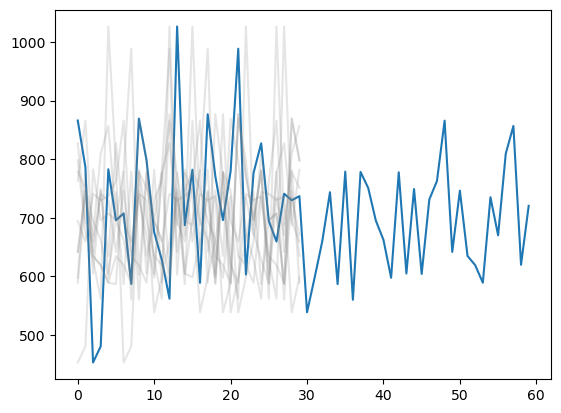

In [97]:
plt.plot(combined)
# plt.plot(x_star)
for xs in x_star_list:
    plt.plot(xs, color='grey', alpha=0.2)

In [98]:
# Observed statistic (with exact pval)
d_obs, _ = ks_test(arr1, arr2)
d_obs

0.2666666666666667

In [99]:
n1, n2 = len(arr1), len(arr2)

In [100]:
_block_resample_numba?

Signature:       _block_resample_numba(series, starts, block_size, length)
Call signature:  _block_resample_numba(*args, **kwargs)
Type:            CPUDispatcher
String form:     CPUDispatcher(<function _block_resample_numba at 0x1461def0e4d0>)
File:            /jobfs/152932399.gadi-pbs/ipykernel_879111/2357241154.py
Docstring:      
Numba-friendly block resampling.
Takes a 1D array and start indices, and stitches blocks together.
Class docstring:
Implementation of user-facing dispatcher objects (i.e. created using
the @jit decorator).
This is an abstract base class. Subclasses should define the targetdescr
class attribute.
Init docstring: 
Parameters
----------
py_func: function object to be compiled
locals: dict, optional
    Mapping of local variable names to Numba types.  Used to override
    the types deduced by the type inference engine.
targetoptions: dict, optional
    Target-specific config options.
pipeline_class: type numba.compiler.CompilerBase
    The compiler pipeline typ

In [101]:
from scipy.stats import ttest_ind, ks_2samp, mannwhitneyu

In [102]:
n_boot = 200
block_size = 5
boot_stats = np.empty(n_boot)
boot_stats_numba = np.empty(n_boot)
boot_stats_scipy = np.empty(n_boot)


combined = np.concatenate([arr1, arr2])

for i in range(n_boot):
    starts_x = rng.integers(0, len(combined) - block_size + 1, size=(n_blocks_x))
    starts_y = rng.integers(0, len(combined) - block_size + 1, size=(n_blocks_x))
    
    x_star = _block_resample_numba(combined, starts_x, block_size, n1)
    y_star = _block_resample_numba(combined, starts_y, block_size, n2)
    
    boot_stats[i] = ks_statistic(x_star, y_star)
    boot_stats_numba[i] = ks_statistic_numba(x_star, y_star)
    boot_stats_scipy[i] = ks_2samp(x_star, y_star).statistic

In [103]:
boot_stats_numba - boot_stats_scipy

array([-0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., -0.,  0.,  0.,  0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0.,
        0., -0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,
        0.,  0.,  0.,  0., -0.,  0.,  0.,  0., -0., -0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0., -0., -0.,  0.,  0.,
        0., -0., -0.,  0.,  0., -0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., -0., -0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,
        0., -0.,  0.,  0., -0.,  0.,  0.,  0.,  0., -0., -0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0.,  0., -0.,
        0.,  0.,  0.,  0.,  0., -0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,
        0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., -0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0., -0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0

In [104]:
%%timeit
ks_statistic(x_star, y_star)

18 μs ± 669 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [105]:
%%timeit
ks_statistic_numba(x_star, y_star)

2.25 μs ± 39 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [106]:
pval = np.mean(boot_stats >= d_obs)
pval

0.095

In [107]:
ks_test(arr1, arr2)

(0.2666666666666667, 0.20032515093915468)

In [108]:
ttest_lookup = TTestLookup(t_max=10.0, t_step=0.01, df_max=600)

In [109]:
# --- Simple tests ---
print("Case 1:", "lookup =", ttest_lookup.pval(0.5, 5),
      "direct =", 2 * stats.t.sf(abs(0.5), 5))

print("Case 2:", "lookup =", ttest_lookup.pval(2.5, 10),
      "direct =", 2 * stats.t.sf(abs(2.5), 10))

print("Case 3:", "lookup =", ttest_lookup.pval(5.0, 50),
      "direct =", 2 * stats.t.sf(abs(5.0), 50))

print("Case 4:", "lookup =", ttest_lookup.pval(7.5, 100),
      "direct =", 2 * stats.t.sf(abs(7.5), 100))

print("Case 5:", "lookup =", ttest_lookup.pval(10.0, 300),
      "direct =", 2 * stats.t.sf(abs(10.0), 300))

Case 1: lookup = 0.6382988691329956 direct = 0.638298871640929
Case 2: lookup = 0.03144684433937073 direct = 0.031446844236608776
Case 3: lookup = 7.433212431351421e-06 direct = 7.433212247232564e-06
Case 4: lookup = 2.6572398795221552e-11 direct = 2.657239926372068e-11
Case 5: lookup = 1.6558627517882952e-20 direct = 1.6558627351112513e-20


In [110]:
ttest_lookup.pval(0.5, 5)

0.6382988691329956

In [111]:
%%timeit
ttest_lookup.pval(0.5, 5)

383 ns ± 4.29 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [112]:
%%timeit
stats.t.sf(abs(0.5), 5)

52.1 μs ± 218 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [113]:
# ---------------------------
# Demo with toy arrays
# ---------------------------
x = np.array([1, 2, 3, 4, 5])
y = np.array([2, 3, 4, 5, 6])

print("Welch t-test:", welch_ttest(x, y))
print("KS test:", ks_test(x, y))
# print("Block bootstrap t-test:", block_bootstrap_ttest(x, y, block_size=2, n_boot=200, rng=0))
# print("Block bootstrap KS test:", block_bootstrap_ks(x, y, block_size=2, n_boot=200, rng=0))

Welch t-test: (-1.0, 0.3465934991836548)
KS test: (0.20000000000000007, 0.9996217060535831)


In [114]:

# --- Setup ---
rng = np.random.default_rng(0)
a = rng.normal(0, 1, 50)  # baseline sample

factors = [0.2, 0.5, 0.75, 1.0, 1.25, 2.0]
shifts  = [0.0, 0.2, 0.5, 1.0, 1.5, 2, 2.5]

# --- Variance change ---
fast_ttest_var = [welch_ttest(a, a * f)[-1] for f in factors]
scipy_ttest_var = [ttest_ind(a, a * f, equal_var=False).pvalue for f in factors]
np.testing.assert_allclose(fast_ttest_var, scipy_ttest_var, atol=0.01)

fast_ks_var = [ks_test(a, a * f)[-1] for f in factors]
scipy_ks_var = [ks_2samp(a, a * f).pvalue for f in factors]
np.testing.assert_allclose(fast_ks_var, scipy_ks_var, atol=0.05)

# --- Mean change ---
fast_ttest_mean = [welch_ttest(a, a + s)[-1] for s in shifts]
scipy_ttest_mean = [ttest_ind(a, a + s, equal_var=False).pvalue for s in shifts]
np.testing.assert_allclose(fast_ttest_mean, scipy_ttest_mean, atol=0.01)

fast_ks_mean = [ks_test(a, a + s)[-1] for s in shifts]
scipy_ks_mean = [ks_2samp(a, a + s).pvalue for s in shifts]
np.testing.assert_allclose(fast_ks_mean, scipy_ks_mean, atol=0.05)

# --- Mean + variance change ---
fast_ttest_both = [welch_ttest(a, (a * f) + s)[-1] for f, s in zip(factors, shifts*2)]
scipy_ttest_both = [ttest_ind(a, (a * f) + s, equal_var=False).pvalue for f, s in zip(factors, shifts*2)]
np.testing.assert_allclose(fast_ttest_both, scipy_ttest_both, atol=0.01)

fast_ks_both = [ks_test(a, (a * f) + s)[-1] for f, s in zip(factors, shifts*2)]
scipy_ks_both = [ks_2samp(a, (a * f) + s).pvalue for f, s in zip(factors, shifts*2)]
np.testing.assert_allclose(fast_ks_both, scipy_ks_both, atol=0.05)

In [115]:
# --- Mann–Whitney U tests ---
# Variance change
fast_mwu_var = [fast_mannwhitney(a, a * f)[-1] for f in factors]
scipy_mwu_var = [mannwhitneyu(a, a * f, alternative="two-sided").pvalue for f in factors]
np.testing.assert_allclose(fast_mwu_var, scipy_mwu_var, atol=0.05)

# Mean change
fast_mwu_mean = [fast_mannwhitney(a, a + s)[-1] for s in shifts]
scipy_mwu_mean = [mannwhitneyu(a, a + s, alternative="two-sided").pvalue for s in shifts]
np.testing.assert_allclose(fast_mwu_mean, scipy_mwu_mean, atol=0.05)

# Mean + variance change
fast_mwu_both = [fast_mannwhitney(a, (a * f) + s)[-1] for f, s in zip(factors, shifts*2)]
scipy_mwu_both = [mannwhitneyu(a, (a * f) + s, alternative="two-sided").pvalue for f, s in zip(factors, shifts*2)]
np.testing.assert_allclose(fast_mwu_both, scipy_mwu_both, atol=0.05)

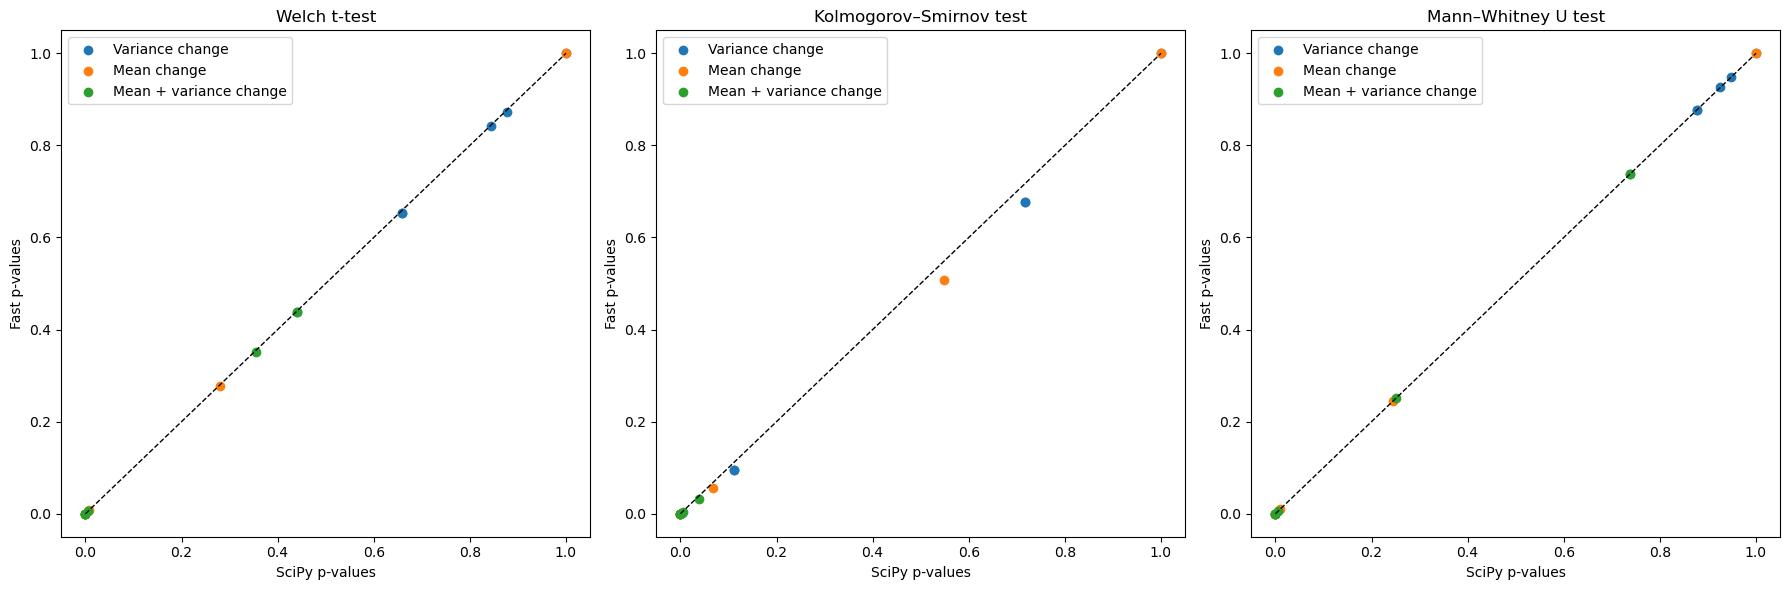

In [116]:
# --- Scatter plots ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Colours for each test type
colors = {"var": "tab:blue", "mean": "tab:orange", "both": "tab:green"}

# T-test scatter
axes[0].scatter(scipy_ttest_var, fast_ttest_var, c=colors["var"], label="Variance change")
axes[0].scatter(scipy_ttest_mean, fast_ttest_mean, c=colors["mean"], label="Mean change")
axes[0].scatter(scipy_ttest_both, fast_ttest_both, c=colors["both"], label="Mean + variance change")
axes[0].plot([0, 1], [0, 1], "k--", lw=1)
axes[0].set_xlabel("SciPy p-values")
axes[0].set_ylabel("Fast p-values")
axes[0].set_title("Welch t-test")
axes[0].legend()

# KS test scatter
axes[1].scatter(scipy_ks_var, fast_ks_var, c=colors["var"], label="Variance change")
axes[1].scatter(scipy_ks_mean, fast_ks_mean, c=colors["mean"], label="Mean change")
axes[1].scatter(scipy_ks_both, fast_ks_both, c=colors["both"], label="Mean + variance change")
axes[1].plot([0, 1], [0, 1], "k--", lw=1)
axes[1].set_xlabel("SciPy p-values")
axes[1].set_ylabel("Fast p-values")
axes[1].set_title("Kolmogorov–Smirnov test")
axes[1].legend()

# Mann–Whitney U test scatter
axes[2].scatter(scipy_mwu_var, fast_mwu_var, c=colors["var"], label="Variance change")
axes[2].scatter(scipy_mwu_mean, fast_mwu_mean, c=colors["mean"], label="Mean change")
axes[2].scatter(scipy_mwu_both, fast_mwu_both, c=colors["both"], label="Mean + variance change")
axes[2].plot([0, 1], [0, 1], "k--", lw=1)
axes[2].set_xlabel("SciPy p-values")
axes[2].set_ylabel("Fast p-values")
axes[2].set_title("Mann–Whitney U test")
axes[2].legend()

plt.tight_layout()



T-test (same distribution):
  Fast  -> stat = 1.0416, p = 0.2944
  SciPy -> stat = 1.0416, p = 0.2982

T-test (different mean):
  Fast  -> stat = -4.5474, p = 0.0000
  SciPy -> stat = -4.5474, p = 0.0000

KS test (same distribution):
  Fast  -> stat = 0.1050, p = 0.2078
  SciPy -> stat = 0.1050, p = 0.2205

KS test (different mean):
  Fast  -> stat = 0.1950, p = 0.0008
  SciPy -> stat = 0.1950, p = 0.0010

KS test (different shape):
  Fast  -> stat = 0.1350, p = 0.0475
  SciPy -> stat = 0.1350, p = 0.0521

Mann–Whitney U (same distribution):
  Fast  -> stat = 18398.0000, p = 0.1660
  SciPy -> stat = 21602.0000, p = 0.1660

Mann–Whitney U (different mean):
  Fast  -> stat = 15158.0000, p = 0.0000
  SciPy -> stat = 15158.0000, p = 0.0000

Mann–Whitney U (different shape):
  Fast  -> stat = 18694.0000, p = 0.2588
  SciPy -> stat = 18694.0000, p = 0.2588


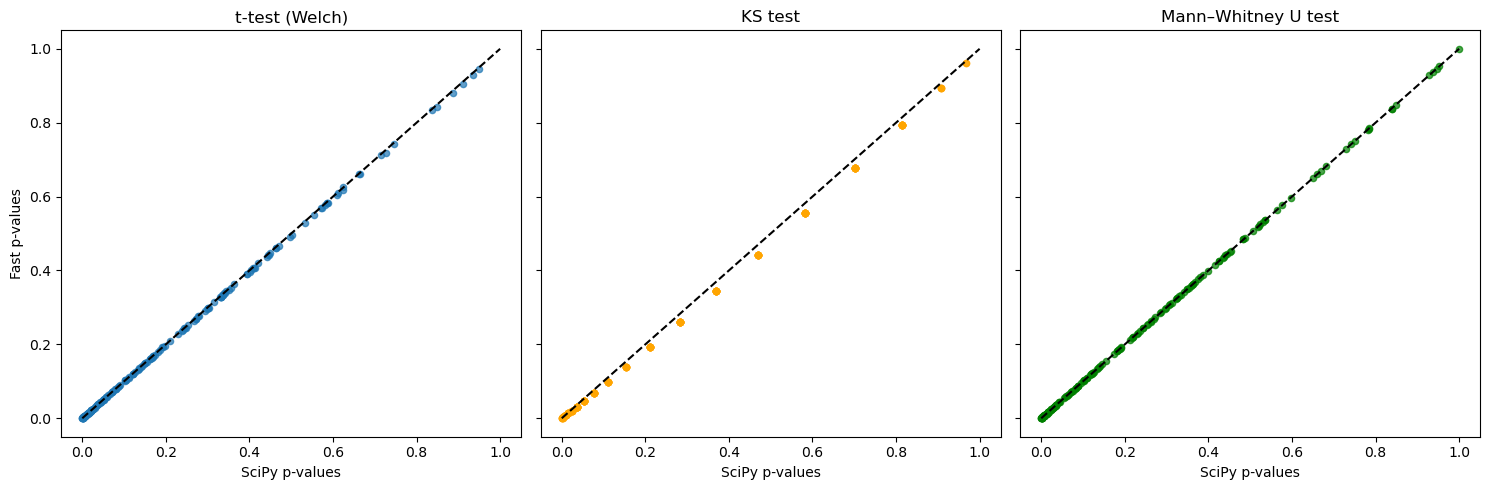

In [117]:
# ---------------------------
# Generate test data
# ---------------------------
rng = np.random.default_rng(0)

x1 = rng.normal(0, 1, 200)
x2 = rng.normal(0, 1, 200)       # same distribution
y1 = rng.normal(0, 1, 200)
y2 = rng.normal(0.5, 1, 200)     # different mean
z1 = rng.normal(0, 1, 200)
z2 = rng.laplace(0, 1, 200)      # different shape

# ---------------------------
# Print comparisons
# ---------------------------
def compare_ttests(a, b, name=""):
    stat_fast, p_fast = welch_ttest(a, b)
    res_scipy = ttest_ind(a, b, equal_var=False)  # Welch
    print(f"\nT-test ({name}):")
    print(f"  Fast  -> stat = {stat_fast:.4f}, p = {p_fast:.4f}")
    print(f"  SciPy -> stat = {res_scipy.statistic:.4f}, p = {res_scipy.pvalue:.4f}")

def compare_kstest(a, b, name=""):
    stat_fast, p_fast = ks_test(a, b)
    res_scipy = ks_2samp(a, b)
    print(f"\nKS test ({name}):")
    print(f"  Fast  -> stat = {stat_fast:.4f}, p = {p_fast:.4f}")
    print(f"  SciPy -> stat = {res_scipy.statistic:.4f}, p = {res_scipy.pvalue:.4f}")

def compare_mwu(a, b, name=""):
    stat_fast, p_fast = fast_mannwhitney(a, b)
    res_scipy = mannwhitneyu(a, b, alternative="two-sided")
    print(f"\nMann–Whitney U ({name}):")
    print(f"  Fast  -> stat = {stat_fast:.4f}, p = {p_fast:.4f}")
    print(f"  SciPy -> stat = {res_scipy.statistic:.4f}, p = {res_scipy.pvalue:.4f}")

# Run the comparisons
compare_ttests(x1, x2, name="same distribution")
compare_ttests(y1, y2, name="different mean")

compare_kstest(x1, x2, name="same distribution")
compare_kstest(y1, y2, name="different mean")
compare_kstest(z1, z2, name="different shape")

compare_mwu(x1, x2, name="same distribution")
compare_mwu(y1, y2, name="different mean")
compare_mwu(z1, z2, name="different shape")

# ---------------------------
# Visual: scatterplots fast vs SciPy p-values
# ---------------------------
vals = []
for i in range(200):
    a = rng.normal(0, 1, 100)
    b = rng.normal(0.2, 1, 100)

    _, pf_t = welch_ttest(a, b)
    ps_t = ttest_ind(a, b, equal_var=False).pvalue

    _, pf_k = ks_test(a, b)
    ps_k = ks_2samp(a, b).pvalue

    _, pf_m = fast_mannwhitney(a, b)
    ps_m = mannwhitneyu(a, b, alternative="two-sided").pvalue

    vals.append((pf_t, ps_t, pf_k, ps_k, pf_m, ps_m))

vals = np.array(vals)

fig, axes = plt.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True)

# Welch t-test
axes[0].scatter(vals[:,1], vals[:,0], s=20, alpha=0.7)
axes[0].plot([0,1],[0,1],'k--')
axes[0].set_title("t-test (Welch)")
axes[0].set_xlabel("SciPy p-values")
axes[0].set_ylabel("Fast p-values")

# KS test
axes[1].scatter(vals[:,3], vals[:,2], s=20, alpha=0.7, color="orange")
axes[1].plot([0,1],[0,1],'k--')
axes[1].set_title("KS test")
axes[1].set_xlabel("SciPy p-values")

# Mann–Whitney U test
axes[2].scatter(vals[:,5], vals[:,4], s=20, alpha=0.7, color="green")
axes[2].plot([0,1],[0,1],'k--')
axes[2].set_title("Mann–Whitney U test")
axes[2].set_xlabel("SciPy p-values")

plt.tight_layout()
plt.show()


In [118]:
# samp_data = data_ds.sel(lat=-39, lon=145, method='nearest')
# arr1 = samp_data.values[:30]
# arr2 = samp_data.values[90:90+30]

In [119]:
bbs_ks_pval = block_bootstrap_ks(arr1, arr2)

In [120]:
scipy_ks = ks_2samp(arr1, arr2)

In [121]:
ks_pval = ks_test(arr1, arr2)

In [122]:
bbs_ks_pval, ks_pval, scipy_ks

((0.2666666666666667, 0.118),
 (0.2666666666666667, 0.20032515093915468),
 KstestResult(statistic=0.26666666666666666, pvalue=0.23907300248018645, statistic_location=778.8974033516621, statistic_sign=-1))

In [123]:
def stats_test_1d_array(arr, stats_func, window: int=20, base_period_length:int = 50):
    """
    Apply stats_func test along a 1D array.

    Parameters:
        arr (ArrayLike): 1D array to apply the test to.
        window (int): Size of the rolling window for the test.
        base_period_length (int, optional): Length of the base period. Defaults to 50.

    Returns:
        ArrayLike: Array of p-values.
    """
    # The data to use for the base period
    base_list = arr[:base_period_length]
    # Stop when there are not enough points left
    number_iterations = arr.shape[0] - window
    pval_array = []
    
    for t in np.arange(number_iterations):
        arr_subset = arr[t: t+window]
        p_value = stats_func(base_list, arr_subset)
        pval_array.append(p_value)

    return pval_array 


In [124]:
# samp_data = data_ds.sel(lat=-39, lon=145, method='nearest')
# arr1 = samp_data.values[:30]
# arr2 = samp_data.values[90:90+30]

In [125]:
%%time
ks_fast_1ds = stats_test_1d_array(samp_data.values, ks_test, window=30, base_period_length=30)

CPU times: user 36.1 ms, sys: 21.3 ms, total: 57.4 ms
Wall time: 58.5 ms


In [126]:
%%time
ks_1ds = stats_test_1d_array(samp_data.values, ks_2samp, window=30, base_period_length=30)

CPU times: user 128 ms, sys: 27.5 ms, total: 155 ms
Wall time: 136 ms


In [127]:
%%time
ks_bbs_1ds = stats_test_1d_array(samp_data.values, block_bootstrap_ks, window=30, base_period_length=30)

CPU times: user 486 ms, sys: 35.5 ms, total: 521 ms
Wall time: 505 ms


In [128]:
ks_fast_1ds_stat = np.array(list(map(lambda x:x[0], ks_fast_1ds)))
ks_fast_1ds_pval = np.array(list(map(lambda x:x[1], ks_fast_1ds)))

In [129]:
ks_bbs_1ds_stat = np.array(list(map(lambda x:x[0], ks_bbs_1ds)))
ks_bbs_1ds_pval = np.array(list(map(lambda x:x[1], ks_bbs_1ds)))

In [130]:
ks_1ds_stat = np.array(list(map(lambda x:x.statistic, ks_1ds)))
ks_1ds_pval = np.array(list(map(lambda x:x.pvalue, ks_1ds)))

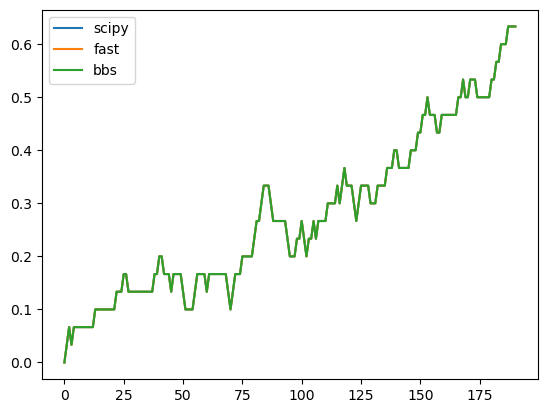

In [131]:
plt.plot(ks_1ds_stat, label='scipy')
plt.plot(ks_fast_1ds_stat, label='fast')
plt.plot(ks_bbs_1ds_stat, label='bbs')
plt.legend()

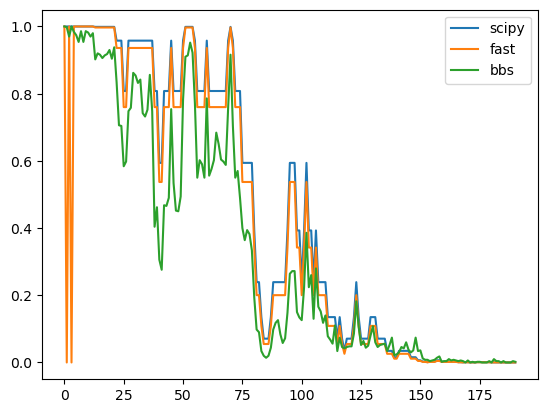

In [132]:
plt.plot(ks_1ds_pval, label='scipy')
plt.plot(ks_fast_1ds_pval, label='fast')
plt.plot(ks_bbs_1ds_pval, label='bbs')
plt.legend()

### Running

In [133]:
def run_over_windows(test_func, windows, base_period_central_year:int = None,
                     data_ds=None, base_period_window_ds=None, data_ds_window=None,
                     save_name=None):
    """
    Run a statistical test over multiple window sizes and merge results.

    Parameters
    ----------
    test_func : callable
        Test function to use inside run_windowed_test (e.g., ks_test).
    windows : list[int]
        List of window sizes to test.
    data_ds : xr.Dataset, optional
        Input dataset to apply the tests on.
    base_period_window_ds : xr.Dataset, optional
        Base period dataset for the test.
    data_ds_window : xr.Dataset, optional
        Dataset providing pre-windowed data.
    save_name : str, optional
        Path to save the output as zarr.

    Returns
    -------
    xr.Dataset
        Merged dataset with test results for all windows.
    """
    if save_name and os.path.exists(save_name):
        logger.info(f"{save_name} already exists")
        with xr.open_dataset(save_name, engine="zarr") as saved_ds:
            windows_saved = np.array(saved_ds.window.values)
            
        windows = np.setdiff1d(windows, windows_saved)
        
        # if len(windows_to_run) == 0:
        #     raise ValueError(
        #         f"All specified windows already exist in {save_name}. "
        #         f"Nothing to run.\nWindows already run: {windows_saved}\n"
        #         f"Windows requested: {windows}"
        #     )
        # logger.info(
        #     f"Windows already run: {windows_saved.tolist()}\n"
        #     f"Windows requested: {windows}\n"
        #     f"Windows remaining to run: {windows_to_run.tolist()}"
        # )

        # windows = windows_to_run

    window_list = []
    for window in windows:
        logger.opt(raw=True).info(f"\rRunning window {window}... ")
        if base_period_central_year:
            base_period = toe_const.BasePeriod(base_period_central_year-window//2, base_period_central_year+window//2-1)
            logger.info(f'Created new base period - {base_period} using {window=} and {base_period_central_year=}')
        else:
            base_period = None
        logger.info(f'Using {base_period=} and {window=}')

        window_ds = run_windowed_test(
            test_func,
            window=window,
            base_period=base_period,
            data_ds=data_ds,
            base_period_window_ds=base_period_window_ds,
            data_ds_window=data_ds_window,
        ).compute()
        window_ds = window_ds.expand_dims(window=[window])

        if save_name:
            logger.info("Saving window")
            if os.path.exists(save_name):
                logger.info(f"File already exists - appending - {save_name}")
                window_ds.to_zarr(save_name, mode="a", append_dim='window', consolidated=True, compute=True)
            else:
                logger.info(f"Creating new file - {save_name}", consolidated=True, compute=True)
                window_ds.to_zarr(save_name, mode="w")

        window_list.append(window_ds)
        logger.info('\n')

    logger.info("All windows complete")

    if save_name and os.path.exists(save_name):
        logger.info("Re-opening full dataset from disk")
        final_ds = xr.open_dataset(save_name, engine="zarr")
    else:
        final_ds = xr.concat(window_list, dim="window")


    
    return final_ds


In [134]:
# ks_test, fast_mannwhitney, block_bootstrap_ks, block_bootstrap_ttest

In [135]:
utils.change_logging_level('debug')

In [136]:
data_ds_window

<xarray.DataArray 'pr' (member: 40, lat: 72, lon: 144, time: 221, window_dim: 30)> Size: 22GB
dask.array<rechunk-merge, shape=(40, 72, 144, 221, 30), dtype=float64, chunksize=(1, 18, 144, 221, 30), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member   (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time     (time) datetime64[ns] 2kB 1880-12-31 1881-12-31 ... 2100-12-31
Dimensions without coordinates: window_dim
Attributes: (1)

In [137]:
base_period_window_ds

<xarray.DataArray 'pr' (member: 40, lat: 72, lon: 144, window_dim: 30)> Size: 100MB
dask.array<getitem, shape=(40, 72, 144, 30), dtype=float64, chunksize=(1, 18, 144, 30), chunktype=numpy.ndarray>
Coordinates:
  * lat         (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon         (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * member      (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * window_dim  (window_dim) datetime64[ns] 240B 1880-12-31 ... 1909-12-31
Attributes: (1)

In [138]:
# %%time
# welch_ttest_ds = run_windowed_test(
#     welch_ttest, window=30,
#     data_ds_window = data_ds_window, base_period_window_ds = base_period_window_ds).compute()

In [139]:
# %%time
# ks_ds = run_windowed_test(ks_test, window=30,
#     data_ds_window = data_ds_window, base_period_window_ds = base_period_window_ds).compute()

In [285]:
%%time
mwu_ds = run_windowed_test(fast_mannwhitney, window=30,
    data_ds_window = data_ds_window, base_period_window_ds = base_period_window_ds).compute()

CPU times: user 1min, sys: 28.6 s, total: 1min 28s
Wall time: 2min 10s


In [141]:
# # %%time
# ks_bbs_ds = run_windowed_test(
#     block_bootstrap_ks, window=30,
#     data_ds_window = data_ds_window, base_period_window_ds = base_period_window_ds)
# ks_bbs_ds = ks_bbs_ds.compute()


In [142]:
# %%time
# ttest_bbs_ds = run_windowed_test(
#     block_bootstrap_ttest, window=30,
#     data_ds_window = data_ds_window, base_period_window_ds = base_period_window_ds)
# ttest_bbs_ds = ttest_bbs_ds.compute()

In [143]:
utils.change_logging_level('INFO')

In [144]:
# if model == 'access': 
#     # windows = [20, 30, 40, 80]
#     windows = np.arange(20, 80, 10)#[20, 30, 40, 50, 60, 80, 100]
#     # windows = [20, 25, 30, 40, 80]#[10, 15, 20, 25, 30, 40, 50, 80, 100]
# else:
#    windows = [10, 15, 20, 25, 30, 40, 50, 80] 

# windows

In [145]:
ttest_windows_ds = run_over_windows(welch_ttest, data_ds=data_ds, windows=windows, 
                                    base_period_window_ds=base_period_window_ds,
                                    save_name = os.path.join(VAR_SAVE_DIR, 'ttest_windows_ds.zarr'))
                                    #base_period_central_year=1915,

09:29:20 | INFO     | __main__:run_over_windows:28 - /g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_pr_(1880_1909)_04/ttest_windows_ds.zarr already exists
09:29:21 | INFO     | __main__:run_over_windows:80 - All windows complete
09:29:21 | INFO     | __main__:run_over_windows:83 - Re-opening full dataset from disk


In [146]:
%%time
ks_windows_ds = run_over_windows(ks_test, data_ds=data_ds, windows=windows, 
                                 base_period_window_ds=base_period_window_ds,
                                 save_name = os.path.join(VAR_SAVE_DIR, 'ks_windows_ds.zarr'))

09:29:21 | INFO     | __main__:run_over_windows:28 - /g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_pr_(1880_1909)_04/ks_windows_ds.zarr already exists
09:29:21 | INFO     | __main__:run_over_windows:80 - All windows complete
09:29:21 | INFO     | __main__:run_over_windows:83 - Re-opening full dataset from disk
CPU times: user 124 ms, sys: 66.1 ms, total: 191 ms
Wall time: 229 ms


In [147]:
%%time
ttest_bbs_windows_ds = run_over_windows(block_bootstrap_ttest, data_ds=data_ds, windows=windows,
                                        base_period_window_ds=base_period_window_ds,
                                        save_name = os.path.join(VAR_SAVE_DIR, 'ttest_bbs_windows_ds.zarr'))

09:29:21 | INFO     | __main__:run_over_windows:28 - /g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_pr_(1880_1909)_04/ttest_bbs_windows_ds.zarr already exists
09:29:21 | INFO     | __main__:run_over_windows:80 - All windows complete
09:29:21 | INFO     | __main__:run_over_windows:83 - Re-opening full dataset from disk
CPU times: user 199 ms, sys: 92.8 ms, total: 292 ms
Wall time: 378 ms


In [148]:
%%time
ks_bbs_windows_ds = run_over_windows(block_bootstrap_ks, data_ds=data_ds, windows=windows,
                                     base_period_window_ds=base_period_window_ds,
                                     save_name = os.path.join(VAR_SAVE_DIR, 'ks_bbs_windows_ds.zarr'))

09:29:21 | INFO     | __main__:run_over_windows:28 - /g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_pr_(1880_1909)_04/ks_bbs_windows_ds.zarr already exists
09:29:21 | INFO     | __main__:run_over_windows:80 - All windows complete
09:29:21 | INFO     | __main__:run_over_windows:83 - Re-opening full dataset from disk
CPU times: user 170 ms, sys: 79.5 ms, total: 250 ms
Wall time: 311 ms


In [149]:
welch_ttest_ds = ttest_windows_ds.sel(window=30).copy()
ks_ds = ks_windows_ds.sel(window=30).copy()

ttest_bbs_ds = ttest_bbs_windows_ds.sel(window=30).copy()
ks_bbs_ds = ks_bbs_windows_ds.sel(window=30).copy()

In [150]:

                                 # base_period_window_ds=base_period_window_ds)
# ks_windows_ds.to_zarr(os.path.join(VAR_SAVE_DIR, 'ks_windows_ds.zarr'), mode='w')
# ks_windows_ds = xr.open_dataset(os.path.join(VAR_SAVE_DIR, 'ks_windows_ds.zarr'), engine='zarr')

In [151]:
# central_year = np.mean([base_period.start, base_period.end]).astype(int)
# base_period_list = [toe_const.BasePeriod(central_year-wl//2, central_year+wl//2) for wl in windows]
# base_period_list
# # Confirm that central years are all teh same
# list(map(lambda x: np.mean([x.start, x.end]), base_period_list))

In [152]:
# %%time
# ttest_windows_ds = run_over_windows(welch_ttest, data_ds=data_ds, windows=windows, base_period_central_year=1915,
#                                    save_name = os.path.join(VAR_SAVE_DIR, 'ttest_windows_ds.zarr'))

#                                     #base_period_window_ds=base_period_window_ds)
# # ttest_windows_ds.to_zarr(os.path.join(VAR_SAVE_DIR, 'ttest_windows_ds.zarr'), mode='w')
# # ttest_windows_ds = xr.open_dataset(os.path.join(VAR_SAVE_DIR, 'ttest_windows_ds.zarr'), engine='zarr')

### Verification
- Comparison with 1d rolling func
Verifyting the abstracted (but faster) methods works by comparing to a single lat, lon point.

In [153]:
def plot_window_comparison(datasets, plot_kwargs=None):
    """
    Plot multiple hypothesis test DataArrays for the same windows, overlayed on the same axes.

    Parameters
    ----------
    datasets : dict[str, xr.DataArray]
        Dictionary of pre-selected DataArrays (already lat/lon/member indexed).
    plot_kwargs : dict, optional
        Extra kwargs to pass to .plot().
    """
    if plot_kwargs is None:
        plot_kwargs = {}

    # get window values from the first entry
    sample = next(iter(datasets.values()))
    windows = sample.window.values

    fig = plt.figure(figsize=(10, len(windows) * 1.2))
    gs = gridspec.GridSpec(len(windows), 1, hspace=0.02)

    for j, win in enumerate(windows):
        ax = fig.add_subplot(gs[j, 0])

        for name, da in datasets.items():
            da.sel(window=win).plot(
                ax=ax,
                linewidth=1.5,
                label=name,
                **plot_kwargs
            )

        ax.set_ylim(1.05, -0.05)
        ax.set_ylabel(f"{win}", rotation=0, ha="right", va="center", fontsize=12)
        ax.axhline(0.01, color="red", linestyle="--", alpha=0.5)

        if j < len(windows) - 1:
            ax.set_xlabel("")
            ax.tick_params(labelbottom=False)

        ax.tick_params(axis="y", labelsize=7)

    fig.legend(datasets.keys(), loc="upper right", bbox_to_anchor=(0.95, 0.98))
    fig.suptitle("Hypothesis test comparison at lat=-39, lon=145", fontsize=14, y=0.92)
    plt.show()


In [154]:
lat_lon_kwargs = dict(lat=-39, lon=145, method="nearest")

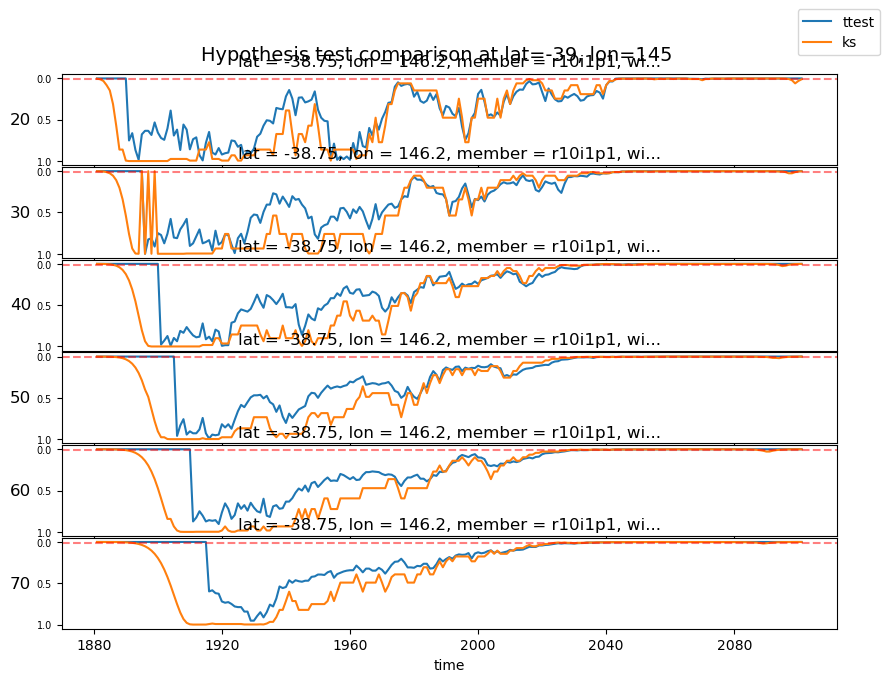

In [155]:
plot_window_comparison(
    datasets = {
"ttest": ttest_windows_ds.sel(**lat_lon_kwargs).isel(**member_kwargs).pval,
"ks": ks_windows_ds.sel(**lat_lon_kwargs).isel(**member_kwargs).pval,
})

In [156]:
if 'member' not in list(data_ds.coords):
    
    plot_window_comparison(datasets = {
        "pval": ttest_windows_ds.sel(**lat_lon_kwargs).isel(**member_kwargs).pval,
        "bbs": ttest_bbs_windows_ds.sel(**lat_lon_kwargs).isel(**member_kwargs).pval,
    })

In [157]:
if 'member' not in list(data_ds.coords):

    plot_window_comparison(datasets = {
        "pval": ks_windows_ds.sel(**lat_lon_kwargs).isel(**member_kwargs).pval,
        "bbs": ks_bbs_windows_ds.sel(**lat_lon_kwargs).isel(**member_kwargs).pval,
    }
                          )

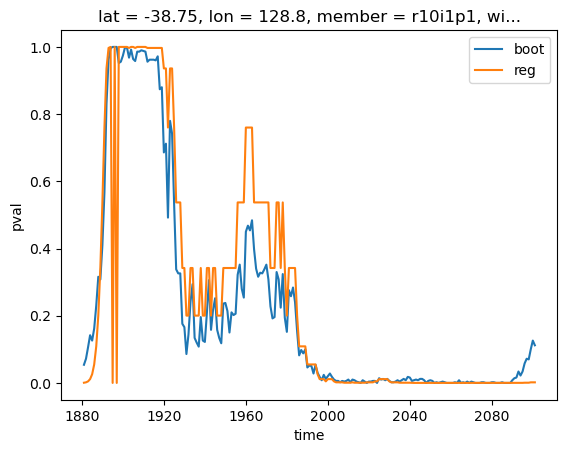

In [158]:
ks_bbs_ds.sel(lat=-38.5, lon=129.5, method='nearest').isel(**member_kwargs).pval.plot(label='boot')
ks_ds.sel(lat=-38.5, lon=129.5, method='nearest').isel(**member_kwargs).pval.plot(label='reg')
plt.legend()

In [159]:
window = 30

In [160]:
lat_lon_sp = dict(lat=-34, lon=145, method='nearest')

In [161]:
reload(toe_calc)

<module 'toe_calc' from '/home/563/ab2313/Documents/time_of_emergene_drafts/src/toe_calc.py'>

In [162]:
stats_test_1d_array_ks = partial(
    toe_calc.stats_test_1d_array, stats_func=toe_calc.return_ks_pvalue,
    window=window, base_period_length=base_period.length+1)

In [163]:
ks_1d_1p = stats_test_1d_array_ks(data_ds.sel(**lat_lon_sp).isel(**member_kwargs).values);

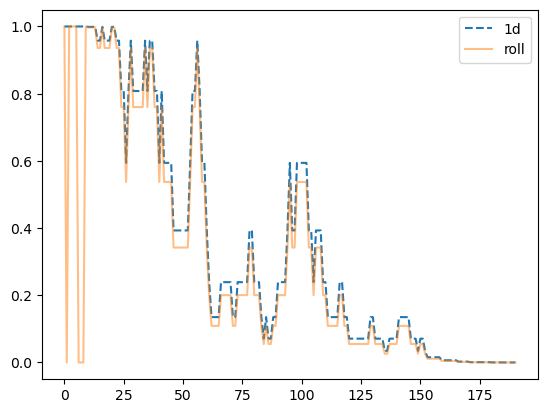

In [164]:
plt.plot(ks_1d_1p,label='1d', linestyle='--')
plt.plot(ks_ds.pval.sel(**lat_lon_sp).isel(time=slice(int(window/2), -int(window/2)), **member_kwargs).values, label='roll', alpha=0.5)
plt.legend()

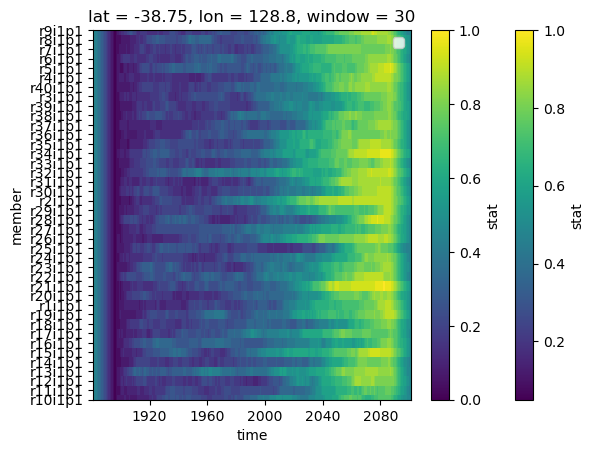

In [165]:
ks_windows_ds.isel(window=0).stat.sel(lat=-38.5, lon=129.5, method='nearest').plot(label='10')
ks_windows_ds.sel(window=30).stat.sel(lat=-38.5, lon=129.5, method='nearest').plot(label='30')
plt.legend()

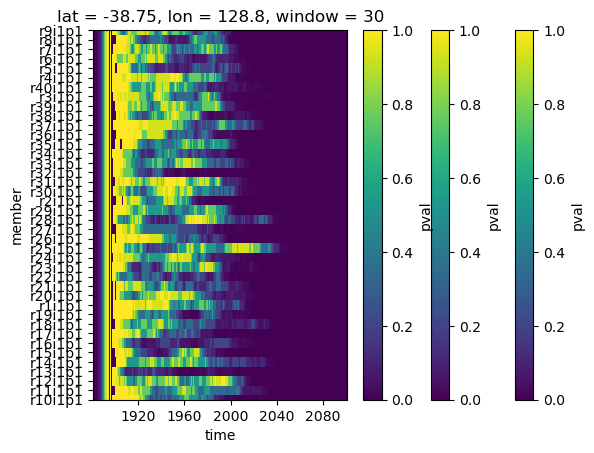

In [166]:
ks_windows_ds.isel(window=0).pval.sel(lat=-38.5, lon=129.5, method='nearest').plot(label='10')
ks_windows_ds.sel(window=30).pval.sel(lat=-38.5, lon=129.5, method='nearest').plot(label='10')
ks_ds.pval.sel(lat=-38.5, lon=129.5, method='nearest').plot(label='10', linestyle='--')

In [167]:
# %%time
# ks_window_list = []
# for window in windows:
#     print(f'{window}, ', end='')
#     ks_window_ds = run_windowed_test(ks_test, base_period, window=window,
#         data_ds=data_ds).compute()
#     ks_window_ds = ks_window_ds.to_array(name=f'ks_{window}')
#     ks_window_list.append(ks_window_ds)
    
# ks_windows_ds = xr.merge(ks_window_list)

In [168]:
# %%time
# sel_kwargs = dict(lat=slice(-60, -30), lon=slice(110, 130))
# block_bootstrap_ks = partial(block_bootstrap_statistic, func=ks_statistic_numba)

# ks_bbs_ds = run_windowed_test(
#     block_bootstrap_ks, base_period, window=30,
#     data_ds_window = data_ds_window.sel(**sel_kwargs), base_period_window_ds = base_period_window_ds.sel(**sel_kwargs))

In [169]:
# chunks_best_ultra_small = {'time':-1, 'lat': 180//10, 'lon': 360//36}
# chunks_best_ultra_small_2 = {'window_dim':-1, 'lat': 180//10, 'lon': 360//36}

In [170]:
# data_ds_window = data_ds_window.chunk(chunks_best_ultra_small).persist()
# base_period_window_ds = base_period_window_ds.chunk(chunks_best_ultra_small_2).persist()

# wait(data_ds_window);
# wait(base_period_window_ds);

<h2 style='color: cyan'> Overlap Methods</h2>

In [171]:
# The x-values for the KDE are based upon the max and min
data_max = data_ds.max().persist().values.item()
data_min = data_ds.min().persist().values.item()
num_points = 1000
x = toe_calc.create_x(bmin=data_min, bmax=data_max, num_points=num_points)

data_min, data_max, x.shape

(0.15139812882644543, 11006.290215570136, (1000,))

In [172]:
# kde_kwargs= dict(bw_method=0.2) # silverman, scott#bw_method=0.2)
kde_kwargs= dict(bw_method=0.6)

In [173]:
toe_calc.create_kde_x_exists

<function toe_calc.create_kde_x_exists(arr: numpy.ndarray, x: numpy.ndarray, **kwargs)>

In [174]:
sample_arr = (data_ds
              .sel(lat=-39, lon=145, method='nearest')
              .isel(**member_kwargs)
              .values)

In [175]:
sample_kde_base = toe_calc.create_kde_x_exists(sample_arr[:30], x, **kde_kwargs)
sample_kde_future1 = toe_calc.create_kde_x_exists(sample_arr[30:60], x, **kde_kwargs)
sample_kde_future2 = toe_calc.create_kde_x_exists(sample_arr[120:150], x, **kde_kwargs)

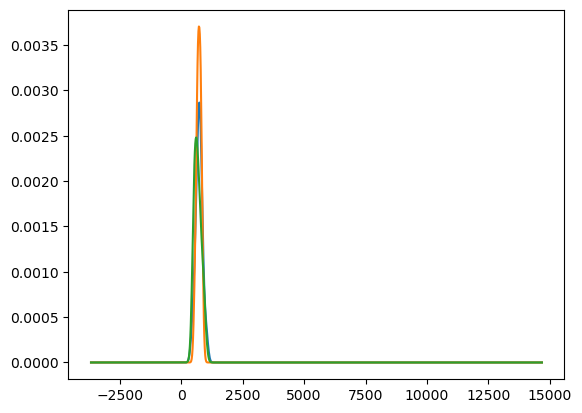

In [176]:
fig, ax = plt.subplots()
ax.plot(x, sample_kde_base)
ax.plot(x, sample_kde_future1)
ax.plot(x, sample_kde_future2)

# ax.set_xlim(285, 300)

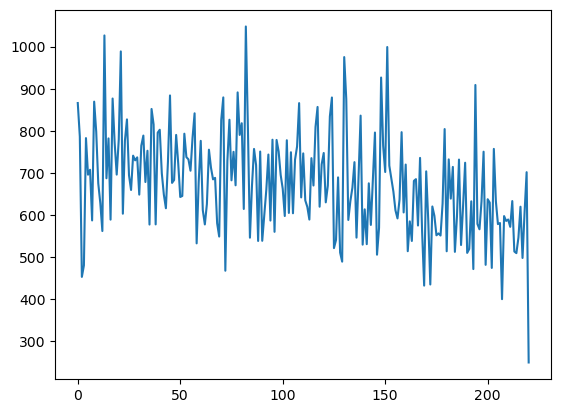

In [177]:
plt.plot(sample_arr)

In [178]:
%%time
# Pre-calculate the base period KDE

base_period_kde = xr.apply_ufunc(
    toe_calc.create_kde_x_exists,
    base_period_ds,
    input_core_dims=[['time'], ],
    output_core_dims=[['x']],
    kwargs={'x': x, **kde_kwargs},
    vectorize=True,
    dask='parallelized',
    output_sizes={'x':len(x)},  # Specify the size of the 'bin' dimension
    output_dtypes=float
).persist()
wait(base_period_kde);

CPU times: user 3.39 s, sys: 1.19 s, total: 4.58 s
Wall time: 5.95 s


In [179]:
%%time
hellinger_ds = xr.apply_ufunc(
    toe_calc.hellinger_distance_optimized,
    data_ds_window,
    base_period_kde,
    input_core_dims=[['window_dim'], ['x']],
    exclude_dims={'window_dim'},
    kwargs={'x': x, 'method_kwargs':kde_kwargs},
    vectorize=True,
    dask='parallelized',
    output_dtypes=float
).compute()

CPU times: user 3min 43s, sys: 2min 8s, total: 5min 51s
Wall time: 9min 44s


In [180]:
# frac_geom_nw_list = []

# # for nw in windows:
#     logger.info(f'{nw=}')
#     data_ds_window_nw = (data_ds
#                       .rolling(time=nw, center=True, min_periods=nw)
#                       .construct('window_dim')
#                       .chunk({'window_dim':-1,**CHUNKS_FOR_PVALUE_TESTS})
#                       .persist()
#                      ) 
    
#     wait(data_ds_window_nw);
    
#     # frac_geom_ds_nw = xr.apply_ufunc(
#     #     toe_calc.fractional_geometric_area_optimized,
#     #     data_ds_window_nw,
#     #     base_period_kde,
#     #     input_core_dims=[['window_dim'], ['x']],
#     #     exclude_dims={'window_dim'},
#     #     kwargs={'x': x, 'method_kwargs':kde_kwargs},
#     #     vectorize=True,
#     #     dask='parallelized',
#     #     output_dtypes=float
#     # ).compute()

#     # frac_geom_ds_nw = frac_geom_ds_nw.expand_dims(window=[nw])
#     # frac_geom_nw_list.append(frac_geom_ds_nw)

# # frac_geom_ds = xr.concat(frac_geom_nw_list, dim='window')

In [181]:
%%time
frac_geom_ds = xr.apply_ufunc(
    toe_calc.fractional_geometric_area_optimized,
    data_ds_window,
    base_period_kde,
    input_core_dims=[['window_dim'], ['x']],
    exclude_dims={'window_dim'},
    kwargs={'x': x, 'method_kwargs':kde_kwargs},
    vectorize=True,
    dask='parallelized',
    output_dtypes=float
).compute()
# wait(frac_geom_ds)

CPU times: user 3min 44s, sys: 2min 12s, total: 5min 57s
Wall time: 9min 53s


In [182]:
x_attrs = { 'bmin': data_min, 'bmax':data_max, 'num_points': num_points}
frac_geom_ds.attrs = {'window': window,**frac_geom_ds.attrs, **kde_kwargs, **x_attrs}
hellinger_ds.attrs =  {'window': window, **hellinger_ds.attrs, **kde_kwargs, **x_attrs}

In [183]:
hellinger_ds

<xarray.DataArray 'pr' (member: 40, lat: 72, lon: 144, time: 221)> Size: 733MB
array([[[[13.54, ..., 81.08],
         ...,
         [13.09, ..., 81.09]],

        ...,

        [[ 7.18, ..., 97.26],
         ...,
         [ 7.19, ..., 97.23]]],


       ...,


       [[[ 9.5 , ..., 74.22],
         ...,
         [ 9.65, ..., 74.35]],

        ...,

        [[11.  , ..., 98.5 ],
         ...,
         [10.63, ..., 98.17]]]])
Coordinates:
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member   (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time     (time) datetime64[ns] 2kB 1880-12-31 1881-12-31 ... 2100-12-31
Attributes: (5)

In [184]:
hellinger_ds.attrs

{'window': 30,
 'bw_method': 0.6,
 'bmin': 0.15139812882644543,
 'bmax': 11006.290215570136,
 'num_points': 1000}

In [185]:
# # latlon_dict = dict(lat=-38, lon=145, method='nearest')
# # latlon_dict = dict(lat=-38, lon=145, method='nearest')
latlon_dict = dict(lat=0.5, lon=-29.75, method='nearest')
toe_calc.hellinger_distance_optimized(
    arr_future=data_ds_window.sel(**latlon_dict).isel(time=slice(30, 60)).values,
    kde_base = base_period_kde.sel(**latlon_dict).values,
    x=x
)

79.53593951254632

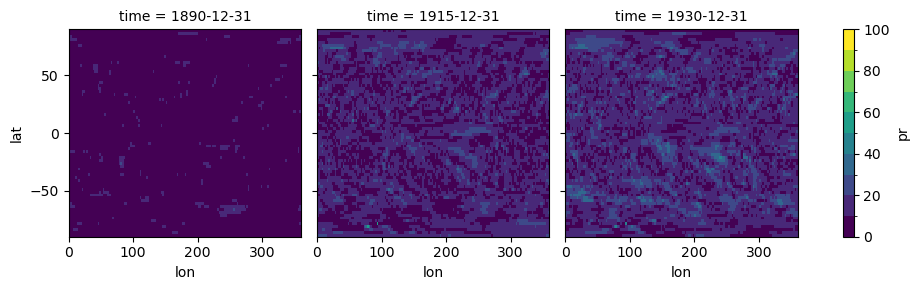

In [186]:
hellinger_ds.isel(time=[10, 35, 50], **member_kwargs).plot(col='time', levels=np.arange(0, 110, 10))

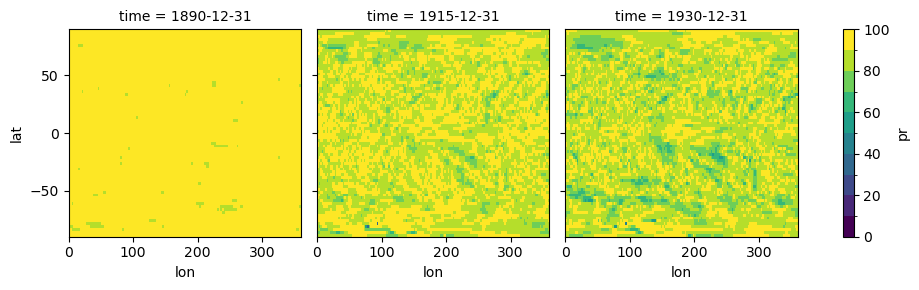

In [187]:
frac_geom_ds.isel(time=[10, 35, 50], **member_kwargs).plot(col='time', levels=np.arange(0, 110, 10))

In [188]:
# frac_geom_ds.isel(window=1).isel(time=window//2, **member_kwargs).plot();

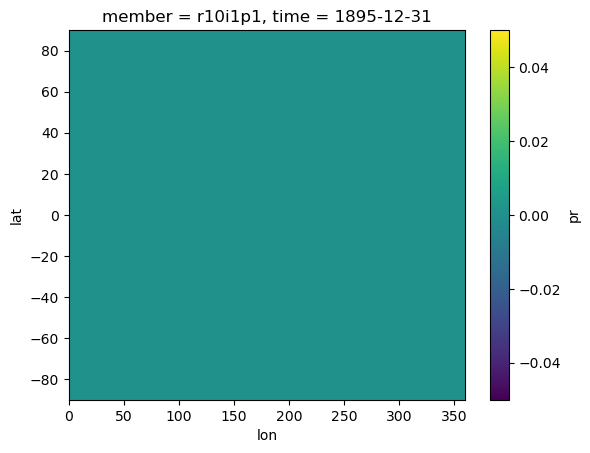

In [189]:
hellinger_ds.isel(time=window//2, **member_kwargs).plot();

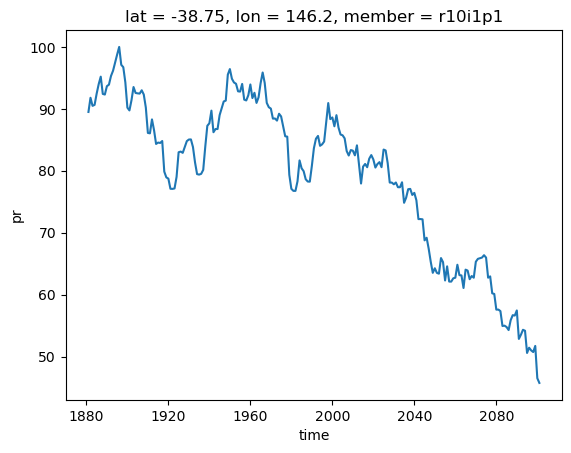

In [190]:
frac_geom_ds.sel(lat=-39, lon=145, method='nearest').isel(**member_kwargs).plot(hue='window');

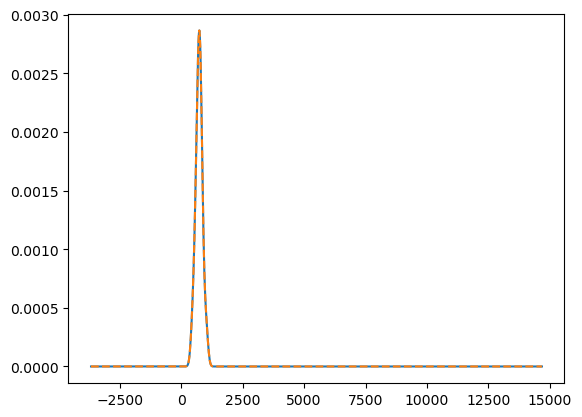

In [191]:
fig, ax1 = plt.subplots(1, 1)

test_loc = dict(lat=-39, lon=145, method='nearest')

test_kde = toe_calc.create_kde_x_exists(
    base_period_ds.sel(**test_loc).isel(**member_kwargs).values, x, **kde_kwargs)

ax1.plot(x, base_period_kde.sel(**test_loc).isel(**member_kwargs).values)
ax1.plot(x, test_kde, linestyle='--')

<h2 style='color: cyan'> Signal-to-Noise </h2>

In [192]:
# Calculate the wegithed mean
# data_ds_smean = climate_utils.weighted_lat_lon_mean(data_anom_ds).compute()

In [193]:
# data_ds_smean.plot()

### Signal

In [194]:
ds_signal_lowess = xr.apply_ufunc(
    my_stats.apply_lowess, 
    data_anom_ds.chunk({'time':-1, 'lat':10}), 
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True, 
    kwargs = dict(window=41),
    dask='parallelized',
    output_dtypes=[float]
).compute()

In [195]:
ds_signal_mean = data_anom_ds.rolling(time=window, center=True).mean().persist()
wait(ds_signal_mean);

In [196]:
signal_pol4_da = my_stats.trend_fit(
    data_anom_ds.chunk({'time':-1, 'lat':10}),
    order=4, method='polynomial').compute()

### Noise

In [197]:
### LOWESS
ds_noise_series_lowess = (data_anom_ds - ds_signal_lowess).compute()
# Noise is std of detrended data
ds_noise_lowess_full = ds_noise_series_lowess.std(dim='time')

noise_lowess_base_period_ds = ds_noise_series_lowess.where(
    ds_noise_series_lowess.time.dt.year.isin(np.arange(*base_period.value)), drop=True).std(dim='time')

In [198]:
# Rolling mean

ds_noise_series_mean = (data_anom_ds - ds_signal_mean).compute()

ds_noise_mean_base_period = ds_noise_series_mean.where(
    ds_noise_series_mean.time.dt.year.isin (np.arange(*base_period.value)), drop=True).std(dim='time')

In [199]:
# 4th order polynomial

ds_noise_series_poly4 = (data_anom_ds - signal_pol4_da).compute()

noise_poly4_base_period_ds = ds_noise_series_poly4.where(
    ds_noise_series_poly4.time.dt.year.isin(np.arange(*base_period.value)), drop=True).std(dim='time')

In [200]:
# data_detrend_mean = (data_anom_ds - ds_signal_mean).persist()
# Detrended usign lowess or else 2 x 15 year periods on either end is lost
std_mean_roll_ds = ds_noise_series_mean.rolling(time=window, center=True).std().persist()
std_lowess_roll_ds = ds_noise_series_lowess.rolling(time=window, center=True).std().persist()

In [201]:
rolling_noise_mean_ds = (np.sqrt(1/2*(noise_poly4_base_period_ds**2+std_mean_roll_ds**2))).persist()
wait(rolling_noise_mean_ds);

In [202]:
rolling_noise_lowess_ds = (np.sqrt(1/2*(noise_lowess_base_period_ds**2+std_lowess_roll_ds**2))).persist()
wait(rolling_noise_lowess_ds);

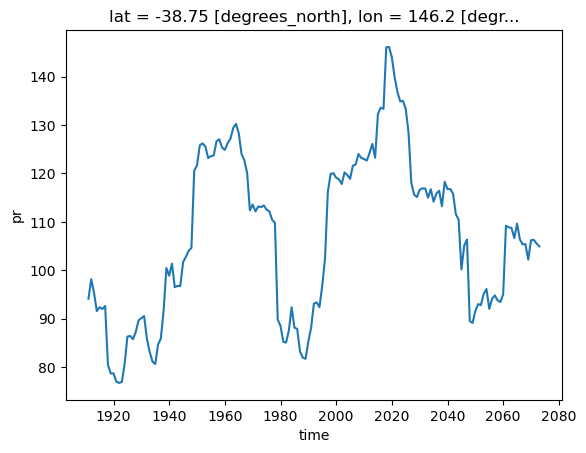

In [203]:
std_mean_roll_ds.isel(**member_kwargs).sel(lat=-39, lon=145, method='nearest').plot()

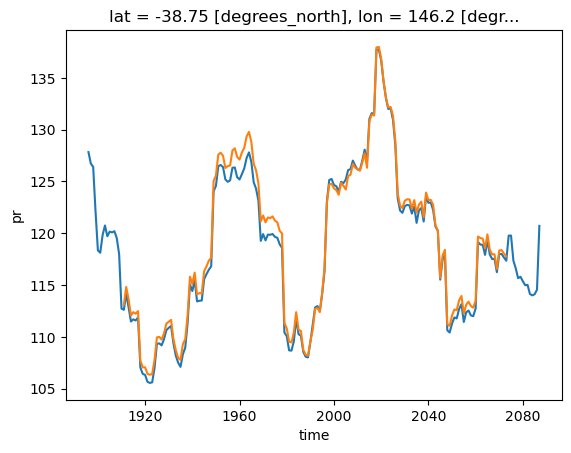

In [204]:
rolling_noise_lowess_ds.isel(**member_kwargs).sel(lat=-39, lon=145, method='nearest').plot()
rolling_noise_mean_ds.isel(**member_kwargs).sel(lat=-39, lon=145, method='nearest').plot()

### S/N ratio

In [205]:
# S/N Ratio
sn_lowess_full_ds = ds_signal_lowess/ds_noise_lowess_full
sn_lowess_base_period_ds = ds_signal_lowess/noise_lowess_base_period_ds

In [206]:
sn_poly4_base_ds = signal_pol4_da/noise_poly4_base_period_ds

In [207]:
sn_mean_base_ds = ds_signal_mean/ds_noise_mean_base_period
wait(sn_mean_base_ds);

In [208]:
sn_lowess_roll_ds = (ds_signal_lowess/rolling_noise_lowess_ds).persist()
wait(sn_lowess_roll_ds);

In [209]:
sn_mean_roll_ds = (ds_signal_mean/rolling_noise_mean_ds).persist()
wait(sn_mean_roll_ds);

In [210]:
# base_period_std = data_detrend_mean.sel(time=slice(str(base_period.start), str(base_period.end))).std(dim='time').persist()

In [211]:
# Get lowess filtered version
# ds_smean_lowess = my_stats.trend_fit(data_ds_smean, method='LOWESS', lowess_window=41)

In [212]:
# %%time
# return_hawkins_signal_and_noise_partial = partial(toe_calc.return_hawkins_signal_and_noise, 
#                                                   gt=ds_smean_lowess.values)

# ds_signal_hawkins, ds_noise_series_hawkins = xr.apply_ufunc(
#     return_hawkins_signal_and_noise_partial,
#     data_anom_ds,
#     input_core_dims=[['time']], 
#     output_core_dims=[['time'], ['time']], 
#     dask='parallelized', 
#     vectorize=True,
#     output_dtypes=[float, float],
# )

# ds_signal_hawkins = ds_signal_hawkins.compute()
# ds_noise_series_hawkins = ds_noise_series_hawkins.compute()

In [213]:
# # Noise 
# ds_noise_hawkins_full = ds_noise_series_hawkins.std(dim='time').compute()

# ds_noise_hawkins_base_period = ds_noise_series_hawkins.where(
#     ds_noise_series_hawkins.time.dt.year.isin(np.arange(*base_period.value)), drop=True).std(dim='time')

# # S/N Ratio 
# ds_sn_hawkins_full = ds_signal_hawkins/ds_noise_hawkins_full
# ds_sn_hawkins_base_period = ds_signal_hawkins/ds_noise_hawkins_base_period

### Plot Verificaiton

In [214]:
lat_lon_sp = dict(lat=-38, lon=145, method='nearest')

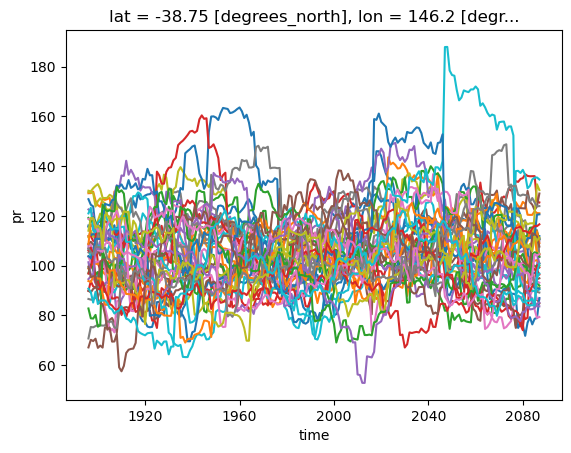

In [215]:
std_lowess_roll_ds.sel(**lat_lon_sp).plot(**plot_kwargs);

Text(0.5, 1.0, 'S/N')

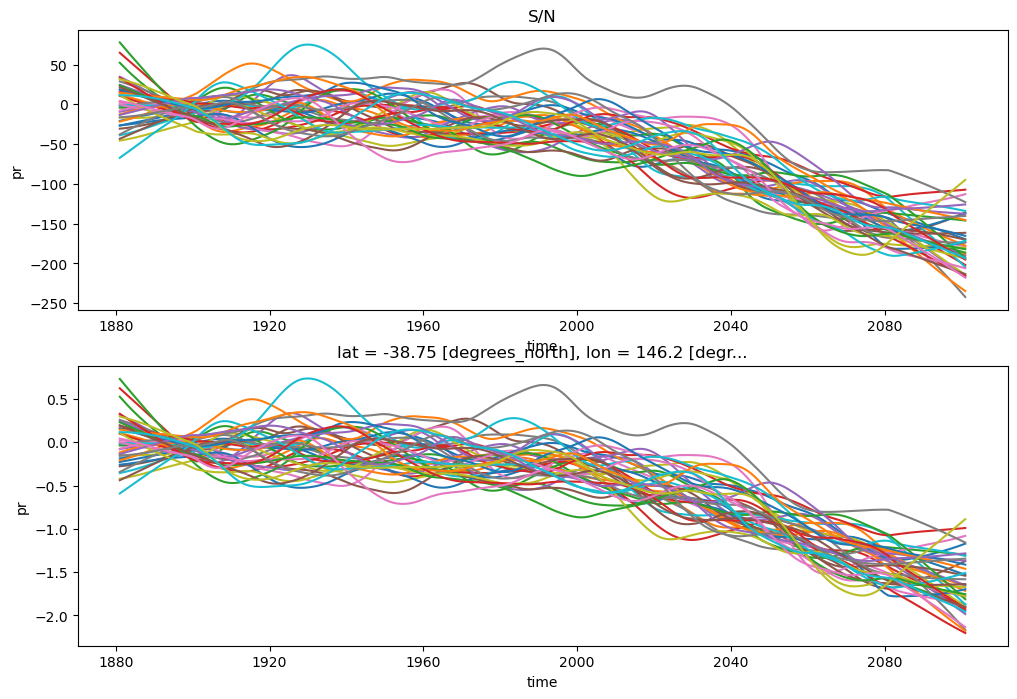

In [216]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
ds_signal_lowess.sel(**lat_lon_sp).plot(ax=axes[0], **plot_kwargs);

sn_lowess_full_ds.sel(**lat_lon_sp).plot(ax=axes[1], **plot_kwargs);


axes[0].set_title('Signal')
axes[0].set_title('S/N')

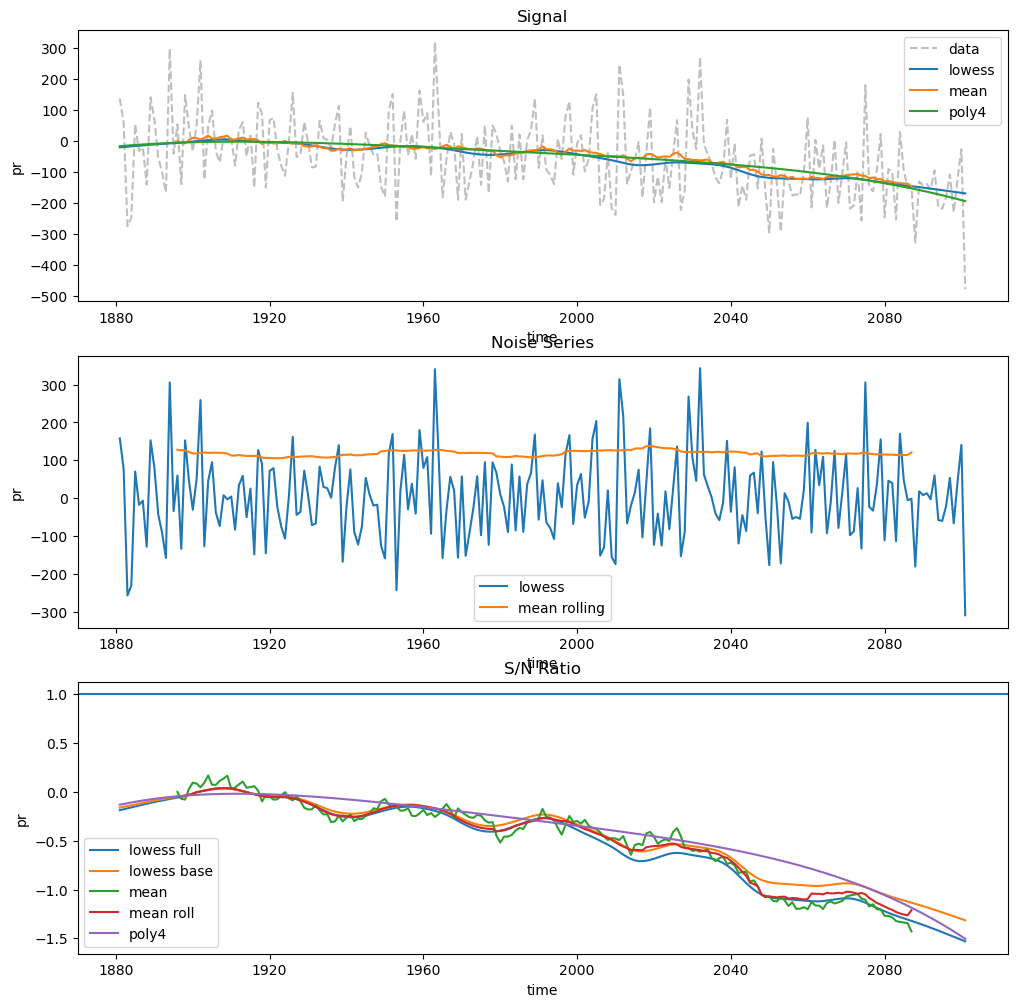

In [217]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

ax1 = axes[0]
data_anom_ds.isel(**member_kwargs).sel(**lat_lon_sp).plot(label='data', ax=ax1, color='grey', linestyle='--', alpha=0.5)
ds_signal_lowess.isel(**member_kwargs).sel(**lat_lon_sp).plot(label='lowess', ax=ax1)
ds_signal_mean.isel(**member_kwargs).sel(**lat_lon_sp).plot(label='mean', ax=ax1)
signal_pol4_da.isel(**member_kwargs).sel(**lat_lon_sp).plot(label='poly4', ax=ax1)
# ds_signal_hawkins.isel(**member_kwargs).sel(**lat_lon_sp).plot(label='hawkins', ax=ax1)

ax1.set_title('Signal')
ax1.legend()

#####
ax2= axes[1]
ds_noise_series_lowess.isel(**member_kwargs).sel(**lat_lon_sp).plot(label='lowess', ax=ax2)
# ds_noise_series_hawkins.isel(**member_kwargs).sel(**lat_lon_sp).plot(label='hawkins', ax=ax2)
rolling_noise_lowess_ds.isel(**member_kwargs).sel(**lat_lon_sp).plot(label='mean rolling', ax=ax2)
ax2.set_title('Noise Series')

ax2.legend()


####
ax3= axes[2]
sn_lowess_full_ds.isel(**member_kwargs).sel(**lat_lon_sp).plot(label='lowess full', ax=ax3)
sn_lowess_base_period_ds.isel(**member_kwargs).sel(**lat_lon_sp).plot(label='lowess base', ax=ax3)
sn_mean_base_ds.isel(**member_kwargs).sel(**lat_lon_sp).plot(label='mean', ax=ax3)
sn_lowess_roll_ds.isel(**member_kwargs).sel(**lat_lon_sp).plot(label='mean roll', ax=ax3)
sn_poly4_base_ds.isel(**member_kwargs).sel(**lat_lon_sp).plot(label='poly4', ax=ax3)

# ds_sn_hawkins_full.isel(**member_kwargs).sel(**lat_lon_sp).plot(label='hawkins full', ax=ax3)
# ds_sn_hawkins_base_period.isel(**member_kwargs).sel(**lat_lon_sp).plot(label='hawkins base', ax=ax3)
ax3.set_title('S/N Ratio')
ax3.axhline(1)
ax3.legend()

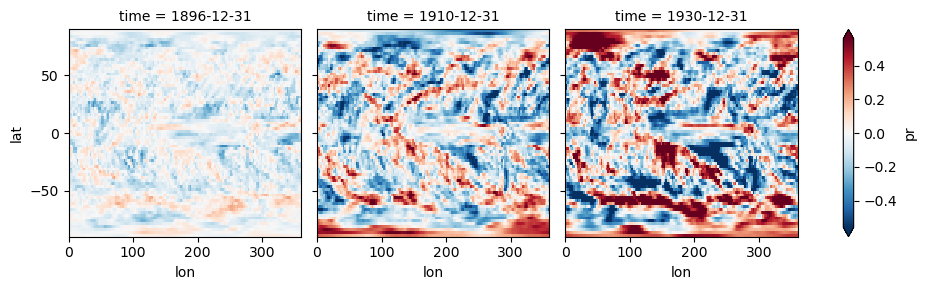

In [218]:
sn_lowess_roll_ds.isel(time=[16, 30, 50], **member_kwargs).plot(col='time', robust=True)

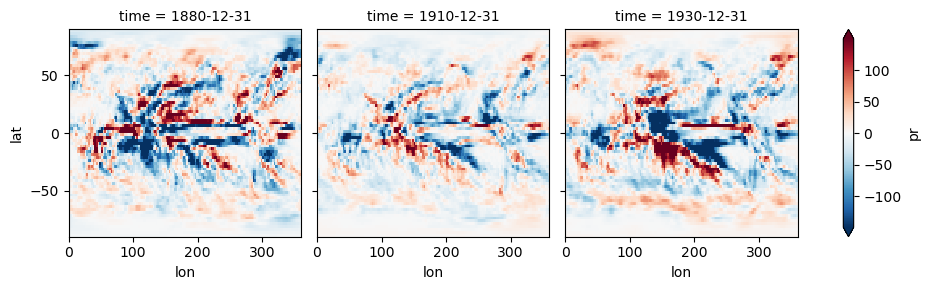

In [219]:
ds_signal_lowess.isel(time=[0, 30, 50], **member_kwargs).plot(col='time', robust=True)

<h2 style='color: cyan'>  Record Statistics</h2>

In [75]:
def _add_record_attrs(rec_ds: xr.Dataset, kind: str) -> xr.Dataset:
    """
    Attach long_name and description attributes to record-statistics dataset.
    """
    if "record_count" in rec_ds:
        rec_ds["record_count"].attrs = {
            "long_name": "Observed cumulative record count",
            "description": (
                "Cumulative number of record-breaking years up to each time step. "
                f"A record is counted when the value exceeds (kind='{kind}') or falls below "
                f"(kind='{kind}') all previous values in the time series."
            )
        }
    if "record_expected_count" in rec_ds:
        rec_ds["record_expected_count"].attrs = {
            "long_name": "Expected cumulative record count",
            "description": (
                "Expected number of records under a stationary climate with no autocorrelation. "
                "Calculated as the harmonic number H_t = 1 + 1/2 + 1/3 + ... + 1/t."
            )
        }
    if "ratar" in rec_ds:
        rec_ds["ratar"].attrs = {
            "long_name": "Ratio of actual to expected records (RatAR)",
            "description": (
                "RatAR = Observed cumulative record count / Expected cumulative record count. "
                "RatAR > 1 indicates more records than expected under stationarity; "
                "RatAR < 1 indicates fewer."
            )
        }
    if "pi_record_freq" in rec_ds:
        rec_ds["pi_record_freq"].attrs = {
            "long_name": "Mean record frequency in piControl",
            "description": (
                "Fraction of years in piControl run that set a new record, "
                "averaged over the entire time series."
            )
        }

    rec_ds.attrs = {
        "method": "Record statistics (RatAR)",
        "reference": "Arnold et al. (1998); Elguindi et al. (2013); Giorgi and Raffaele (2022)",
        "note": (
            "RatAR provides a measure of deviation from stationary expectations of record occurrence. "
            "Assumes independence and no autocorrelation, which may not hold in climate data with "
            "multi-year to decadal variability."
        ),
        "kind": kind
    }
    return rec_ds


In [76]:
def record_statistics(exp_da: xr.DataArray, 
                      pi_da: xr.DataArray = None,
                      kind: str = "high") -> xr.Dataset:
    """
    Calculate record statistics based on RatAR (Ratio of Actual to Expected Records).

    Parameters
    ----------
    exp_da : xr.DataArray
        Experiment (factual) data, must have 'time' dimension.
    pi_da : xr.DataArray, optional
        Control (counterfactual) data for empirical baseline comparison.
    kind : {"high", "low"}, default="high"
        Whether to calculate high (new maxima) or low (new minima) records.

    Returns
    -------
    rec_ds : xr.Dataset
        Dataset containing:
          - record_count : observed cumulative count of records
          - record_expected_count : expected cumulative record count (harmonic numbers)
          - ratar : ratio of observed to expected cumulative records
          - pi_record_freq : mean record frequency in piControl (if pi_da given)
    """
    # --- Detect records (new highs or new lows) ---
    if kind == "high":
        cum_func = xr.apply_ufunc(
            np.maximum.accumulate, exp_da,
            input_core_dims=[["time"]],
            output_core_dims=[["time"]],
            vectorize=True, dask="parallelized"
        )
        is_record = exp_da > cum_func.shift(time=1)

    elif kind == "low":
        cum_func = xr.apply_ufunc(
            np.minimum.accumulate, exp_da,
            input_core_dims=[["time"]],
            output_core_dims=[["time"]],
            vectorize=True, dask="parallelized"
        )
        is_record = exp_da < cum_func.shift(time=1)

    else:
        raise ValueError("kind must be 'high' or 'low'")

    # --- Observed cumulative record count ---
    record_count_da = is_record.cumsum(dim="time")

    # --- Expected cumulative record count (harmonic numbers) ---
    n_time = exp_da.sizes["time"]
    harmonic_numbers = np.cumsum(1 / np.arange(1, n_time + 1))
    record_expected_count_da = xr.DataArray(
        harmonic_numbers,
        dims=["time"],
        coords={"time": exp_da.time}
    )

    # --- Ratio of actual to expected records (RatAR) ---
    ratar_da = record_count_da / record_expected_count_da

    # Package results into a dataset
    rec_ds = xr.Dataset({
        "record_count": record_count_da,
        "record_expected_count": record_expected_count_da,
        "ratar": ratar_da
    })

    # --- Optional: empirical baseline from piControl ---
    if pi_da is not None:
        if kind == "high":
            pi_cum_func = xr.apply_ufunc(
                np.maximum.accumulate, pi_da,
                input_core_dims=[["time"]],
                output_core_dims=[["time"]],
                vectorize=True, dask="parallelized"
            )
            pi_is_record = pi_da > pi_cum_func.shift(time=1)
        else:
            pi_cum_func = xr.apply_ufunc(
                np.minimum.accumulate, pi_da,
                input_core_dims=[["time"]],
                output_core_dims=[["time"]],
                vectorize=True, dask="parallelized"
            )
            pi_is_record = pi_da < pi_cum_func.shift(time=1)

        rec_ds["pi_record_freq"] = pi_is_record.mean(dim="time")
    # Add metadata
    
    rec_ds = _add_record_attrs(rec_ds, kind)

    return rec_ds

In [77]:
arr_da = data_ds.sel(**lat_lon_sp).isel(**member_kwargs)

In [78]:
# arr_da is a 1D DataArray with dimension "time"

print("Original data:")
print(arr_da.isel(time=slice(0,10)).values)

# Running maximum of the series along 'time'
cummax_vals = np.maximum.accumulate(arr_da.values)
print("\nCumulative maximum:")
print(cummax_vals[:10])

# Wrap back into a DataArray with same coords as arr_da
cummax_da = xr.DataArray(cummax_vals, dims=["time"], coords={"time": arr_da.time})

# Shift by one step so that at time t you only compare against all *previous* values
cummax_shifted = cummax_da.shift(time=1)
print("\nShifted cumulative maximum:")
print(cummax_shifted.isel(time=slice(0,10)).values)

# Boolean mask: True where arr_da[t] is greater than all previous values
is_record = arr_da > cummax_shifted
print("\nRecord mask:")
print(is_record.isel(time=slice(0,20)).values)

# Cumulative count of records (observed)
record_count_da = is_record.cumsum(dim="time")
print("\nCumulative record count:")
print(record_count_da.isel(time=slice(0,20)).values)

# Expected cumulative number of records under stationarity
# -------------------------------------------------------
# For a stationary climate (no trend, no autocorrelation):
#   - The probability that the 1st year is a record = 1
#   - The probability that the 2nd year is a record = 1/2
#   - The probability that the 3rd year is a record = 1/3
#   - ...
#   - The probability that the n-th year is a record = 1/n
#
# The *expected cumulative number of records* up to year t
# is the sum of these probabilities:
#   H_t = 1 + 1/2 + 1/3 + ... + 1/t
#
# This is known as the harmonic number H_t.
# It grows slowly with time (logarithmically).
#
# Example:
#   After 1 year: expect 1 record
#   After 2 years: expect 1 + 1/2 = 1.5 records
#   After 5 years: expect 1 + 1/2 + 1/3 + 1/4 + 1/5 ≈ 2.28 records

n_time = arr_da.sizes["time"]
harmonic_numbers = np.cumsum(1 / np.arange(1, n_time + 1))

record_expected_count_da = xr.DataArray(
    harmonic_numbers,
    dims=["time"],
    coords={"time": arr_da.time}
)

print("\nExpected cumulative record count under stationarity:")
print(record_expected_count_da.isel(time=slice(0,20)).values)

# RatAR: observed / expected record counts
ratar_da = record_count_da / record_expected_count_da
print("\nRatAR (Ratio of Actual to Expected Records):")
print(ratar_da.values)

Original data:
[ 561.57  566.92  451.33  537.97  847.03  771.99  900.78  853.51 1011.5
  919.84]

Cumulative maximum:
[ 561.57  566.92  566.92  566.92  847.03  847.03  900.78  900.78 1011.5
 1011.5 ]

Shifted cumulative maximum:
[    nan  561.57  566.92  566.92  566.92  847.03  847.03  900.78  900.78
 1011.5 ]

Record mask:
[False  True False False  True False  True False  True False False False
 False  True False False False False False False]

Cumulative record count:
[0 1 1 1 2 2 3 3 4 4 4 4 4 5 5 5 5 5 5 5]

Expected cumulative record count under stationarity:
[1.   1.5  1.83 2.08 2.28 2.45 2.59 2.72 2.83 2.93 3.02 3.1  3.18 3.25
 3.32 3.38 3.44 3.5  3.55 3.6 ]

RatAR (Ratio of Actual to Expected Records):
[0.   0.67 0.55 0.48 0.88 0.82 1.16 1.1  1.41 1.37 1.32 1.29 1.26 1.54
 1.51 1.48 1.45 1.43 1.41 1.39 1.37 1.35 1.34 1.32 1.31 1.3  1.28 1.27
 1.26 1.25 1.24 1.23 1.22 1.21 1.21 1.2  1.19 1.18 1.18 1.17 1.16 1.16
 1.15 1.14 1.14 1.13 1.13 1.12 1.12 1.11 1.11 1.1  1.1  1.09 1.09 1

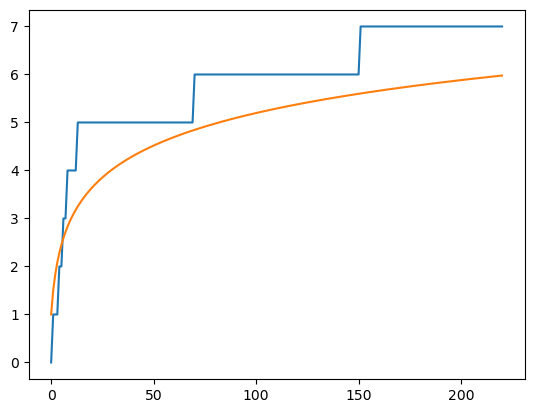

In [79]:
fig, ax = plt.subplots()
ax.plot(record_count_da.values)
ax.plot(record_expected_count_da.values)

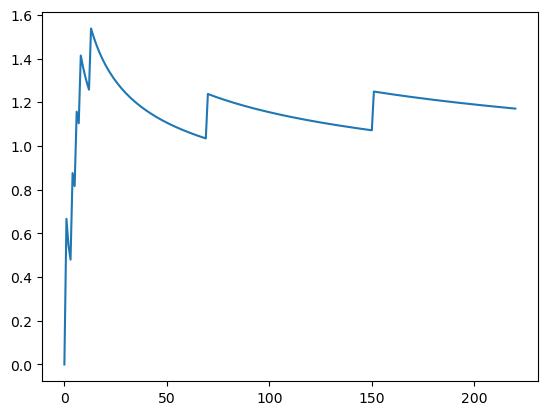

In [80]:
plt.plot(ratar_da.values)

In [81]:
rec_theory_ds = record_statistics(data_ds, kind="high").persist()
wait(rec_theory_ds);

In [82]:
rec_theory_low_ds = record_statistics(data_ds, kind="low").persist()
wait(rec_theory_ds);

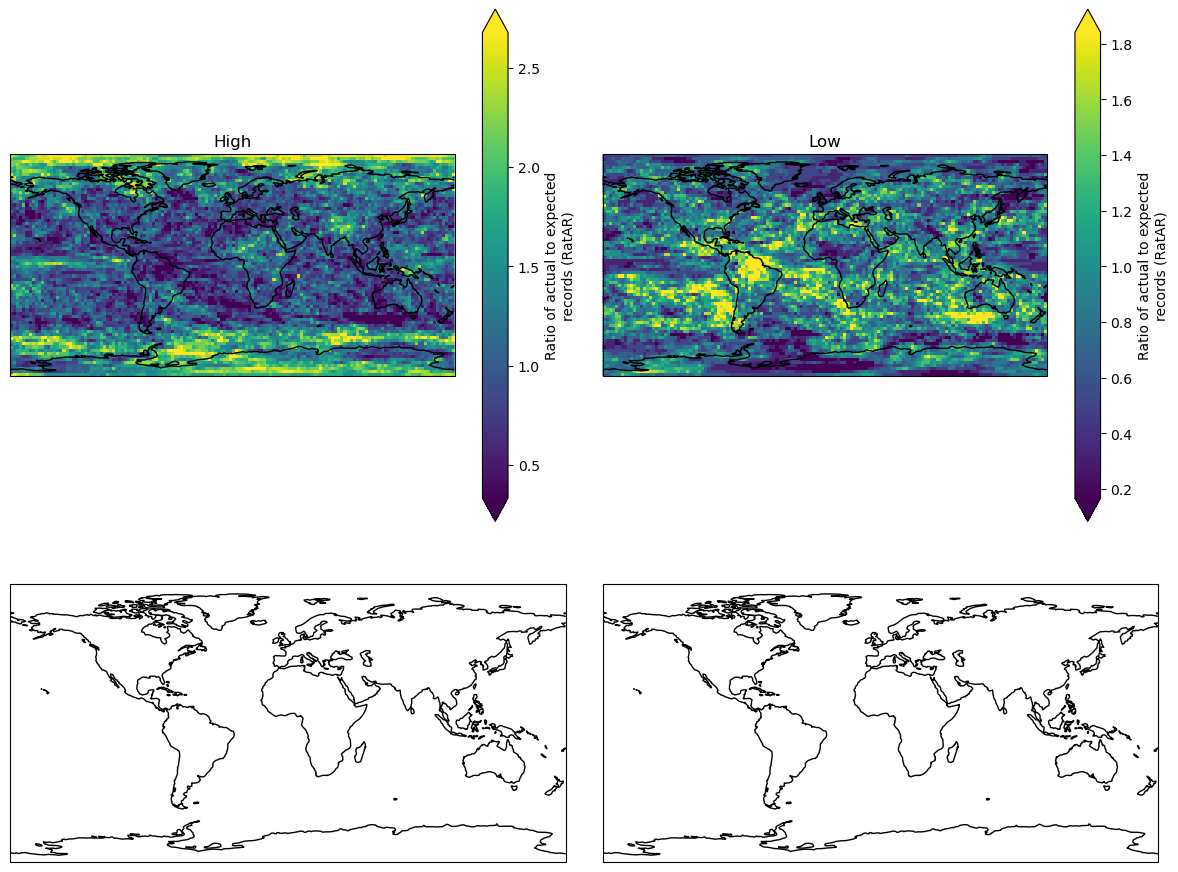

In [83]:
fig = plt.figure(figsize=(12, 10))

axes = [
    fig.add_subplot(2, 2, 1, projection=ccrs.PlateCarree()),
    fig.add_subplot(2, 2, 2, projection=ccrs.PlateCarree()),
    fig.add_subplot(2, 2, 3, projection=ccrs.PlateCarree()),
    fig.add_subplot(2, 2, 4, projection=ccrs.PlateCarree()),
]

# Plot each dataset on its axis
rec_theory_ds.ratar.isel(time=-1, **member_kwargs).plot(
    ax=axes[0], transform=ccrs.PlateCarree(), robust=True
)
rec_theory_low_ds.ratar.isel(time=-1, **member_kwargs).plot(
    ax=axes[1], transform=ccrs.PlateCarree(), robust=True
)
# ds_signal_lowess.isel(time=-1, **member_kwargs).plot(
#     ax=axes[2], transform=ccrs.PlateCarree(), robust=True
# )
# sn_lowess_base_period_ds.isel(time=-1, **member_kwargs).plot(
#     ax=axes[3], transform=ccrs.PlateCarree(), robust=True
# )

axes[0].set_title("High")
axes[1].set_title("Low")

for ax in axes:
    ax.coastlines()

fig.tight_layout()


In [84]:
# if 'member' in list(data_ds.coords):
    
#     rec_empirical_ds = record_statistics(data_ds, pi_da=le_pi_ds, kind="high").persist()
#     wait(rec_empirical_ds);

In [85]:
rec_theory_ds

<xarray.Dataset> Size: 1GB
Dimensions:                (lat: 72, lon: 144, member: 40, time: 221)
Coordinates:
  * lat                    (lat) float64 576B -88.75 -86.25 ... 86.25 88.75
  * lon                    (lon) float64 1kB 1.25 3.75 6.25 ... 356.2 358.8
  * member                 (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r9i1p1'
  * time                   (time) datetime64[ns] 2kB 1880-12-31 ... 2100-12-31
Data variables:
    record_count           (member, lat, lon, time) int64 733MB dask.array<chunksize=(1, 18, 144, 221), meta=np.ndarray>
    record_expected_count  (time) float64 2kB 1.0 1.5 1.833 ... 5.973 5.978
    ratar                  (member, lat, lon, time) float64 733MB dask.array<chunksize=(1, 18, 144, 221), meta=np.ndarray>
Attributes: (4)

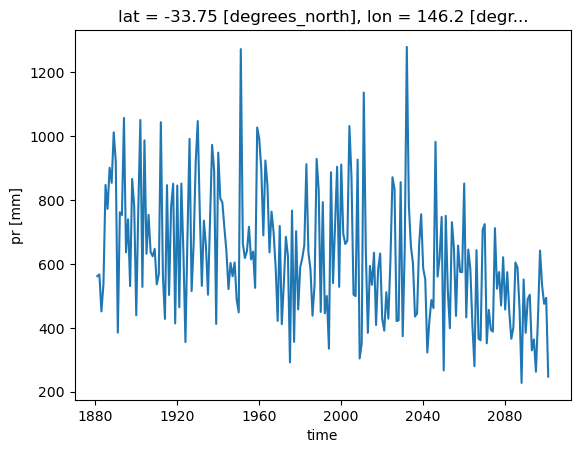

In [86]:
data_ds.sel(**lat_lon_sp).isel(**member_kwargs).plot()

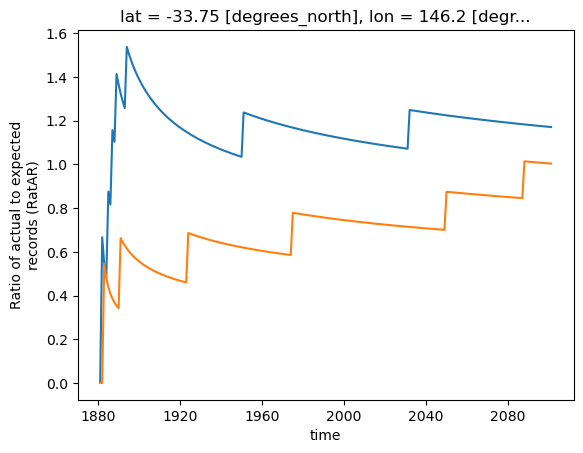

In [87]:
fig, ax = plt.subplots()
rec_theory_ds.ratar.sel(**lat_lon_sp).isel(**member_kwargs).plot(ax=ax)
rec_theory_low_ds.ratar.sel(**lat_lon_sp).isel(**member_kwargs).plot(ax=ax)

# rec_empirical_ds.ratar.sel(**lat_lon_sp).isel(**member_kwargs).plot(ax=ax)

<h1 style='color: yellow'>  Model Only </h1>

<h2 style='color: cyan'> Open piControl</h2>

In [233]:
# # PICONTROL_PATH = '/g/data/oi10/replicas/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/tas/gn/v20190320'
# # PICONTROL_PATH = "/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1/Amon/tas/gn/v20210316"
# ESMPICONTROL_PATH =\
#     ("/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/"
#     "esm-piControl/r1i1p1f2/Amon/tas/gn/v20250307")
# # ESMPCONTROL_PATH2 = '/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/esm-piControl/r1i1p1f2/Amon/tas/gn/v20250307'

# # ESM_PI_CONTROL_PATH_3 = ("/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/"
#                         # "esm-piControl/r1i3p1f2/Amon/tas/gn/v20250307")

In [234]:
# # le_pi_ds = xr.open_mfdataset(os.path.join(ESM_PI_CONTROL_PATH_3, '*.nc'), use_cftime=True).persist()
# le_pi_ds = xr.open_mfdataset(os.path.join(ESMPICONTROL_PATH, '*.nc'),
#                              use_cftime=True).chunk(PI_CHUNKS).persist()
# le_pi_ds = le_pi_ds['tas'].resample(time='YE').mean().persist()

# le_pi_ds.to_zarr(
#     '/g/data/w40/ab2313/time_of_emergence/access_esmpicontrol_2.zarr', mode='w')
# wait(le_pi_ds);

In [235]:
# PICONTROL_PATH = '/g/data/w40/ab2313/time_of_emergence/access_picontrol.zarr'
# PICONTROL_PATH_PR = '/g/data/w40/ab2313/time_of_emergence/access_picontrol_pr.zarr'
# # ESMPICONTROL_PATH = '/g/data`/w40/ab2313/time_of_emergence/access_esmpicontrol.zarr'

In [236]:
# PICONTROL_PATH = ('/g/data/fs38/publications/CMIP6/CMIP/'
#                   'CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1/Amon/pr/gn/v20210316/')

In [237]:
import climtas

In [238]:
PI_CHUNKS = {'time':-1, 'lat':'auto', 'lon':'auto'}

In [239]:
PICONTROL_PATH_DICT = {
    'tas': '/g/data/w40/ab2313/time_of_emergence/access_picontrol.zarr',
    'pr': '/g/data/w40/ab2313/time_of_emergence/access_picontrol_pr.zarr'
}

In [240]:
PICONTROL_PATH = PICONTROL_PATH_DICT[variable]
PICONTROL_PATH

'/g/data/w40/ab2313/time_of_emergence/access_picontrol_pr.zarr'

In [241]:
le_pi_raw_ds = xr.open_dataset(PICONTROL_PATH, engine='zarr', use_cftime=True)[variable].chunk(PI_CHUNKS).persist()#.compute()

In [242]:
le_pi_raw_ds = le_pi_raw_ds.compute()

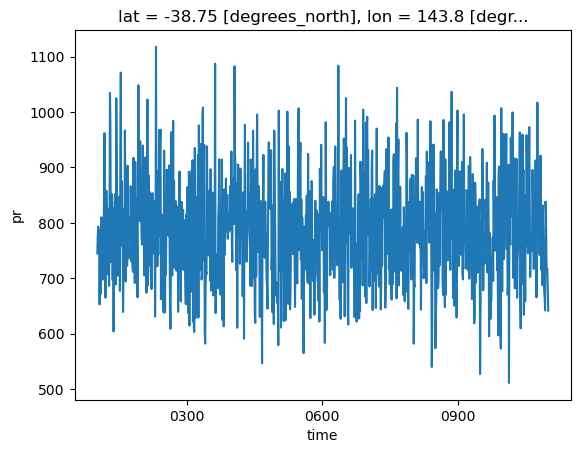

In [243]:
le_pi_raw_ds.sel(lat=-39, lon=145, method='nearest').plot()

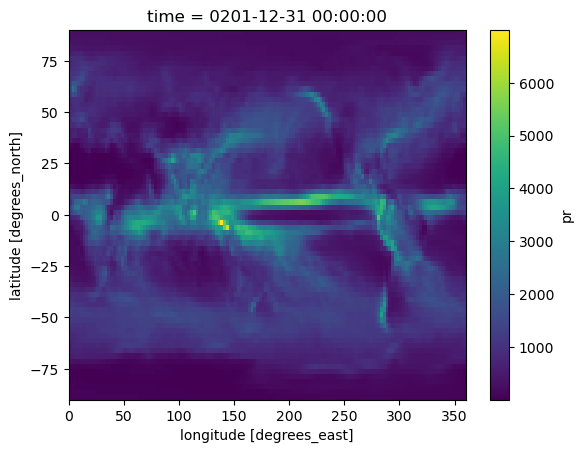

In [244]:
le_pi_raw_ds.isel(time=100).plot()

In [245]:
# if variable == 'pr':
#     days_per_month =  le_pi_raw_ds.time.dt.days_in_month  
#     le_pi_raw_ds = le_pi_raw_ds * 86400 * days_per_month  
#     le_pi_raw_ds = le_pi_raw_ds.resample(time="YE").sum().compute()

In [246]:
target_grid = data_ds.isel(time=0, member=0).drop_vars(['time', 'member']).compute()
target_grid

<xarray.DataArray 'pr' (lat: 72, lon: 144)> Size: 83kB
array([[ 59.28, ...,  59.84],
       ...,
       [212.9 , ..., 212.56]])
Coordinates:
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
Attributes: (1)

In [247]:
if variable == 'pr':
    print('Using conservative')
    weights = climtas.regrid.cdo_generate_weights(le_pi_raw_ds, target_grid, method='con')
    regridder = climtas.regrid.Regridder(weights = weights)
else:
    print('Default')
    regridder = climtas.regrid.Regridder(le_pi_raw_ds, target_grid)

Using conservative


In [248]:
le_pi_ds = regridder.regrid(le_pi_raw_ds).persist()
le_pi_ds = le_pi_ds.set_index(lat='lat', lon='lon')  # makes them proper indexes (reset for some reason)
wait(le_pi_ds);

In [249]:
le_pi_ds

<xarray.DataArray 'pr' (time: 1000, lat: 72, lon: 144)> Size: 83MB
dask.array<reshape, shape=(1000, 72, 144), dtype=float64, chunksize=(1000, 72, 144), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 8kB 0101-12-31 00:00:00 ... 1100-12-31 00:00:00
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.3 353.8 356.2 358.7

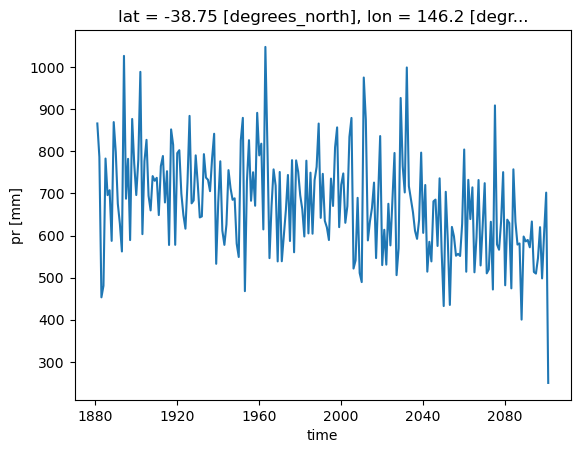

In [250]:
data_ds.sel(lat=-39, lon=145, method='nearest').isel(member=0).plot()

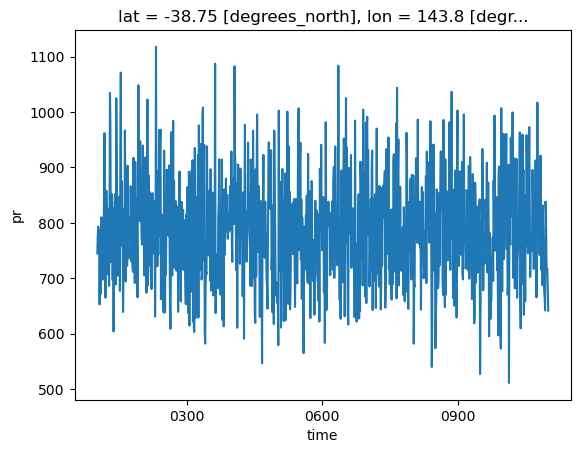

In [251]:
le_pi_ds.sel(lat=-39, lon=145, method='nearest').plot()

In [252]:
le_pi_ds['lat'] = data_ds.lat.values
le_pi_ds['lon'] = data_ds.lon.values

In [253]:
np.testing.assert_equal(data_anom_ds.lon.values, le_pi_ds.lon.values)
np.testing.assert_equal(data_anom_ds.lat.values, le_pi_ds.lat.values)

In [254]:
le_pi_ds.sel(lat=-39, lon=145, method='nearest')

<xarray.DataArray 'pr' (time: 1000)> Size: 8kB
dask.array<getitem, shape=(1000,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 8kB 0101-12-31 00:00:00 ... 1100-12-31 00:00:00
    lat      float64 8B -38.75
    lon      float64 8B 146.2

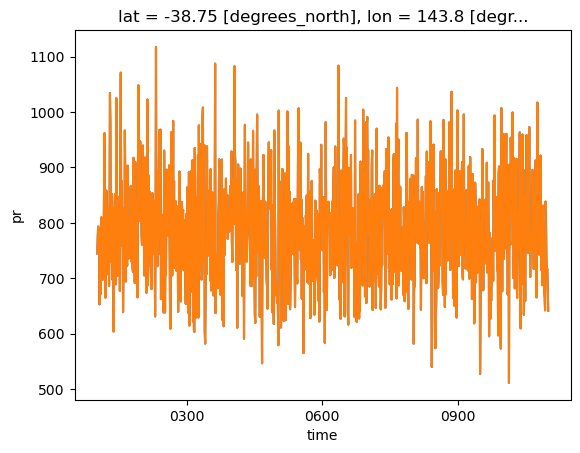

In [255]:
le_pi_ds.sel(lat=-39, lon=143, method='nearest').plot()
le_pi_raw_ds.sel(lat=-39, lon=143, method='nearest').plot()

<h2 style='color: cyan'> Probability Ratio - PR </h2>

In [256]:
def probability_ratio(exp_da: xr.DataArray, 
                      pi_da: xr.DataArray, 
                      percentile: float = 95,
                      window: int = 30) -> xr.Dataset:
    """
    Calculate Probability Ratio (PR) for emergence with rolling windows.

    Parameters
    ----------
    exp_da : xr.DataArray
        Experiment (factual) data (e.g., 1pctCO2, historical).
        Must have a 'time' dimension.
    pi_da : xr.DataArray
        Control (counterfactual, e.g., piControl) data.
        Must have a 'time' dimension.
    percentile : float, default=95
        Percentile (0-100) used to define the threshold from piControl.
    window : int, default=30
        Rolling window length along 'time' for estimating probabilities.

    Returns
    -------
    pr_ds : xr.Dataset
        Dataset containing time series of:
          - pr : Probability ratio (P_factual / P_counterfactual)
          - pr_fac : Factual exceedance probability (rolling)
          - pr_cfac : Counterfactual exceedance probability (fixed)
          - count_fac : Factual exceedance count (rolling)
          - count_cfac : Counterfactual exceedance count (fixed)
    """
    threshold = le_pi_ds.quantile(percentile / 100, dim="time")
    
    # Counterfactual (fixed in time)
    count_cfac_da = (le_pi_ds > threshold).sum(dim="time")
    pr_cfac_da = count_cfac_da / le_pi_ds.sizes["time"]
    
    # Factual (rolling in time)
    exceed_fac = (data_ds > threshold)
    count_fac_da = exceed_fac.rolling(time=window, center=True).sum()
    pr_fac_da = count_fac_da / window
    
    # Probability ratio (rolling)
    pr_da = pr_fac_da / pr_cfac_da
    
    # Package into dataset
    pr_ds = xr.Dataset({
        "pr": pr_da,
        "pr_fac": pr_fac_da,
        "num_fac": count_fac_da,
    }).persist()

    return pr_ds


In [257]:
pr_95_ds = probability_ratio(data_ds, le_pi_ds, percentile=95).persist()
wait(pr_95_ds);

In [258]:
pr_99_ds = probability_ratio(data_ds, le_pi_ds, percentile=99).persist()
wait(pr_99_ds);

In [259]:
pr_95_ds

<xarray.Dataset> Size: 2GB
Dimensions:   (lat: 72, lon: 144, member: 40, time: 221)
Coordinates:
  * lat       (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon       (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member    (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time      (time) datetime64[ns] 2kB 1880-12-31 1881-12-31 ... 2100-12-31
    quantile  float64 8B 0.95
Data variables:
    pr        (member, lat, lon, time) float64 733MB dask.array<chunksize=(1, 18, 144, 220), meta=np.ndarray>
    pr_fac    (member, lat, lon, time) float64 733MB dask.array<chunksize=(1, 18, 144, 220), meta=np.ndarray>
    num_fac   (member, lat, lon, time) float64 733MB dask.array<chunksize=(1, 18, 144, 220), meta=np.ndarray>

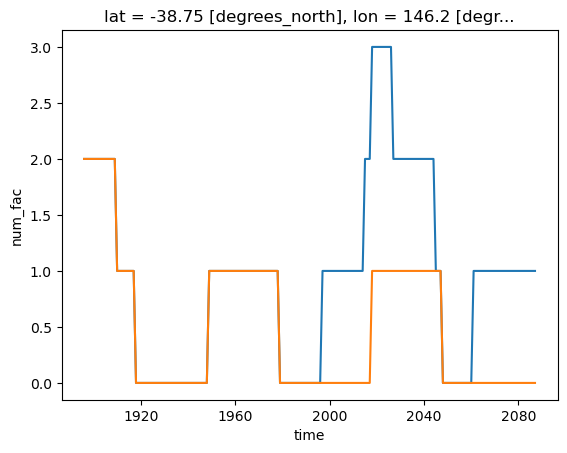

In [260]:
fig, ax = plt.subplots()
pr_95_ds.sel(**lat_lon_sp).isel(**member_kwargs).num_fac.plot(ax=ax)
pr_99_ds.sel(**lat_lon_sp).isel(**member_kwargs).num_fac.plot(ax=ax)

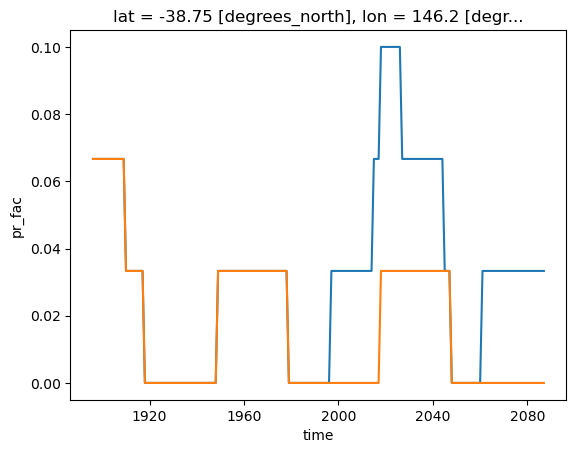

In [261]:
fig, ax = plt.subplots()
pr_95_ds.sel(**lat_lon_sp).isel(**member_kwargs).pr_fac.plot(ax=ax)
pr_99_ds.sel(**lat_lon_sp).isel(**member_kwargs).pr_fac.plot(ax=ax)

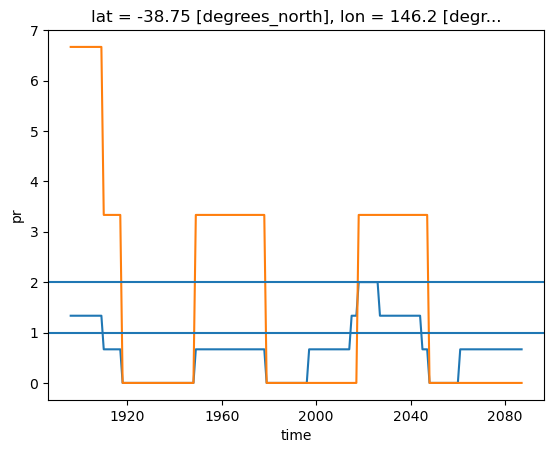

In [262]:
fig, ax = plt.subplots()
pr_95_ds.sel(**lat_lon_sp).isel(**member_kwargs).pr.plot(ax=ax)
pr_99_ds.sel(**lat_lon_sp).isel(**member_kwargs).pr.plot(ax=ax)

ax.axhline(1)
ax.axhline(2)

<h2 style='color: cyan'> S/N Rtaio </h2>

In [263]:
singal_ens_median = data_anom_ds.median(dim='member').compute()
wait(singal_ens_median);

In [264]:
le_pi_ds_noise = le_pi_ds.std(dim='time')

In [265]:
# Noise series is detrended data
ds_noise_series_mean = (data_anom_ds - ds_signal_mean).compute()

ds_noise_mean_base_period = ds_noise_series_mean.where(
    ds_noise_series_mean.time.dt.year.isin (np.arange(*base_period.value)), drop=True).std(dim='time')

In [266]:
# Noise series is detrended data
ds_noise_series_ens_median = (data_anom_ds - singal_ens_median).compute()

ds_noise_series_ens_median_base_period = ds_noise_series_ens_median.where(
    ds_noise_series_ens_median.time.dt.year.isin(np.arange(*base_period.value)), drop=True).std(dim='time')

In [267]:
sn_ens_med_base_period = singal_ens_median/ds_noise_series_ens_median_base_period

In [268]:
sn_mean_base = (ds_signal_mean/ds_noise_mean_base_period).persist()

In [269]:
sn_ens_med_pi = (singal_ens_median/le_pi_ds_noise).persist()

In [270]:
sn_lowess_pi = (ds_signal_lowess/le_pi_ds_noise).persist()

In [271]:
sn_mean_pi = (ds_signal_mean/le_pi_ds_noise).persist()

In [272]:
# sn_lowess_roll = ds_signal_lowess/rolling_noise_lowess_ds 

In [273]:
sn_pol4_pi_ds = signal_pol4_da/le_pi_ds_noise

Text(0.5, 1.0, 'mean - base period')

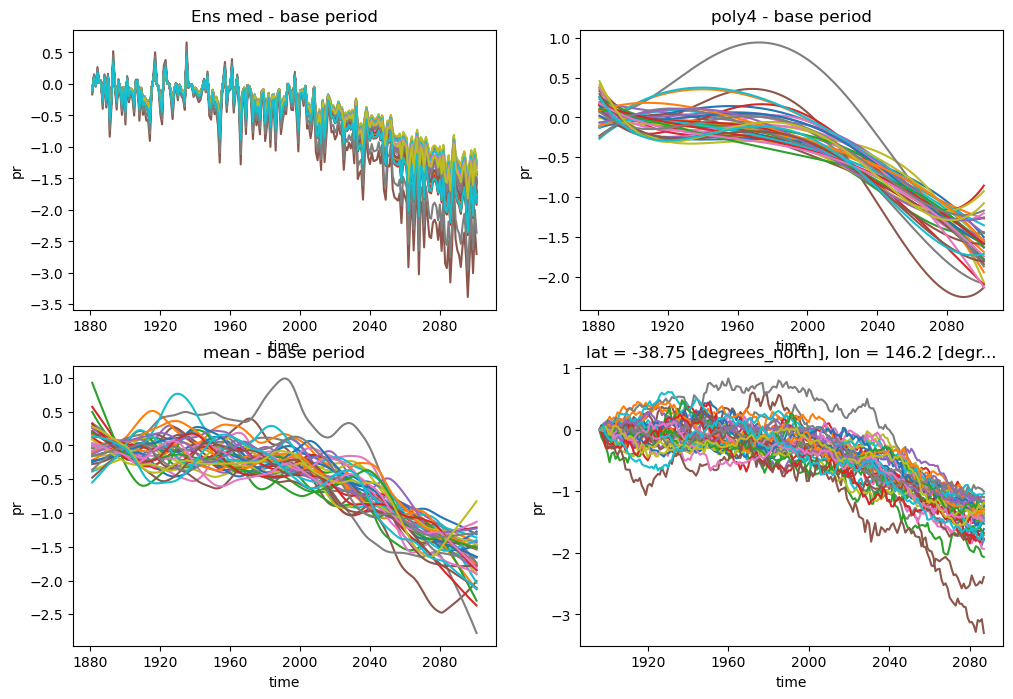

In [274]:
fig = plt.figure(figsize=(12, 8))
axes = [fig.add_subplot(2, 2, i+1) for i in range(4)]

sn_ens_med_base_period.sel(lat=-39, lon=145, method='nearest').plot(ax=axes[0], hue='member', add_legend=False);
sn_poly4_base_ds.sel(lat=-39, lon=145, method='nearest').plot(ax=axes[1],hue='member', add_legend=False);
sn_lowess_base_period_ds.sel(lat=-39, lon=145, method='nearest').plot(ax=axes[2],hue='member', add_legend=False);
sn_mean_base.sel(lat=-39, lon=145, method='nearest').plot(ax=axes[3],hue='member', add_legend=False);

axes[0].set_title('Ens med - base period')
axes[1].set_title('poly4 - base period')
axes[2].set_title('lowess - base period')
axes[2].set_title('mean - base period')

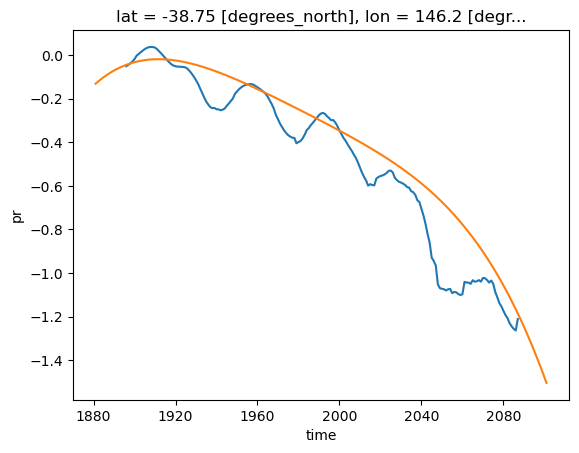

In [275]:
# sn_lowess_roll.isel(member=0).sel(lat=-39, lon=145, method='nearest').plot()
sn_lowess_roll_ds.isel(member=0).sel(lat=-39, lon=145, method='nearest').plot()
sn_poly4_base_ds.isel(member=0).sel(lat=-39, lon=145, method='nearest').plot()

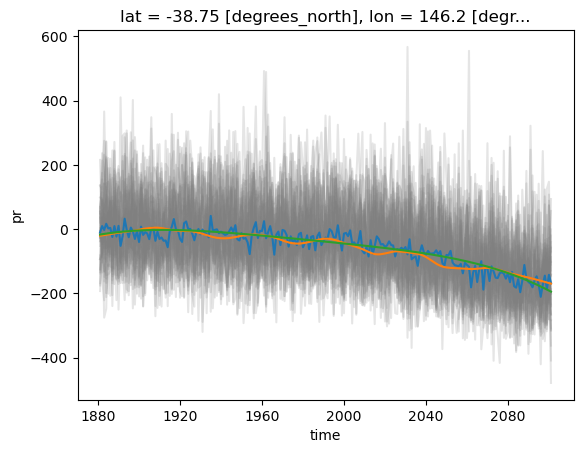

In [276]:
data_anom_ds.sel(lat=-39, lon=145, method='nearest').plot(hue='member', add_legend=False, color='grey', alpha=0.2);
singal_ens_median.sel(lat=-39, lon=145, method='nearest').plot()
ds_signal_lowess.isel(member=0).sel(lat=-39, lon=145, method='nearest').plot()
signal_pol4_da.isel(member=0).sel(lat=-39, lon=145, method='nearest').plot()

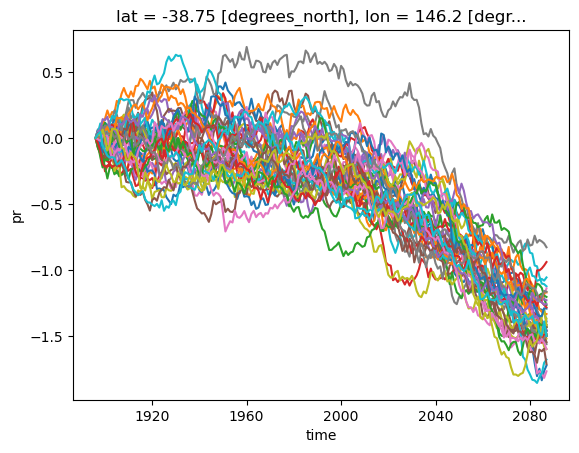

In [277]:
sn_mean_pi.sel(lat=-39, lon=145, method='nearest').plot(hue='member', add_legend=False);

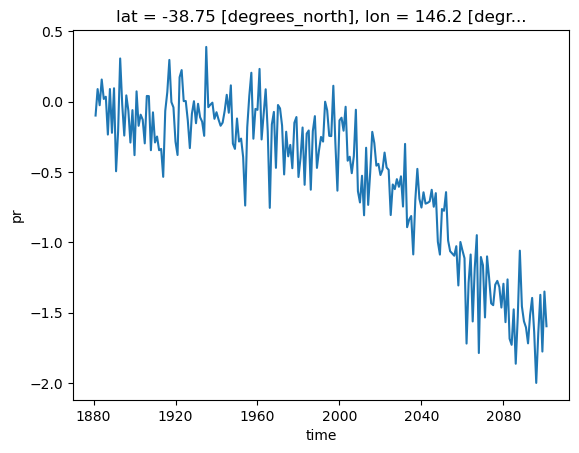

In [278]:
sn_ens_med_pi.sel(lat=-39, lon=145, method='nearest').plot(hue='member', add_legend=False)

<h1 style='color: yellow'>  Saving </h1>

In [62]:
save_dir = os.path.join(VAR_SAVE_DIR, "individual")

# Ensure the save directory exists
os.makedirs(save_dir, exist_ok=True)

In [280]:
# ds_signal_hawkins.name = 'signal_hawkins'
# ds_noise_series_hawkins.name = 'noise_hawkins'
# ds_sn_hawkins_full.name = 'sn_hawkins_full'
# ds_sn_hawkins_base_period.name = 'sn_hawkins_base'

In [286]:
# --- Signal datasets ---
ds_signal_lowess.name = "signal_lowess"
signal_pol4_da.name = "signal_poly4"
ds_signal_mean.name = "signal_mean"

# --- Noise datasets ---
ds_noise_series_poly4.name = "noise_poly4"
ds_noise_series_lowess.name = "noise_lowess"
rolling_noise_lowess_ds.name = "noise_lowess_rolling"
rolling_noise_mean_ds.name = "noise_mean_rolling"

# --- S/N datasets (always present) ---
sn_lowess_base_period_ds.name = "sn_lowess_base"
sn_lowess_full_ds.name = "sn_lowess_full"
sn_lowess_roll_ds.name = "sn_lowess_roll"

sn_mean_base_ds.name = "sn_mean_base"
sn_mean_roll_ds.name = "sn_mean_roll"

sn_poly4_base_ds.name = "sn_poly4_base"

# --- Ensemble and piControl S/N datasets (only if member coordinate exists) ---
if "member" in list(ds_signal_lowess.coords):
    sn_lowess_pi.name = "sn_lowess_pi"
    sn_mean_pi.name = "sn_mean_pi"
    sn_pol4_pi_ds.name = "sn_poly_pi"
    sn_ens_med_base_period.name = "sn_ens_med_base"
    sn_ens_med_pi.name = "sn_ens_med_pi"


In [287]:
# perkins_ds.name = 'perkins'
frac_geom_ds.name = 'frac'
hellinger_ds.name = 'hd'

In [288]:
# Everything matches variable names exactly
datasets = {
    "ds_signal_lowess": ds_signal_lowess,
    "signal_pol4_da": signal_pol4_da,
    "ds_signal_mean": ds_signal_mean,
    "ds_noise_series_poly4": ds_noise_series_poly4,
    "ds_noise_series_lowess": ds_noise_series_lowess,
    "rolling_noise_lowess_ds": rolling_noise_lowess_ds,
    "rolling_noise_mean_ds": rolling_noise_mean_ds,
    "sn_lowess_base_period_ds": sn_lowess_base_period_ds,
    "sn_mean_base_ds": sn_mean_base_ds,
    "sn_poly4_base_ds": sn_poly4_base_ds,
    "sn_lowess_full_ds": sn_lowess_full_ds,
    "sn_lowess_roll_ds": sn_lowess_roll_ds,
    "sn_mean_roll_ds": sn_mean_roll_ds,
    "frac_geom_ds": frac_geom_ds,
    "hellinger_ds": hellinger_ds,
    "rec_theory_ds": rec_theory_ds,
    "rec_theory_low_ds": rec_theory_low_ds,
    "mwu_ds": mwu_ds,
    "ttest_windows_ds": ttest_windows_ds,
    "ks_windows_ds": ks_windows_ds,
    "ttest_bbs_windows_ds": ttest_bbs_windows_ds,
    "ks_bbs_windows_ds": ks_bbs_windows_ds,
    "welch_ttest_ds": welch_ttest_ds,
    "ks_ds": ks_ds,
    "ttest_bbs_ds": ttest_bbs_ds,
    "ks_bbs_ds": ks_bbs_ds,
}

# Ensemble-based datasets (same rule: key = variable name)
if "member" in list(ds_signal_lowess.coords):
    datasets.update({
        "singal_ens_median": singal_ens_median,
        "ds_noise_series_ens_median": ds_noise_series_ens_median,
        "sn_ens_med_pi": sn_ens_med_pi,
        "sn_lowess_pi": sn_lowess_pi,
        "sn_ens_med_base_period": sn_ens_med_base_period,
        "sn_mean_pi": sn_mean_pi,
        "sn_pol4_pi_ds": sn_pol4_pi_ds,
        "pr_95_ds": pr_95_ds,
        "pr_99_ds": pr_99_ds,
    })

# Compute and save (names will *exactly* match variable names)
for i, (name, ds) in enumerate(datasets.items()):
    print(f"{i+1}/{len(datasets)}: Computing and saving {name}...")

    save_path = os.path.join(save_dir, f"{name}.zarr")

    # --- Apply member-aware chunking ---
    if 'window' in ds.dims: chunks = {'window':1}
    else: chunks = {}

    if "member" in ds.dims:
        chunks = {**chunks, **{"time": -1, "member": 5, "lat": -1, "lon": -1}}   
        ds = ds.chunk(chunks)
    
    ds.to_zarr(save_path, mode="w", consolidated=True, compute=True)

1/34: Computing and saving ds_signal_lowess...
2/34: Computing and saving signal_pol4_da...
3/34: Computing and saving ds_signal_mean...
4/34: Computing and saving ds_noise_series_poly4...
5/34: Computing and saving ds_noise_series_lowess...
6/34: Computing and saving rolling_noise_lowess_ds...
7/34: Computing and saving rolling_noise_mean_ds...
8/34: Computing and saving sn_lowess_base_period_ds...
9/34: Computing and saving sn_mean_base_ds...
10/34: Computing and saving sn_poly4_base_ds...
11/34: Computing and saving sn_lowess_full_ds...
12/34: Computing and saving sn_lowess_roll_ds...
13/34: Computing and saving sn_mean_roll_ds...
14/34: Computing and saving frac_geom_ds...
15/34: Computing and saving hellinger_ds...
16/34: Computing and saving rec_theory_ds...
17/34: Computing and saving mwu_ds...
18/34: Computing and saving ttest_windows_ds...
19/34: Computing and saving ks_windows_ds...
20/34: Computing and saving ttest_bbs_windows_ds...
21/34: Computing and saving ks_bbs_windows

In [88]:

save_dir = os.path.join(VAR_SAVE_DIR, "individual")

# Reopen and assign into globals
for fname in np.sort(os.listdir(save_dir)):
    print(fname)
    globals()[fname.replace('.zarr', '')] = xr.open_zarr(os.path.join(save_dir, fname))

ds_noise_series_ens_median.zarr
ds_noise_series_lowess.zarr
ds_noise_series_poly4.zarr
ds_signal_lowess.zarr
ds_signal_mean.zarr
frac_geom_ds.zarr
hellinger_ds.zarr
ks_bbs_ds.zarr
ks_bbs_windows_ds.zarr
ks_ds.zarr
ks_windows_ds.zarr
mwu_ds.zarr
pr_95_ds.zarr
pr_99_ds.zarr
rec_theory_ds.zarr
rolling_noise_lowess_ds.zarr
rolling_noise_mean_ds.zarr
signal_pol4_da.zarr
singal_ens_median.zarr
sn_ens_med_base_period.zarr
sn_ens_med_pi.zarr
sn_lowess_base_period_ds.zarr
sn_lowess_full_ds.zarr
sn_lowess_pi.zarr
sn_lowess_roll_ds.zarr
sn_mean_base_ds.zarr
sn_mean_pi.zarr
sn_mean_roll_ds.zarr
sn_pol4_pi_ds.zarr
sn_poly4_base_ds.zarr
ttest_bbs_ds.zarr
ttest_bbs_windows_ds.zarr
ttest_windows_ds.zarr
welch_ttest_ds.zarr


<h1 style='color: yellow'>  Merging </h1>

In [89]:
toe_metric_list = [
    rec_theory_ds.ratar, rec_theory_low_ds.ratar.rename('ratar_low'),
    ks_ds.pval.rename('ks'), welch_ttest_ds.pval.rename('ttest'), mwu_ds.pval.rename('mwu'),
    ks_windows_ds.pval.rename('ks_window'), ttest_windows_ds.pval.rename('ttest_window'),
    ks_bbs_ds.pval.rename('ks_bbs'), ttest_bbs_ds.pval.rename('ttest_bbs'),
    frac_geom_ds, hellinger_ds,
    sn_mean_roll_ds, sn_lowess_full_ds, sn_lowess_base_period_ds,
    sn_mean_base_ds, sn_lowess_roll_ds, sn_poly4_base_ds
]

if 'member' in list(data_ds.coords):
    print('Member in coords')
    toe_metric_list_model =\
        [ pr_95_ds.pr, pr_99_ds.pr,   #rec_empirical_ds.ratar,
         sn_ens_med_pi, sn_lowess_pi, sn_ens_med_base_period,
         sn_mean_pi, sn_pol4_pi_ds]

    toe_metric_list = toe_metric_list + toe_metric_list_model

# if 'member' not in list(data_ds.coords):
toe_metric_list = toe_metric_list + [
    ks_bbs_windows_ds.pval.rename('ks_bbs_window'),
    ttest_bbs_windows_ds.pval.rename('ttest_bbs_window')]


toe_metrics_ds = xr.merge(toe_metric_list, compat='override')
toe_metrics_ds = toe_metrics_ds.persist()
wait(toe_metrics_ds);
toe_metrics_ds

Member in coords


<xarray.Dataset> Size: 32GB
Dimensions:           (lat: 72, lon: 144, member: 40, time: 221, window: 6)
Coordinates:
  * lat               (lat) float64 576B -88.75 -86.25 -83.75 ... 86.25 88.75
  * lon               (lon) float64 1kB 1.25 3.75 6.25 ... 353.8 356.2 358.8
  * member            (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time              (time) datetime64[ns] 2kB 1880-12-31 ... 2100-12-31
  * window            (window) int64 48B 20 30 40 50 60 70
    quantile          float64 8B ...
Data variables: (12/25)
    ratar             (member, lat, lon, time) float64 733MB dask.array<chunksize=(5, 72, 144, 221), meta=np.ndarray>
    ratar_low         (member, lat, lon, time) float64 733MB dask.array<chunksize=(1, 18, 144, 221), meta=np.ndarray>
    ks                (member, lat, lon, time) float64 733MB dask.array<chunksize=(5, 72, 144, 221), meta=np.ndarray>
    ttest             (member, lat, lon, time) float64 733MB dask.array<chunksize=(5, 72, 144, 221), meta=np.ndarray>
    mwu               (member, lat, lon, time) float64 733MB dask.array<chunksize=(5, 72, 144, 221), meta=np.ndarray>
    ks_window         (window, member, lat, lon, time) float64 4GB dask.array<chunksize=(1, 5, 18, 36, 56), meta=np.ndarray>
    ...                ...
    sn_lowess_pi      (member, lat, lon, time) float64 733MB dask.array<chunksize=(5, 72, 144, 221), meta=np.ndarray>
    sn_ens_med_base   (lat, lon, time, member) float64 733MB dask.array<chunksize=(72, 144, 221, 5), meta=np.ndarray>
    sn_mean_pi        (member, lat, lon, time) float64 733MB dask.array<chunksize=(5, 72, 144, 221), meta=np.ndarray>
    sn_poly_pi        (member, lat, lon, time) float64 733MB dask.array<chunksize=(5, 72, 144, 221), meta=np.ndarray>
    ks_bbs_window     (window, member, lat, lon, time) float64 4GB dask.array<chunksize=(1, 5, 18, 36, 56), meta=np.ndarray>
    ttest_bbs_window  (window, member, lat, lon, time) float64 4GB dask.array<chunksize=(1, 5, 18, 36, 56), meta=np.ndarray>
Attributes: (2)

In [90]:
signal_list = [
    rec_theory_ds[['record_expected_count', 'record_count']],
    rec_theory_ds[['record_expected_count', 'record_count']].rename(
        {"record_expected_count": "record_expected_count_low",
         "record_count": "record_count_low"}
    ),
    ks_ds.stat.rename('ks'), welch_ttest_ds.stat.rename('ttest'),
    mwu_ds.stat.rename('mwu'),
    ks_windows_ds.stat.rename('ks_window'), ttest_windows_ds.stat.rename('ttest_window'),
    ks_bbs_ds.stat.rename('ks_bbs'), ttest_bbs_ds.stat.rename('ttest_bbs'),

    ds_signal_lowess, ds_noise_series_lowess,
    ds_signal_mean, rolling_noise_lowess_ds, rolling_noise_mean_ds,
    signal_pol4_da, ds_noise_series_poly4
]

if 'member' in list(ds_signal_lowess.coords):
    print('Member in coords')

    signal_list = signal_list +\
        [
            singal_ens_median, ds_noise_series_ens_median, 
            # rec_empirical_ds[['record_expected_count', 'record_count']],
            pr_95_ds[['pr_fac', 'num_fac']], pr_99_ds[['pr_fac', 'num_fac']]
        ]
    
# if 'member' not in list(data_ds.coords):
signal_list = signal_list + [
    ks_bbs_windows_ds.stat.rename('ks_bbs_window'),
    ttest_bbs_windows_ds.stat.rename('ttest_bbs_window')]

# THe signal is actually needed for lots of plots
signal_ds = xr.merge(signal_list, compat='override') 
signal_ds = signal_ds.persist()
wait(signal_ds);
signal_ds

Member in coords


<xarray.Dataset> Size: 29GB
Dimensions:                    (time: 221, member: 40, lat: 72, lon: 144,
                                window: 6)
Coordinates:
  * lat                        (lat) float64 576B -88.75 -86.25 ... 86.25 88.75
  * lon                        (lon) float64 1kB 1.25 3.75 6.25 ... 356.2 358.8
  * member                     (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r9i1p1'
  * time                       (time) datetime64[ns] 2kB 1880-12-31 ... 2100-...
  * window                     (window) int64 48B 20 30 40 50 60 70
    quantile                   float64 8B ...
Data variables: (12/23)
    record_expected_count      (time) float64 2kB dask.array<chunksize=(221,), meta=np.ndarray>
    record_count               (member, lat, lon, time) int64 733MB dask.array<chunksize=(5, 72, 144, 221), meta=np.ndarray>
    record_expected_count_low  (time) float64 2kB dask.array<chunksize=(221,), meta=np.ndarray>
    record_count_low           (member, lat, lon, time) int64 733MB dask.array<chunksize=(5, 72, 144, 221), meta=np.ndarray>
    ks                         (member, lat, lon, time) float64 733MB dask.array<chunksize=(5, 72, 144, 221), meta=np.ndarray>
    ttest                      (member, lat, lon, time) float64 733MB dask.array<chunksize=(5, 72, 144, 221), meta=np.ndarray>
    ...                         ...
    noise_poly4                (member, lat, lon, time) float64 733MB dask.array<chunksize=(5, 72, 144, 221), meta=np.ndarray>
    pr                         (lat, lon, time) float64 18MB dask.array<chunksize=(18, 36, 111), meta=np.ndarray>
    pr_fac                     (member, lat, lon, time) float64 733MB dask.array<chunksize=(5, 72, 144, 221), meta=np.ndarray>
    num_fac                    (member, lat, lon, time) float64 733MB dask.array<chunksize=(5, 72, 144, 221), meta=np.ndarray>
    ks_bbs_window              (window, member, lat, lon, time) float64 4GB dask.array<chunksize=(1, 5, 18, 36, 56), meta=np.ndarray>
    ttest_bbs_window           (window, member, lat, lon, time) float64 4GB dask.array<chunksize=(1, 5, 18, 36, 56), meta=np.ndarray>
Attributes: (4)

In [91]:
data_availability_mask = data_availability_mask.chunk('auto')

In [92]:
samp_data = data_anom_ds.sel(lat=-39, lon=145, method='nearest').isel(**member_kwargs).compute()

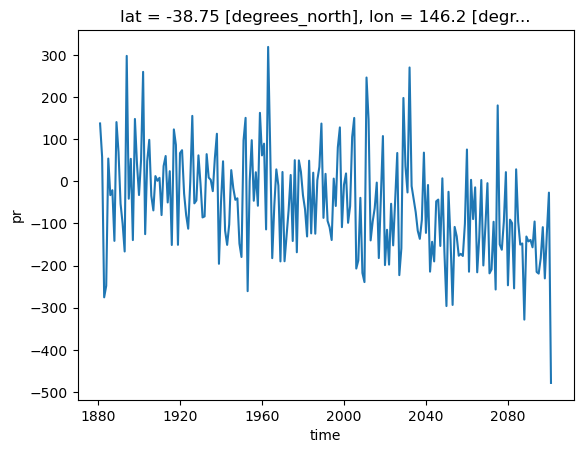

In [93]:
samp_data.plot(**plot_kwargs);

ratar, ratar_low, ks, ttest, mwu, ks_window, ttest_window, ks_bbs, ttest_bbs, frac, hd, sn_mean_roll, sn_lowess_full, sn_lowess_base, sn_mean_base, sn_lowess_roll, sn_poly4_base, pr, sn_ens_med_pi, sn_lowess_pi, sn_ens_med_base, sn_mean_pi, sn_poly_pi, ks_bbs_window, ttest_bbs_window, 

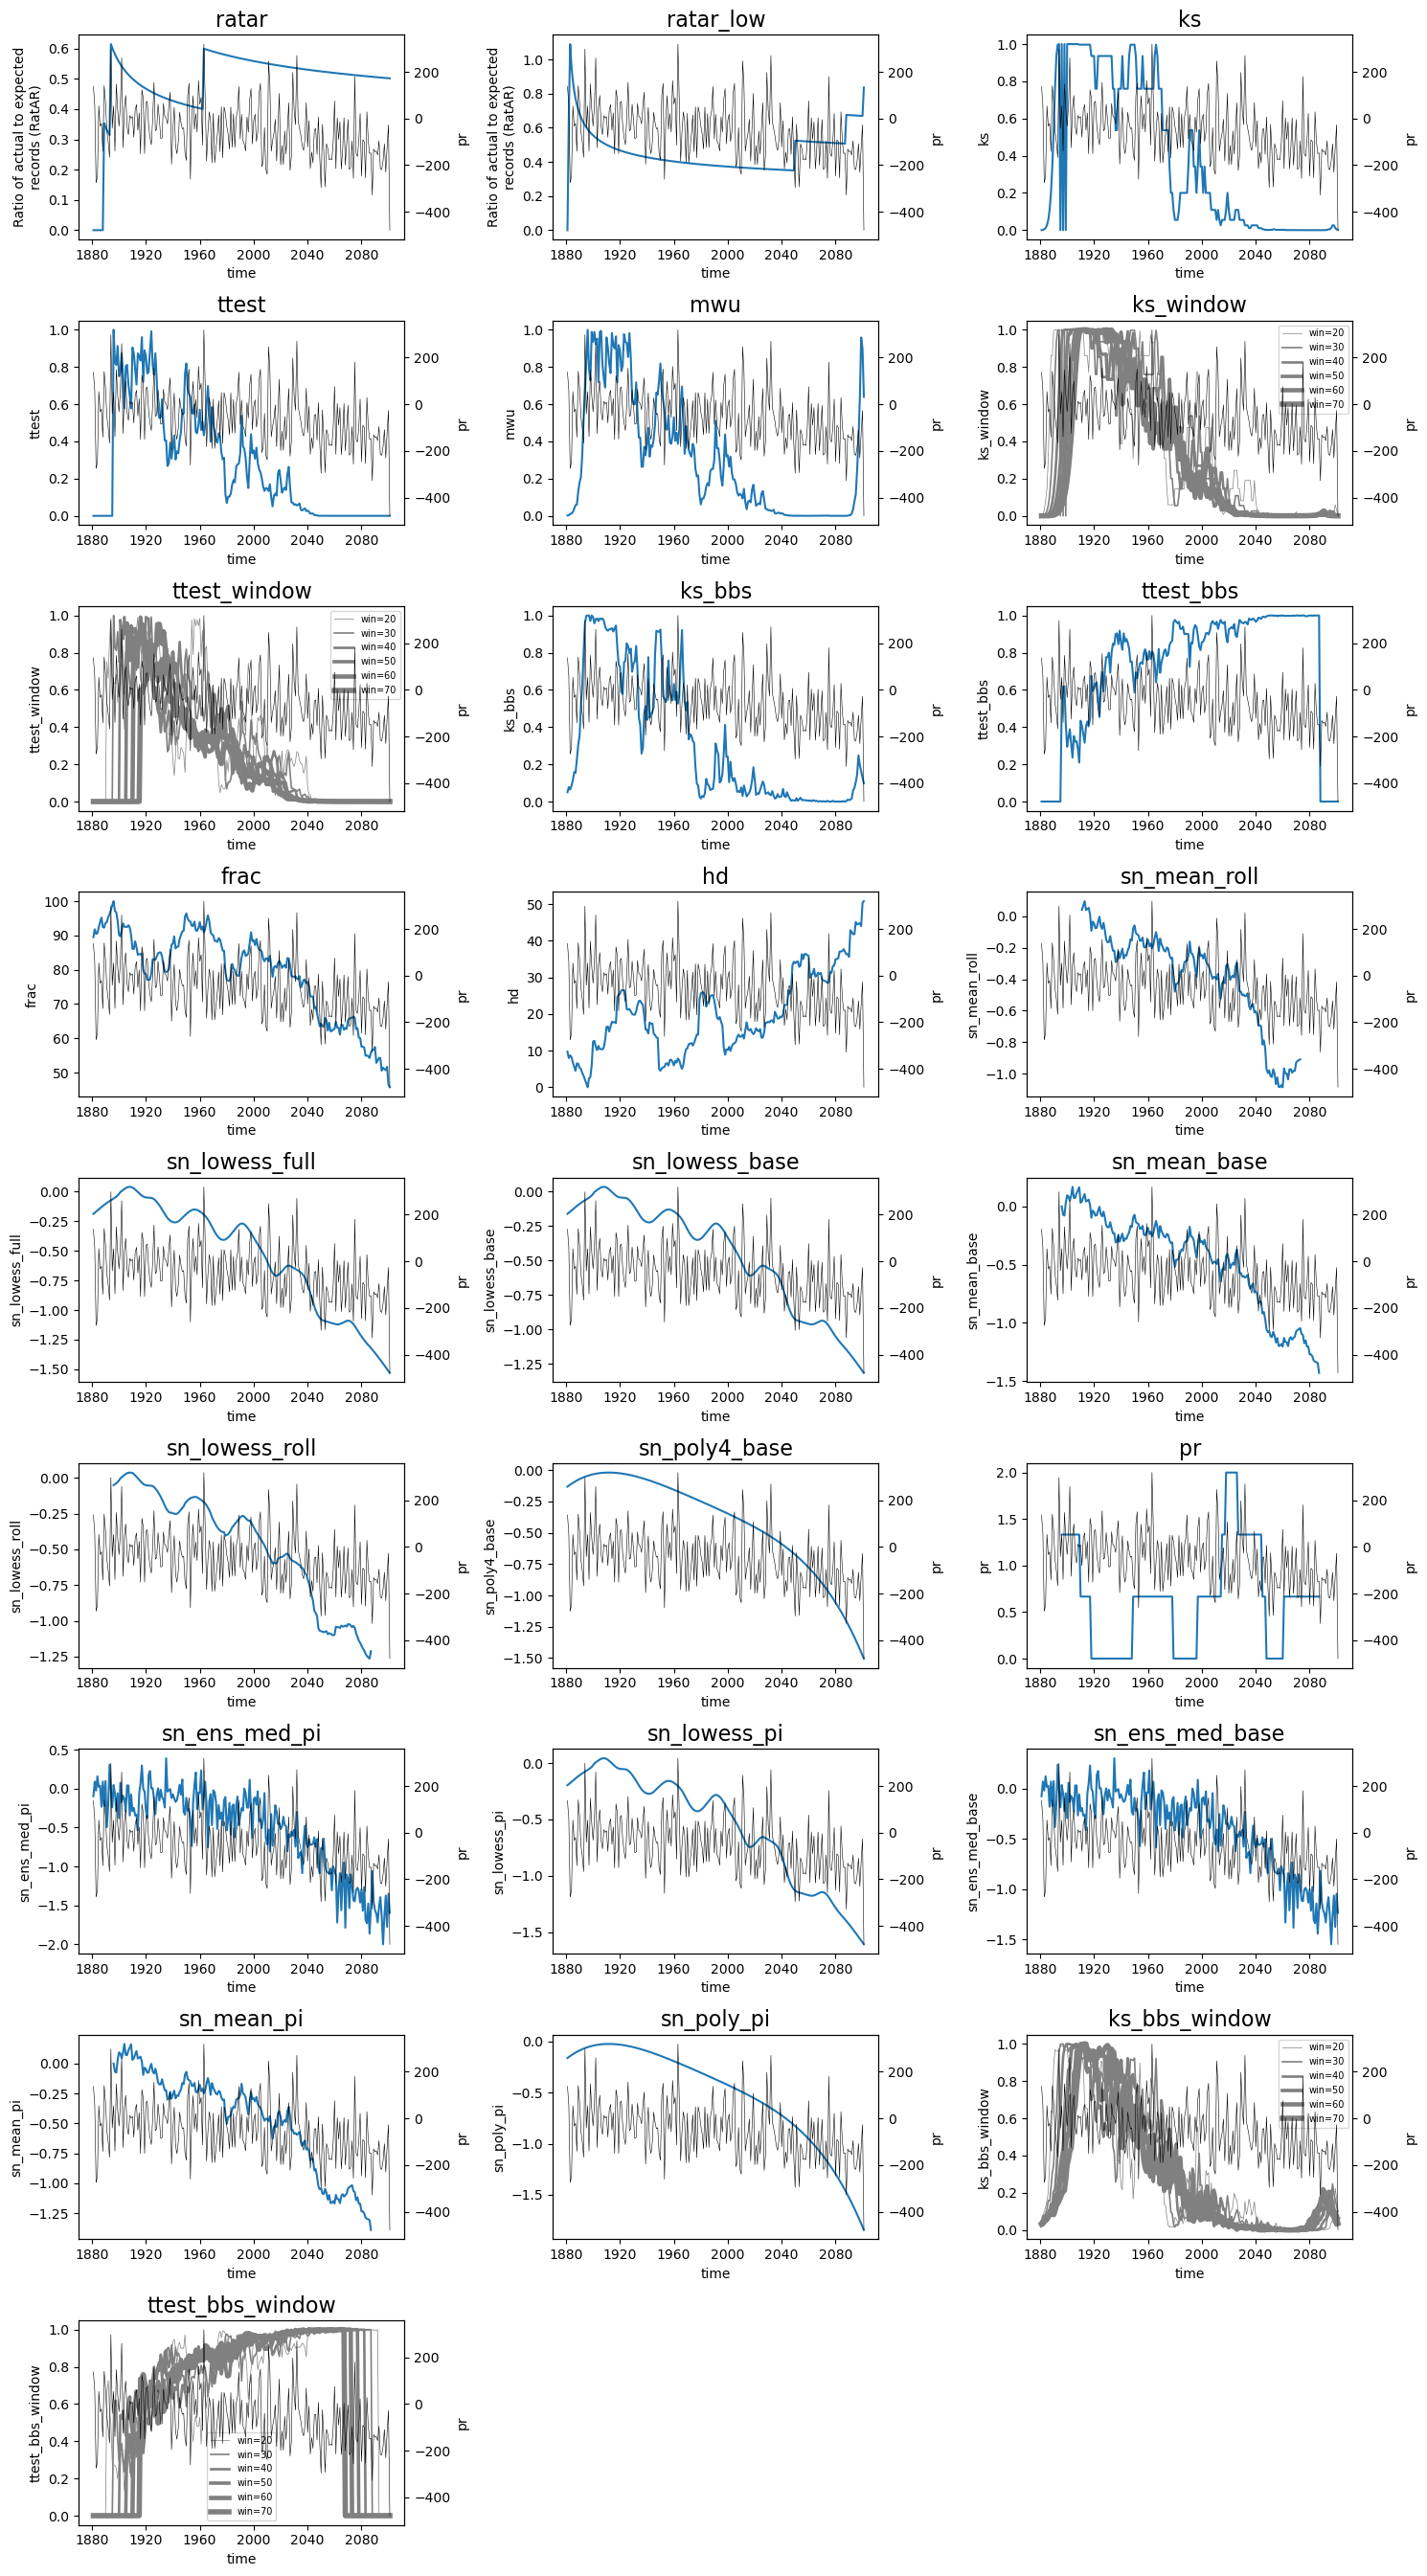

In [94]:
import math

nvars = len(toe_metrics_ds)
ncols = 3
nrows = math.ceil(nvars / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 3))
axes = axes.flatten()

toe_metrics_samp = toe_metrics_ds.sel(lat=-39, lon=145, method='nearest').compute()

for i, var in enumerate(toe_metrics_ds):
    print(f'{var}, ', end='')
    ax = axes[i]
    ax2 = ax.twinx()
    toe_metrics_da = toe_metrics_samp[var]

    if 'member' in list(toe_metrics_da.coords):
        toe_metrics_da = toe_metrics_da.isel(**member_kwargs)

    if 'window' not in list(toe_metrics_da.coords):
        toe_metrics_da.plot(ax=ax, **plot_kwargs)
    else:
        nwin = len(toe_metrics_da.window)
        lws = np.linspace(0.5, 4, nwin)

        for j, (win, lw) in enumerate(zip(toe_metrics_da.window.values, lws)):
            toe_metrics_da.sel(window=win).plot(
                ax=ax, label=f"win={win}", color="grey", linewidth=lw, **plot_kwargs
            )

        ax.legend(fontsize=7)
    samp_data.plot(ax=ax2, linewidth=0.4, color='k')
    ax.set_title(var, fontsize=16)
    ax2.set_title(None)


# remove empty subplots if nvars isn’t a multiple of ncols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

In [95]:
dataset_name, variable, base_period

('access_ssp585', 'pr', BasePeriod(start=1880, end=1909, length=29))

In [96]:
VAR_SAVE_DIR

'/g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_pr_(1880_1909)_04'

In [97]:
SAVE_KWARGS = dict( mode='w', consolidated=True, compute=True)

In [98]:

TOE_METRICS_SAVE_NAME = os.path.join(VAR_SAVE_DIR, "toe_metrics.zarr")
SIGNAL_SAVE_NAME = os.path.join(VAR_SAVE_DIR, "signal.zarr")
DATA_AVAILABILITY_SAVE_NAME = os.path.join(VAR_SAVE_DIR, "data_availability_mask.zarr")
DATA_SAVE_NAME = os.path.join(VAR_SAVE_DIR, "data.zarr")

print(
    TOE_METRICS_SAVE_NAME,
    SIGNAL_SAVE_NAME,
    DATA_AVAILABILITY_SAVE_NAME,
    DATA_SAVE_NAME,
    sep="\n"
)

/g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_pr_(1880_1909)_04/toe_metrics.zarr
/g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_pr_(1880_1909)_04/signal.zarr
/g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_pr_(1880_1909)_04/data_availability_mask.zarr
/g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_pr_(1880_1909)_04/data.zarr


In [99]:
def save_with_chunks(ds, save_name):
    """Apply chunking logic and save."""
    if "member" in ds.dims:
        print(f"Saving {save_name} with chunks: time:-1, member:5, lat:-1, lon:-1")
        ds = ds.chunk({"time": -1, "member": 5, "lat": -1, "lon": -1})
    else:
        print(f"Saving {save_name} with existing chunks: {chunks}")
        ds = ds.chunk(chunks)  # use your existing chunks variable

    ds.to_zarr(save_name, **SAVE_KWARGS)
    print(f"✅ Finished saving {save_name}\n")


In [100]:
save_with_chunks(data_anom_ds, DATA_SAVE_NAME)

Saving /g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_pr_(1880_1909)_04/data.zarr with chunks: time:-1, member:5, lat:-1, lon:-1
✅ Finished saving /g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_pr_(1880_1909)_04/data.zarr



In [101]:
save_with_chunks(toe_metrics_ds, TOE_METRICS_SAVE_NAME)

Saving /g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_pr_(1880_1909)_04/toe_metrics.zarr with chunks: time:-1, member:5, lat:-1, lon:-1
✅ Finished saving /g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_pr_(1880_1909)_04/toe_metrics.zarr



In [103]:
save_with_chunks(signal_ds, SIGNAL_SAVE_NAME)

Saving /g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_pr_(1880_1909)_04/signal.zarr with chunks: time:-1, member:5, lat:-1, lon:-1
✅ Finished saving /g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_pr_(1880_1909)_04/signal.zarr



In [106]:
data_availability_mask.to_zarr(DATA_AVAILABILITY_SAVE_NAME, **SAVE_KWARGS)

In [107]:
if 'le_pi_ds' in globals():
    print('Saving piControl')
    le_pi_ds.to_zarr(os.path.join(VAR_SAVE_DIR, f'piControl_{variable}.zarr'), **SAVE_KWARGS)

In [108]:
t_end = time()
time_taken = (t_end - t_start)/60
print(f'{time_taken=}minutes')

time_taken=5.359121755758921minutes


# Intercept Saving

In [ ]:
assert 1 == 0

In [ ]:
SIGNAL_SAVE_NAME

In [ ]:
TOE_METRICS_SAVE_NAME

In [ ]:
signal_ds = xr.open_dataset(SIGNAL_SAVE_NAME, engine='zarr')

In [ ]:
signal_ds = xr.merge(
    [signal_ds,
     singal_ens_median, ds_noise_series_ens_median, signal_pol4_da, ds_noise_series_poly4])

In [ ]:
signal_ds

In [ ]:
signal_ds.to_zarr(SIGNAL_SAVE_NAME, mode='w')

In [ ]:
toe_metrics_ds = xr.open_dataset(TOE_METRICS_SAVE_NAME, engine='zarr')

In [ ]:
toe_metrics_ds

In [ ]:
toe_metrics_ds = xr.merge(
    [toe_metrics_ds,
     sn_ens_med_pi, sn_lowess_pi, sn_poly4_base_ds, sn_lowess_roll, sn_ens_med_base_period, sn_mean_base, sn_mean_pi,
    sn_pol4_pi_ds
    ])

In [ ]:
toe_metrics_ds

In [ ]:
toe_metrics_ds.to_zarr(TOE_METRICS_SAVE_NAME, mode='w')

# Old

In [ ]:
# def _block_resample(series, length, block_size, rng):
#     """
#     Resample a 1D series using block bootstrap.

#     Parameters
#     ----------
#     series : array_like
#         Input 1D array.
#     length : int
#         Target length of the resampled series.
#     block_size : int
#         Block length for resampling.
#     rng : np.random.Generator
#         Random number generator.

#     Returns
#     -------
#     resampled : ndarray
#         Resampled array of length `length`.
#     """
#     n_blocks = int(np.ceil(length / block_size))
#     starts = rng.integers(0, len(series) - block_size + 1, size=n_blocks)
#     return np.concatenate([series[s:s+block_size] for s in starts])[:length]


# def block_bootstrap_statistic(arr1, arr2, func, block_size=5, n_boot=500, rng=None):
#     """
#     Block bootstrap version of the two-sample KS test.
#     Uses the exact DP p-value inside ks_test.

#     Parameters
#     ----------
#     arr1, arr2 : array-like
#         Input samples. Must be the same length (n1 = n2).
#     block_size : int
#         Length of resampling blocks.
#     n_boot : int
#         Number of bootstrap replicates.
#     rng : int or np.random.Generator, optional
#         Random seed or Generator for reproducibility.

#     Returns
#     -------
#     stat_obs : float
#         Observed statistic.
#     pval : float
#         Bootstrap p-value: fraction of bootstrap replicates ≥ observed.
#     """
#     rng = np.random.default_rng(rng)
#     n1, n2 = len(arr1), len(arr2)
#     if n1 != n2:
#         raise ValueError("Exact KS test requires equal sample sizes")

#     # Observed statistic (with exact pval)
#     stat_obs = func(arr1, arr2)

#     # Bootstrap replicates
#     boot_stats = np.empty(n_boot)
#     combined = np.concatenate([arr1, arr2])

#     for i in range(n_boot):
#         x_star = _block_resample(combined, n1, block_size, rng)
#         y_star = _block_resample(combined, n2, block_size, rng)
#         boot_stats[i] = func(x_star, y_star)

#     pval = np.mean(boot_stats >= stat_obs)
    
#     return stat_obs, pval

##### Old

In [ ]:
PI_CHUNKS = {'time':-1, 'lat':'auto', 'lon':'auto'}

In [ ]:
le_pi_ds = xr.open_mfdataset(os.path.join(PICONTROL_PATH, '*.nc'),
                             use_cftime=True).chunk(PI_CHUNKS).persist()

In [ ]:
le_pi_ds = le_pi_ds['pr']

In [ ]:
le_pi_ds.sel(lat=-39, lon=145, method='nearest').plot()

In [ ]:
data_ds

In [ ]:
le_pi_ds

In [ ]:
target_grid = data_ds.isel(time=0, member=0).drop_vars(['time', 'member']).compute()
target_grid

In [ ]:
climtas.regrid.cdo_generate_weights

In [ ]:
weights = climtas.regrid.cdo_generate_weights(le_pi_ds, target_grid, method='con')

In [ ]:
regridder = climtas.regrid.Regridder(weights = weights)

In [ ]:
le_pi_ds = regridder.regrid(le_pi_ds).persist()
wait(le_pi_ds);

In [ ]:
# target_grid = data_ds.isel(time=0).squeeze().drop_vars('time')

In [ ]:
# regridder = climtas.regrid.Regridder(le_pi_ds, target_grid, method='conservative')

In [ ]:
# le_pi_ds = regridder.regrid(le_pi_ds)

In [ ]:
# le_pi_ds = le_pi_ds.compute()

In [ ]:
le_pi_ds.isel(time=100).plot()

In [ ]:
# le_pi_ds.to_zarr(
#     f'/g/data/w40/ab2313/time_of_emergence/access_picontrol_{variable}.zarr', mode='w')
# wait(le_pi_ds);

In [ ]:
le_pi_ds_noise = le_pi_ds.std(dim='time').compute()

In [ ]:
singal_ens_median = data_anom_ds.median(dim='member')

In [ ]:
sn_pi = (ds_signal_lowess/le_pi_ds_noise).persist()
sn_ens_med = (singal_ens_median/le_pi_ds_noise).persist()
wait(sn_ens_med);

In [ ]:
sn_pi.name = 'sn_pi'
sn_ens_med.name = 'sn_ens_med'

In [ ]:
data_anom_ds.sel(lat=-39, lon=145, method='nearest').plot(hue='member', add_legend=False);
singal_ens_median.sel(lat=-39, lon=145, method='nearest').plot(color='k');

In [ ]:
sn_pi.sel(lat=-39, lon=145, method='nearest').plot(hue='member', add_legend=False);
sn_ens_med.sel(lat=-39, lon=145, method='nearest').plot(color='k');

### Perkins

In [ ]:
data_arr = data_ds.values.flatten()
data_arr.shape
# #data_arr = data_arr[data_arr != 0]

In [ ]:
bins = toe_calc.calculate_freedman_diaconis_bins(
    data_arr, length=len(data_ds.time.values), logginglevel='DEBUG')

np.unique(np.diff(bins).round(6)).item(), bins

In [ ]:
# bins = np.arange(bins[0], bins[-1]+0.5, 0.5) # For temperature
bins = np.arange(bins[0], bins[-1]+100, 100) # For precip

In [ ]:
bins

In [ ]:
# dmin = data_ds.min().values.item()
# dmax = data_ds.max().values.item()
# dmin, dmax

In [ ]:
# bins = np.arange(dmin, dmax+1, 1)

In [ ]:
# np.min(bins), np.max(bins)

In [ ]:
# Example latitudes and longitudes range (adjust as needed)
lats = np.linspace(-38.5, -37.5, 3)  # Replace with your actual latitudes
lons = np.linspace(144.5, 146.5, 3)  # Replace with your actual longitudes

# Create a 3x3 plot grid
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# Loop through latitudes and longitudes
for i, lat in enumerate(lats):
    for j, lon in enumerate(lons):
        # Extract the data for the current lat, lon
        test_data = data_ds.sel(lat=lat, lon=lon, method='nearest').values
        
        # Compute the KDE
        _, rel_freq = toe_calc.discrete_pdf(test_data, bins=bins)
        x_test, kde_test = toe_calc.create_kde(test_data, **kde_kwargs)

        # Plot on the current subplot
        ax = axs[i, j]
        ax2 = ax.twinx()
        ax.bar(bins[:-1], rel_freq, width=np.diff(bins), align='edge', edgecolor='k')
        ax2.plot(x_test, kde_test, color='r')
        ax.set_title(f'Lat: {lat}, Lon: {lon}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        valid_bins = bins[:-1][rel_freq > 0]
        x_min, x_max = valid_bins.min()-5*np.diff(bins)[0], valid_bins.max()+5*np.diff(bins)[0]
        ax.set_xlim(x_min, x_max)

In [ ]:
%%time
# Pre-calculate the relative frequency of the base period

base_period_rel_freq_ds = xr.apply_ufunc(
    toe_calc.get_rel_freq,
    base_period_ds,
    input_core_dims=[['time']],
    output_core_dims=[['bins']],
    kwargs={'bins': bins},
    vectorize=True,
    dask='parallelized',
    output_sizes={'bins': len(bins) - 1}, 
    output_dtypes=float
).persist()
wait(base_period_rel_freq_ds)

In [ ]:
%%time
perkins_ds = xr.apply_ufunc(
    toe_calc.perkins_skill_score_base_bins,
    data_ds_window,
    base_period_rel_freq_ds,
    kwargs={'bins': bins},
    input_core_dims=[['window_dim'], ['bins']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized',
    output_dtypes=float
    ).compute()

In [ ]:
perkins_ds = perkins_ds.sortby('lat')

In [ ]:
perkins_ds.attrs = {
    'window': window,
    **perkins_ds.attrs,
    'bins': 
    {
        'start':bins.round(4)[0],
        'stop':bins.round(4)[-1],
        'step': np.unique(np.diff(bins)).round(4)[0]}
}

In [ ]:
location = dict(lat=69, lon=-165, method='nearest')

In [ ]:
perkins_ds.sel(**location).plot()

In [ ]:
base_arr = base_period_ds.isel(member_kwargs).sel(**location).values


future_arr = (data_ds.sel(**location)
              .isel(member_kwargs)
              .sel(time=slice(str(base_period.start), str(base_period.end)))
              .values)

rel_freq_base = toe_calc.rel_freq(base_arr, bins)
rel_freq_future = toe_calc.rel_freq(future_arr, bins=bins)

In [ ]:
toe_calc.discrete_distribution_overlap(rel_freq_base, rel_freq_future),\
toe_calc.perkins_skill_score(future_arr, base_arr, bins=bins),\
perkins_ds.sel(**location).isel(time=int(window/2), **member_kwargs).values.item()

In [ ]:
fig, ax = plt.subplots(1, 1)
diagnostic_tools.plot_bar(bins, rel_freq_base, ax=ax)
diagnostic_tools.plot_bar(bins, rel_freq_future, ax=ax)

In [ ]:
toe_calc.perkins_skill_score_base_bins(
    data_ds_window.isel(member_kwargs).sel(lat=-39, lon=145,method='nearest').isel(time=slice(None, 31)).values,
    base_period_rel_freq_ds.isel(member_kwargs).sel(lat=-39, lon=145,method='nearest').values,
    bins=bins
)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)

test_loc = dict(lat=-39, lon=145, method='nearest')
rel_freq_test = toe_calc.get_rel_freq(base_period_ds.sel(**test_loc).isel(**member_kwargs).squeeze().values, bins=bins)

ax1.bar(base_period_rel_freq_ds.bins.values, rel_freq_test)
ax2.bar(base_period_rel_freq_ds.bins.values, base_period_rel_freq_ds.sel(**test_loc).isel(**member_kwargs).values)

In [ ]:
perkins_ds.isel(time=int(window/2), **member_kwargs).plot();

In [ ]:
# These should all be 100
perkins_ds.sel(lat=[-80, 0, 60, 88], lon=145, method='nearest').isel(time=window//2).plot(hue='lat');

In [ ]:
perkins_ds.isel(time=[int(window/2), 35, 50], **member_kwargs).plot(col='time', levels=np.arange(0, 110, 5))